### This version (v2) implements a weighted random sample choice of initial state "keys," then continues with the loop to choose multiple sets of models, and records the fit parameters. Also makes a histogram to check results. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from astropy.io import fits
import lmfit
import time
import glob
from scipy import *
import random
from tqdm import tqdm

In [29]:
# load up all my fits files, make dictionaries with keys to (a) put energy and strength values and (b) 
# have a (pseudo-) ordered one for my random sampling for making my model

# note: the way my 'random' (ish) sampler is currently made, you need to have fits files for n states that range
# from (n_max)-2 to (n_max)+2. 

listA=glob.glob('./S01/data_corr/S01_nljjJ_*') # H-like
listB=glob.glob('./S02/data_corr/S02_nljjJ_*') # He-like

mydict={}

# for H-like 
nums = [value[26:36] for value in listA] # this will be a list of all my future keys for my dictionary and then model

for value in nums: # use the keys to access the fits info 
    filename='./S01/data_corr/S01_nljjJ_'+value+'.c.follow.fits'
    with fits.open(filename,memmap=False) as hdulist:
        mydict[value]=[hdulist[1].data.field("Energy"),hdulist[1].data.field("Strength")]
        del hdulist[1].data


# now for He-like
nums = [value[26:36] for value in listB]

for value in nums: # get list of files 
    filename='./S02/data_corr/S02_nljjJ_'+value+'.c.follow.fits'
    with fits.open(filename,memmap=False) as hdulist:
        mydict[value]=[hdulist[1].data.field("Energy"),hdulist[1].data.field("Strength")]
        del hdulist[1].data

# this is my filter transmission and ice stuff - to be used when I need to back-correct models to compare to lab data
# en, tr = loadtxt('filter_ice_transmission_SHe.txt', dtype='float', unpack=True) 
# I made this by hand: filter * ice (0.323 um) from 2400-3500 eV


sortedkeys = sorted(mydict.keys()) # this is now a list of keys, sorted by number


a=int(sortedkeys[0][0:2]) #want the first two characters of the first element, then I want to turn to int
b=int(sortedkeys[-1][0:2]) 


sorteddict={i:[] for i in range(a,b+1)}


for i in range(a,b+1):
    temp=[]
    for j in sortedkeys:
        if int(j[0:2]) == i:
            temp.append(j)
    sorteddict[i]=temp

    
print(sorteddict)
# now sorteddict has a key for each n level in my sample, and the values for that key are all the keys from mydict

{4: ['0400000001', '0400010100', '0400010102', '0401000001', '0401000003', '0401010000', '0401010002', '0401010102', '0401010104', '0402000003', '0402000005', '0402010002', '0402010004', '0402010104', '0402010106', '0403000005', '0403000007', '0403010004', '0403010006', '0403010106', '0403010108'], 5: ['0500000001', '0500010100', '0500010102', '0501000001', '0501000003', '0501010000', '0501010002', '0501010102', '0501010104', '0502000003', '0502000005', '0502010002', '0502010004', '0502010104', '0502010106', '0503000005', '0503000007', '0503010004', '0503010006', '0503010106', '0503010108', '0504000007', '0504000009', '0504010006', '0504010008', '0504010108', '0504010110'], 6: ['0600000001', '0600010100', '0600010102', '0601000001', '0601000003', '0601010000', '0601010002', '0601010102', '0601010104', '0602000003', '0602000005', '0602010002', '0602010004', '0602010104', '0602010106', '0603000005', '0603000007', '0603010004', '0603010006', '0603010106', '0603010108', '0604000007', '0604

In [30]:
# load up your experimental or fake data you want to fit 

# easier one
#data_x=np.loadtxt('fakespec_x.txt',unpack=True)
#data_y=np.loadtxt('fakespec_y.txt',unpack=True)

# harder one
data_x=np.loadtxt('fakespec_x2.txt',unpack=True)
data_y=np.loadtxt('fakespec_y2.txt',unpack=True)

# following section is for S data --------------------
#datafilename='flux_CX_S_He.txt' # REMEMBER: the x is in keV, so you have to multiply by 1000!
#data_x,data_y=loadtxt(datafilename,usecols=(0,2),unpack=True)
#data_x=(data_x+0.0005)*1000

# now limit my data to only values between 2400-3500 eV
#data_x=data_x[2400:3500]
#data_y=data_y[2400:3500]

### HERE I AM SHIFTING MY ENERGIES FROM 3000-3500 eV BY A TOTAL OF max_shift BY END (linear stretch of energy)
#max_shift=0.6
#delta=linspace(0,max_shift,num=500)

#data_del=data_x[600:]+delta
#data_x[600:]=data_del
# that above section was for S data --------------------

# this is something I needed for Ni data I guess? 
##home = os.path.expanduser ('~')
##basepath='Documents/Calorimeter_Research/EBIT/CX2016/cross_section_models/cascades/'
##speciesfolder='Ni/Ni10/data'
##modelpath = os.path.join (home,basepath,speciesfolder)

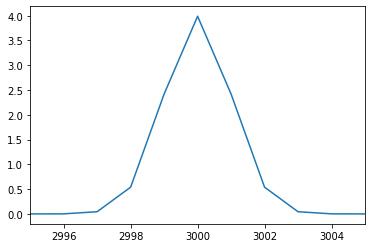

In [31]:
# function to make a gaussian shape 

def make_gaussian(g_x, g_cen, g_amp, g_wid):
    g=(g_amp/(np.sqrt(2*np.pi)*g_wid)) * np.exp(-(g_x-g_cen)**2 /(2*g_wid**2))
    return g

# test for pretty picture
g=make_gaussian(data_x,3000,10,1)
plt.plot(data_x,g)
plt.xlim(2995,3005)
plt.show()


In [32]:
# function to grab a cascade file you want to use to create the spectrum  

def get_model_deets(key):
    key=str(key)
    if len(key)<10:
        key='0'+key
    en_st_array=mydict.get(key)
    energy=en_st_array[0]
    strength=en_st_array[1]
    #both=column_stack((energy, strength))
    #i=where(energy>0) # THIS SECTION TOOK AWAY ALL MY NEGATIVE VALUES FOR TWO-PHOTON TRANSITIONS
    k=np.where(energy>2400) 
    j=np.where(energy<3500)
    i=np.intersect1d(k,j)
    new_energy=energy[i]
    new_strength=strength[i]
    
    modeldeets=np.column_stack((new_energy,new_strength)) # so here I have made a new 2D array with columns 
    #being energy and strength, for the lines in the band I care about, from each Maurice file I call.
    #print 'modeldeets are: '
    #print modeldeets
    return modeldeets

In [33]:
# function to make an individual model spectrum from one particular cascade file 

def ind_cx_model(m_egrid, m_sig, m_norm, key):
    linelist=get_model_deets(key)
    shape=np.zeros(len(m_egrid))
    # get info on filter transmission and ice--presumably this is one file going up to 9999 eV with both corrections multiplied together
    #en, tr = loadtxt('/Users/gbetanco/Documents/Calorimeter_Research/EBIT/CX2016/IceCalc/ice_filter_transmission.txt', dtype='float', unpack=True)

    for i in np.arange(len(linelist)): 
        cen=linelist[i,0]
        #round_center=round(cen)
        #print 'round center= '+str(round_center)
        #transmission=tr[where(en==round_center)]
        #print 'transmission= '+str(transmission)
        #transmission=1.
        amp=linelist[i,1]*m_norm#*transmission[0]
        # print 'max amp ='+str(amp)
        g=make_gaussian(m_egrid,cen,amp,m_sig)
        #print max(g)
        shape=np.add(shape,g)
    
    return shape



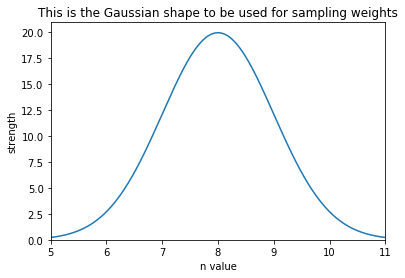

for nmax-2 to nmax+2, my weights are: [ 2.69954833 12.09853623 19.94711402 12.09853623  2.69954833]


In [34]:
# here is a quick visual for the gaussian-ish-weighted sampling I will do: 

x=np.arange(0,15,step=0.01)
u=8 # mean -- change this part if you want different n max
a=50 # amp
s=1 #sigma -- change this part if you want to be more narrow
y=make_gaussian(x, u, a, s)
plt.plot(x,y)
plt.xlim(u-3,u+3)
plt.ylim(0,np.max(y)*1.05)
plt.title('This is the Gaussian shape to be used for sampling weights')
plt.xlabel('n value')
plt.ylabel('strength')
plt.show()

values=make_gaussian(np.arange(u-2,u+3),u,a,s)
print('for nmax-2 to nmax+2, my weights are: '+str(values))

In [36]:
# here is where my random sampling starts! 
# a function to generate a sample of keys. I want to have a gaussian distribution of n values around some principle 
# n capture state, with sigma = 1, so that I mostly get states from that n, then fewer states from n-1 and n+1, etc. 
# Within that n value (and across l, j, J etc), it will sample uniformly and randomly. Returns "random_keys," which 
# is a set of 10 keys sampled/chosen in this way. 



def makekeys(dictkeylistname, nmax, num_models, sigma=1, n_spread=2): # takes as an input the name of my list of ordered dict keys, 
    #the principle capture state n, and the number of keys it should generate at a time
    
    # first make normal distribution around nmax for first round
    amp=1
    #sigma=1
    #n_spread=2 # change this if you want the n values to be more or less spread around n_max
    all_n=np.arange(nmax-n_spread, nmax+n_spread+1) # give me a list of n values (integers), centered around nmax, going as low as n-2 and as high as n+2
    p=make_gaussian(all_n,nmax,amp,sigma) # my gaussian-ish weights for sampling
    p=p/p.sum(0)
    #nlist=np.random.normal(nmax, sigma, num_models).round().astype(np.int) # this should give me [num_models] integers of mostly nmax
    nlist=np.random.choice(all_n,size=10,p=p) # this should give me 10 integers of mostly nmax (gaussian-ish weighted sampling)
    #print(nlist)
    
    #
    unique, counts = np.unique(nlist, return_counts=True) 
    sizedict = dict(zip(unique, counts)) # makes a dictionary with each n value in nlist and how many times it occurs 
    #print(sizedict)
    randkeys = [] # my future array with [num_models] semi-randomly selected models for my fit 
    
    for n in sizedict.keys(): 
        #print(sorteddict[n],sizedict[n])
        randkeys.append(np.random.choice(sorteddict[n], size=sizedict[n], replace=False))
        
    randkeys=np.concatenate(randkeys)
    return randkeys 


#     randkeys=[]
    
#     # now sample uniformly within that n value
#     for nval in nlist: 
#         for key in sorteddict.keys():
#             if nval == key:
                
#                 while True:
#                     new = random.sample(sorteddict[key],1)[0]
#                     if np.isin(new, randkeys)==False:
#                         randkeys.append(k)
#                     else:
#                         break


                                
    #print(randkeys)                            
    #randkeys=randkeys[0]
                   
                                
#print(type(random.sample(sorteddict[key],1)))                                
randkeys=makekeys(sortedkeys, 8, 10, sigma=1, n_spread=2)
print(randkeys)

['0602010004' '0605010010' '0703000005' '0700000001' '0703010006'
 '0802000003' '0800000001' '0807010014' '0805000009' '0903010006']


In [44]:
# function to generate a composite model nade of *10* (this can be changed) individual models. It will do my random
# sampling as described above nrun times. Once it generates the composite model, it fits it to the given data and 
# performs a least-squares minimization. 


def randmodel(nrun=100, nmax=8, num_models=10, sigma=1, n_spread=2):
    #nmax=8
    #num_models=10
    start_time = time.time()
    
    # create empty lists
    
    # nrun is already going to be saved as index of all of these
    minimizers=[] # cstat, eventually, or chi squared from fit
    sigmas=[] # gaussian sigma of lines in fit
    keys=[] # keys of models in fit; this will be a multi-dimensional list
    norms=[] # norms of models in fit; this will be a multi-dimensional list
    spectra=[] # data_y of fit; this will be a multi-dimensional list
    
    
    for run in tqdm(range(nrun)):
        #print(run)
        mymodel=lmfit.Model(ind_cx_model,prefix='m1_')+lmfit.Model(ind_cx_model,prefix='m2_')+lmfit.Model(ind_cx_model,prefix='m3_')+lmfit.Model(ind_cx_model,prefix='m4_')+lmfit.Model(ind_cx_model,prefix='m5_')+lmfit.Model(ind_cx_model,prefix='m6_')+lmfit.Model(ind_cx_model,prefix='m7_')+lmfit.Model(ind_cx_model,prefix='m8_')+lmfit.Model(ind_cx_model,prefix='m9_')+lmfit.Model(ind_cx_model,prefix='m10_')
        pars = mymodel.make_params ()

        #random_keys = random.sample(mydict.keys(), 10) # this gives me ten individual keys but this is uniformly sampled
        random_keys=makekeys(sortedkeys, nmax, num_models, sigma, n_spread) # nmax for capture, number of keys per composite model
        #print('random keys are ' +str(random_keys))
        
        # model 1
        pars["m1_m_sig"].set(3.0,min=2.0,max=4.5)
        pars["m1_m_norm"].set(1.,min=0.0)
        pars["m1_key"].set(int(random_keys[0]),vary=False)

        # models 2-10
        for i in np.arange(2,11):
            #print('i= '+str(i))
            pars["m"+str(i)+"_m_sig"].set(expr='m1_m_sig')
            pars["m"+str(i)+"_m_norm"].set(1,min=0.0) 
            #print('key is '+str(random_keys[i-1]))
            pars["m"+str(i)+"_key"].set(int(random_keys[i-1]),vary=False) #IndexError: list index out of range

        # this gives us out 'pars' and 'mymodel' to now be used by lmfit.
        
        #print(pars)
        #print(mymodel)
  
        # now feed this into the model and fit to the data using a minimizer. 

        result=mymodel.fit(data_y,pars,m_egrid=data_x,method='Leastsq',weights=(1./(1+(np.sqrt(data_y+0.75)))),fit_kws={'maxfev': 500})
        
        # save my parameters for this fit run
        minimizers.append(result.redchi)
        sigmas.append(result.params['m1_m_sig'].value)
        spectra.append(result.best_fit)

        modelkeys=[]
        modelnorms=[]
        for i in np.arange(1,11):
            modelkeys.append(result.params['m'+str(i)+'_key'].value)
            modelnorms.append(result.params['m'+str(i)+'_m_norm'].value)

        keys.append(modelkeys)
        norms.append(modelnorms)
        
        
#         print('printing report: ')
#         print(result.fit_report(min_correl=0.25))
#         print('number of function evaluations is '+str((result.nfev)))
#         print('number of data points is '+str((result.ndata)))
#         print('number of variables is '+str((result.nvarys)))
#         print('number of degrees of freedom is '+str((result.nfree)))
#         print('chi squared is '+str((result.chisqr)))
#         print('reduced chi squared is '+str((result.redchi)))

#         weights=(1./(1+(np.sqrt(data_y+0.75))))
#         np.savetxt('best_fit_result_testv0.txt',np.transpose([data_x,result.best_fit]))
#         np.savetxt('best_fit_residual_testv0.txt',np.transpose([data_x,result.residual]))
#         np.savetxt('weights_testv0.txt',weights)

#         plt.plot(data_x,data_y,label='data')
#         plt.plot(data_x, result.best_fit, 'r-',label='test fit')
#         plt.legend()
          
    print(f"for {nrun} iterations: {time.time() - start_time:.3f} seconds")
#     print(f"{i:.2f} {j:.2f}")
    return minimizers, sigmas, keys, norms, spectra



## This is the model fitting part; change nrun, nmax, num_models here if you'd like. 
### You also have the option of changing the shape of the weighting function for the n values via 'sigma' and 'n_spread'

In [45]:
# now actually do this random sampling and fit. Spit out the chi square value to look at later. 

all_minimizers, all_sigmas, all_keys, all_norms, spectra = randmodel(nrun=10, nmax=8, num_models=10, sigma=1, n_spread=2)

for val in all_minimizers:
    print(f"{val:.2e}")

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]

for 10 iterations: 23.634 seconds
7.85e-02
7.84e-02
7.57e-02
7.18e-02
6.86e-02
7.62e-02
7.57e-02
8.23e-02
1.55e-02
7.29e-02


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


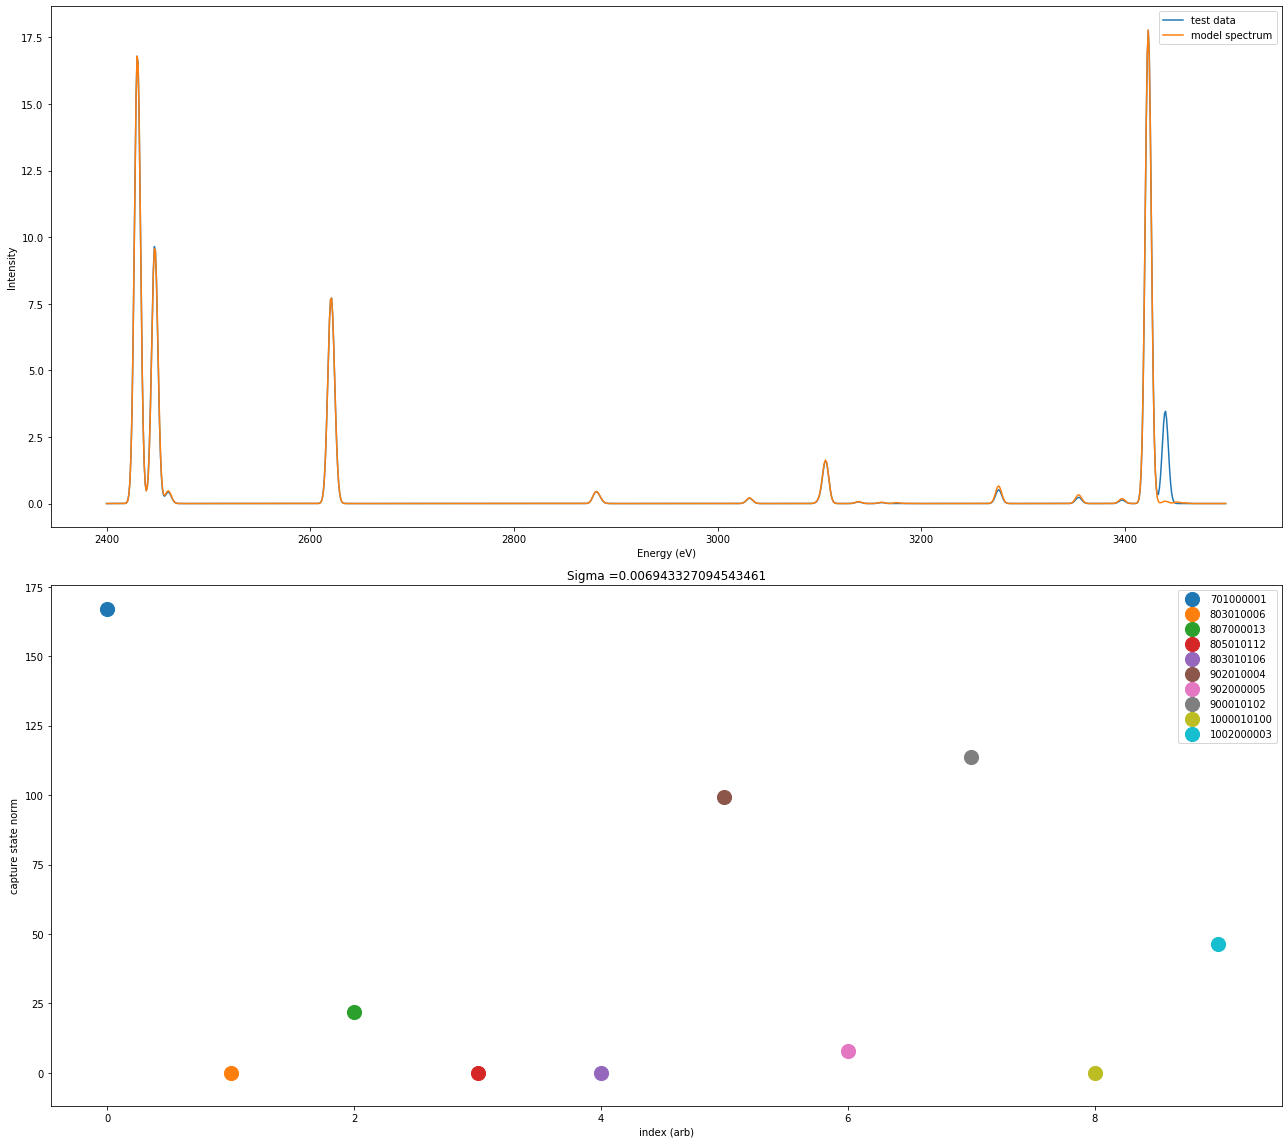

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


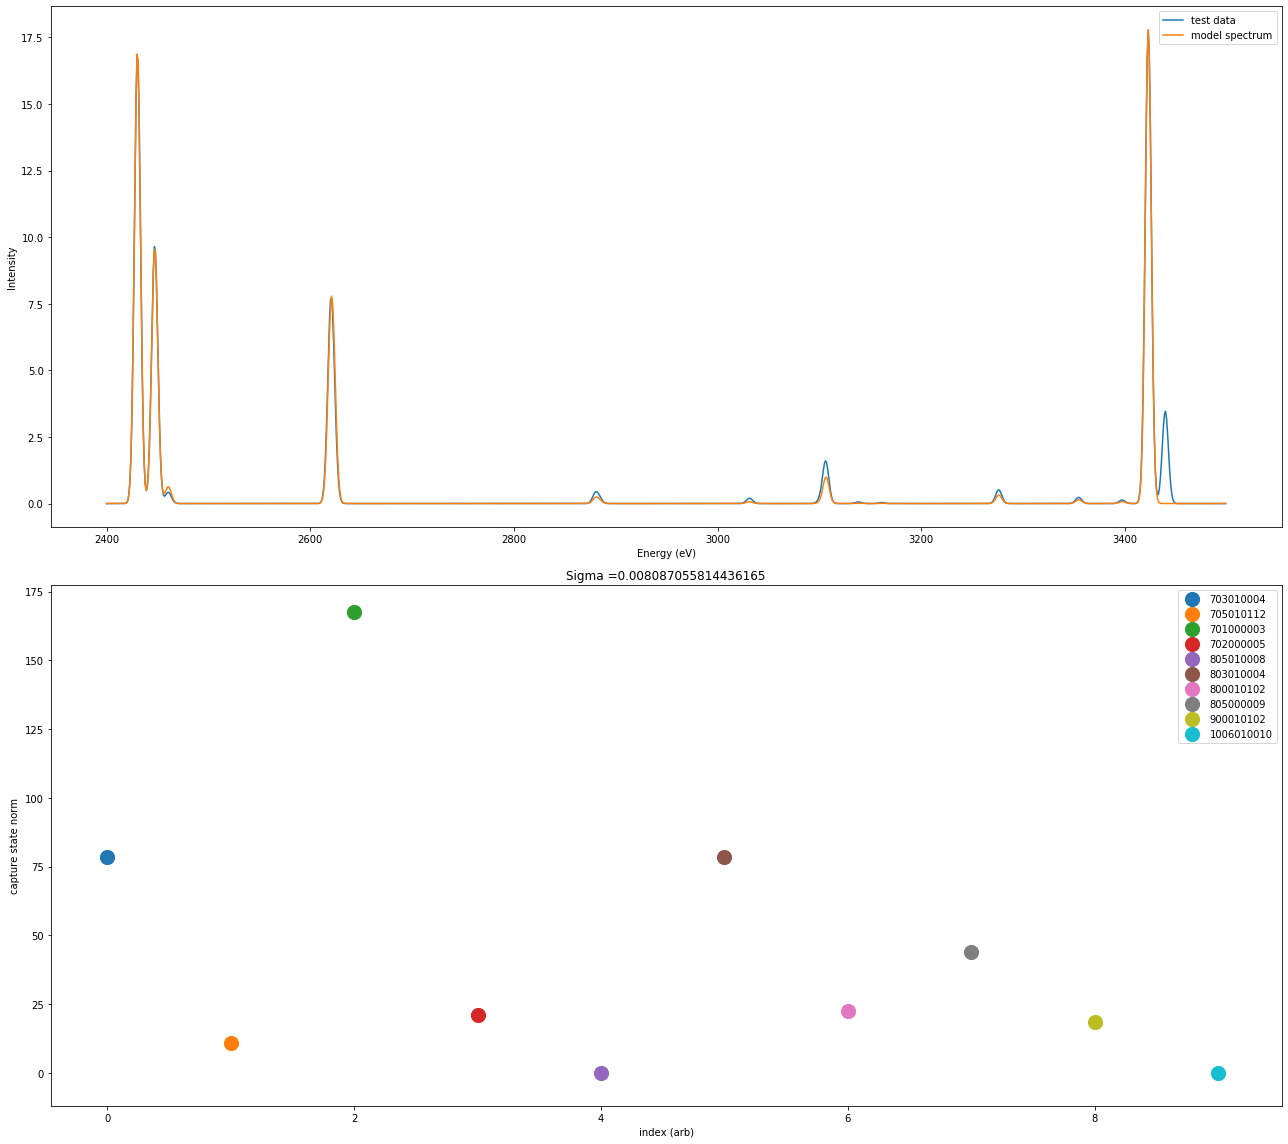

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


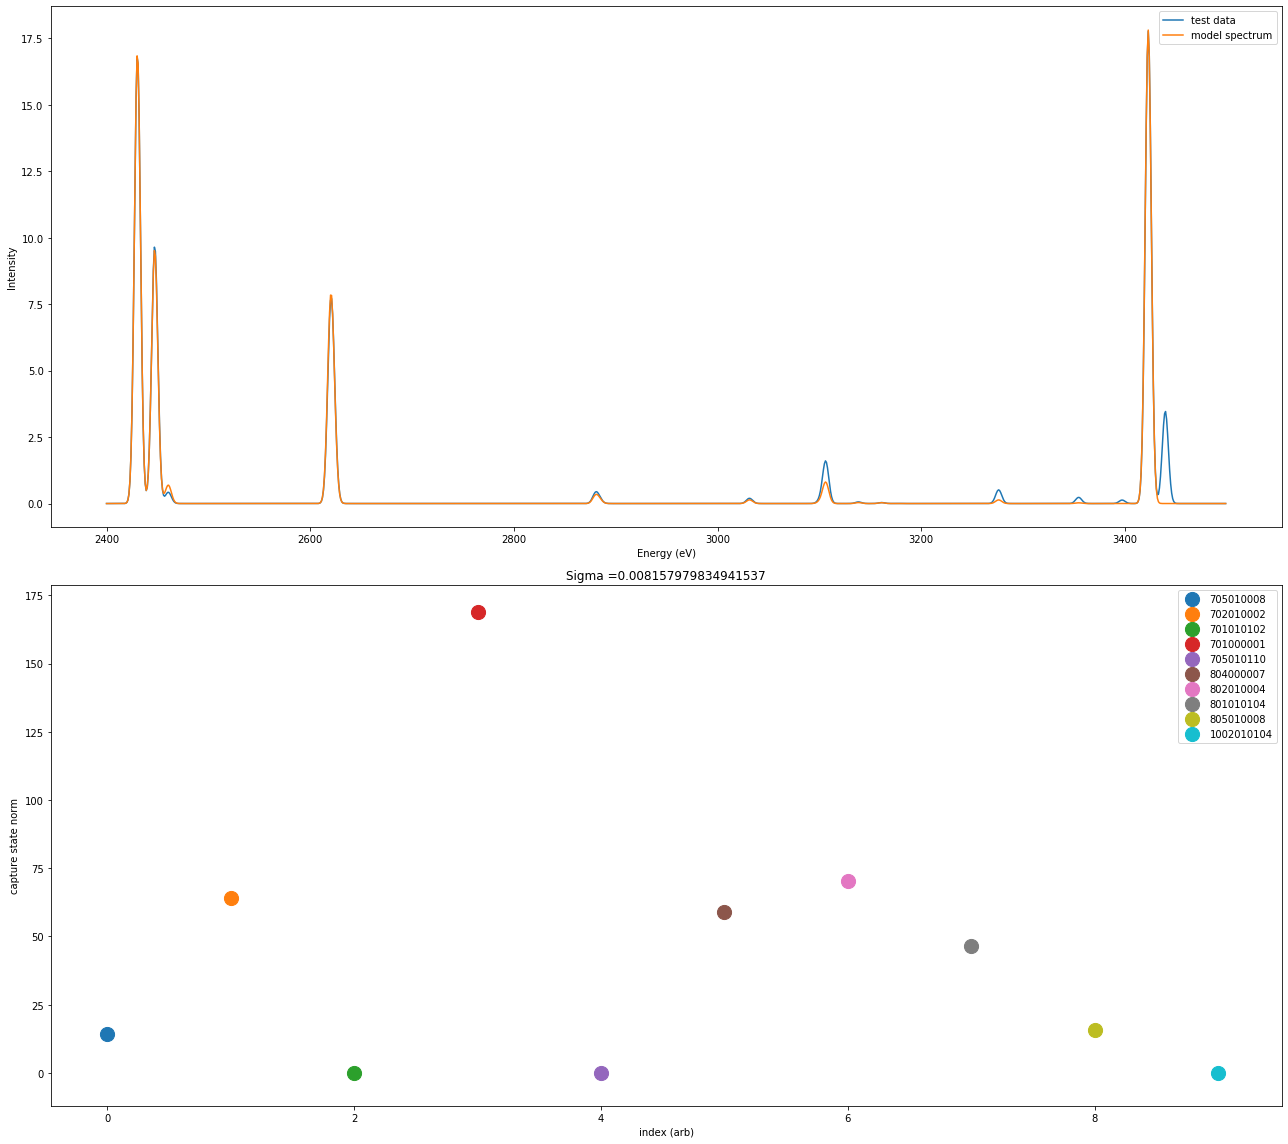

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


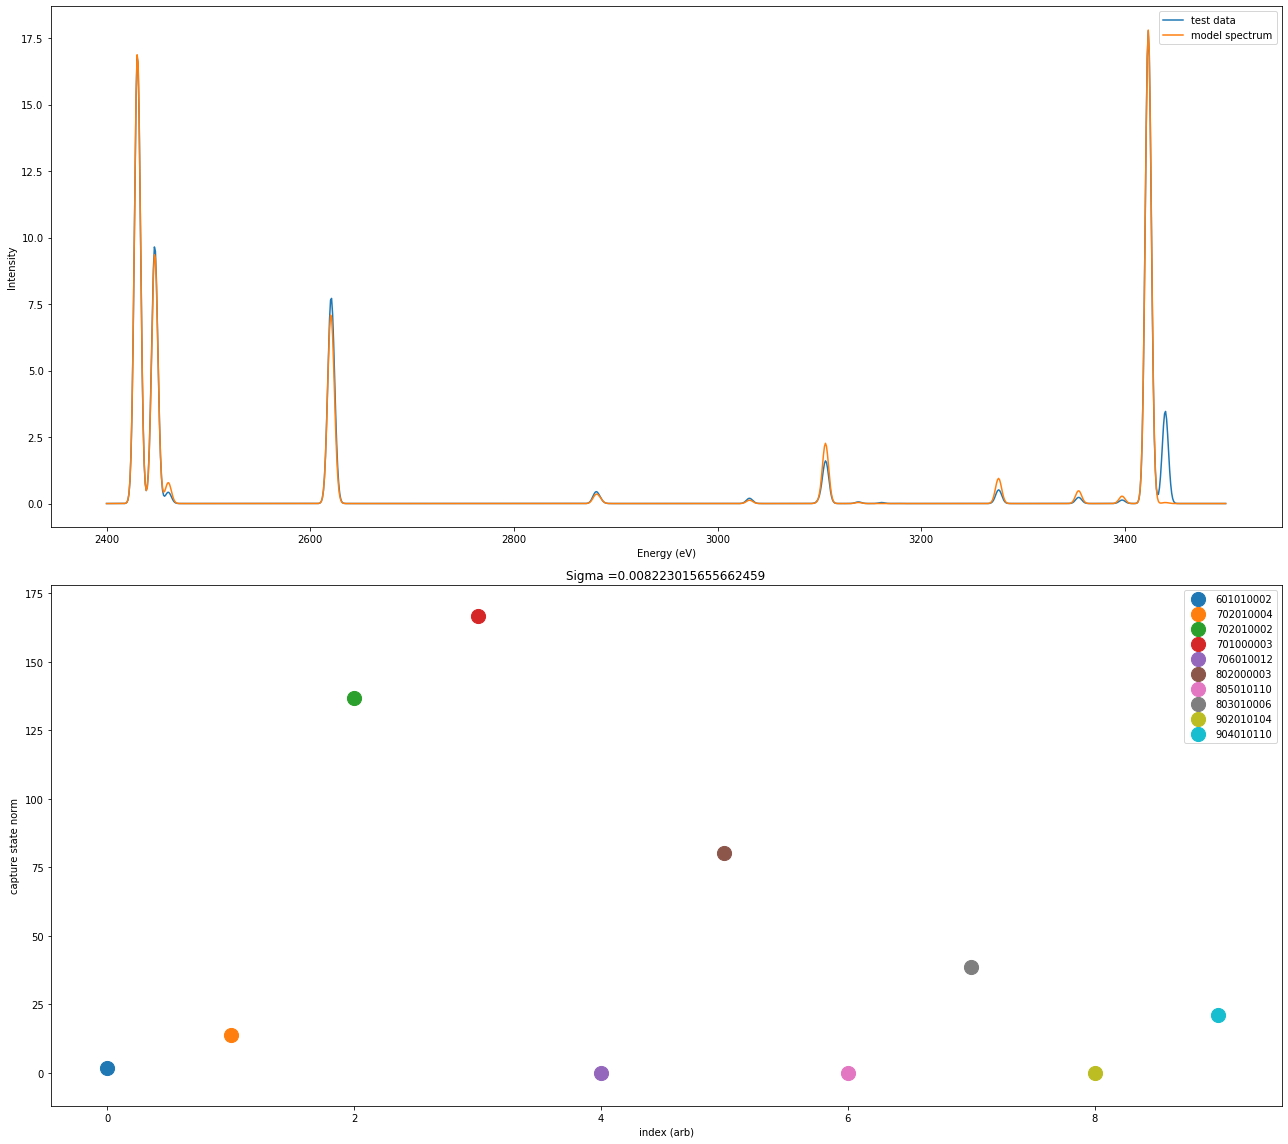

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


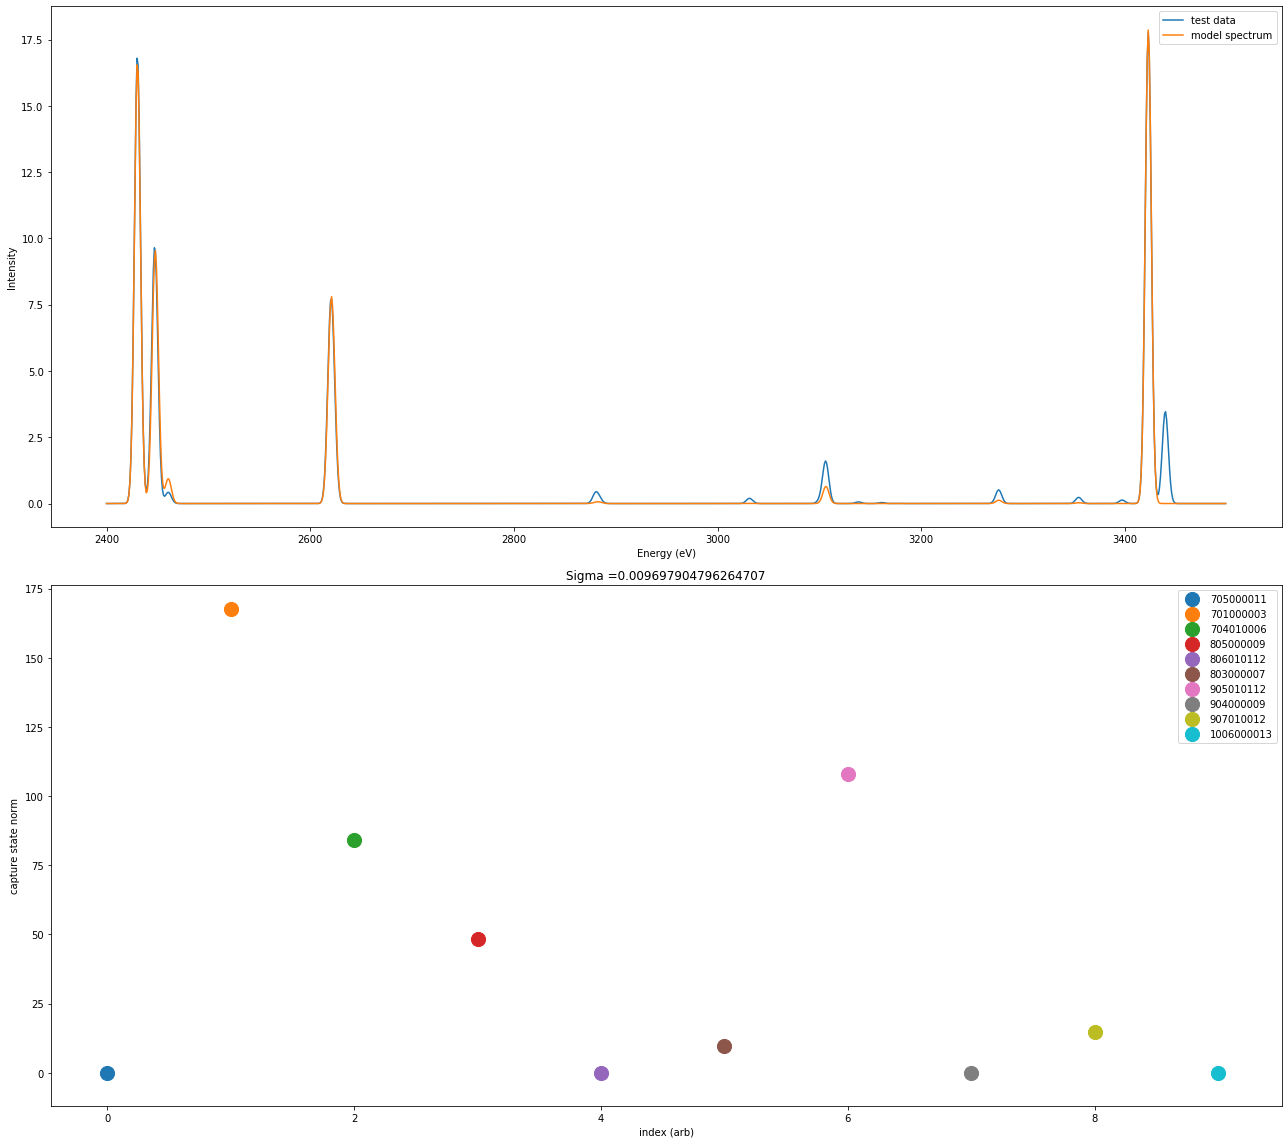

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


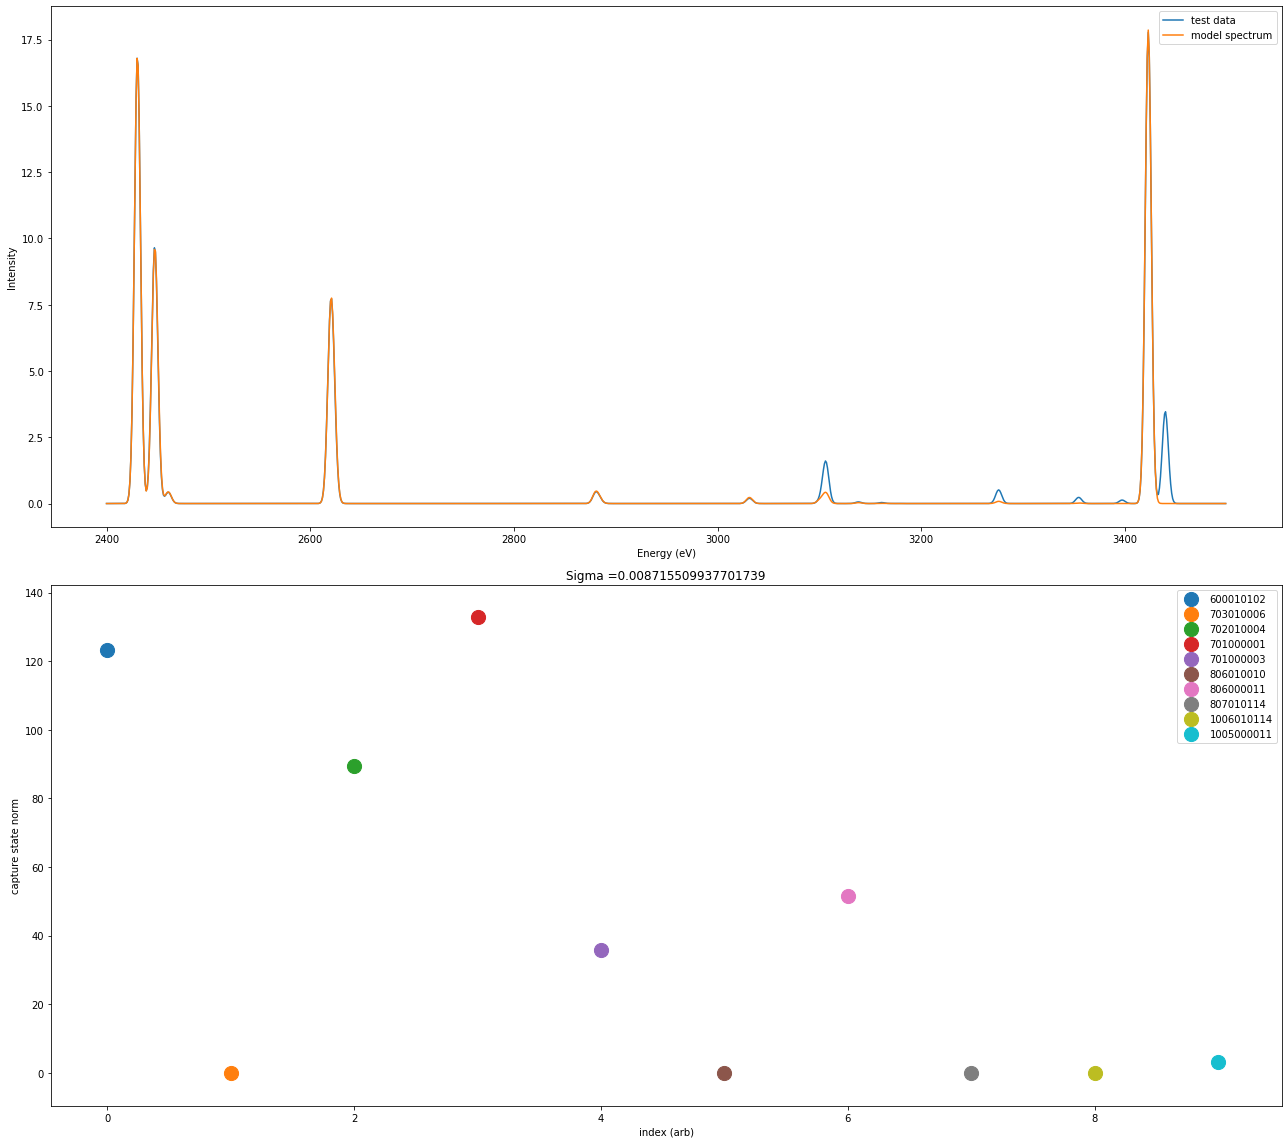

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


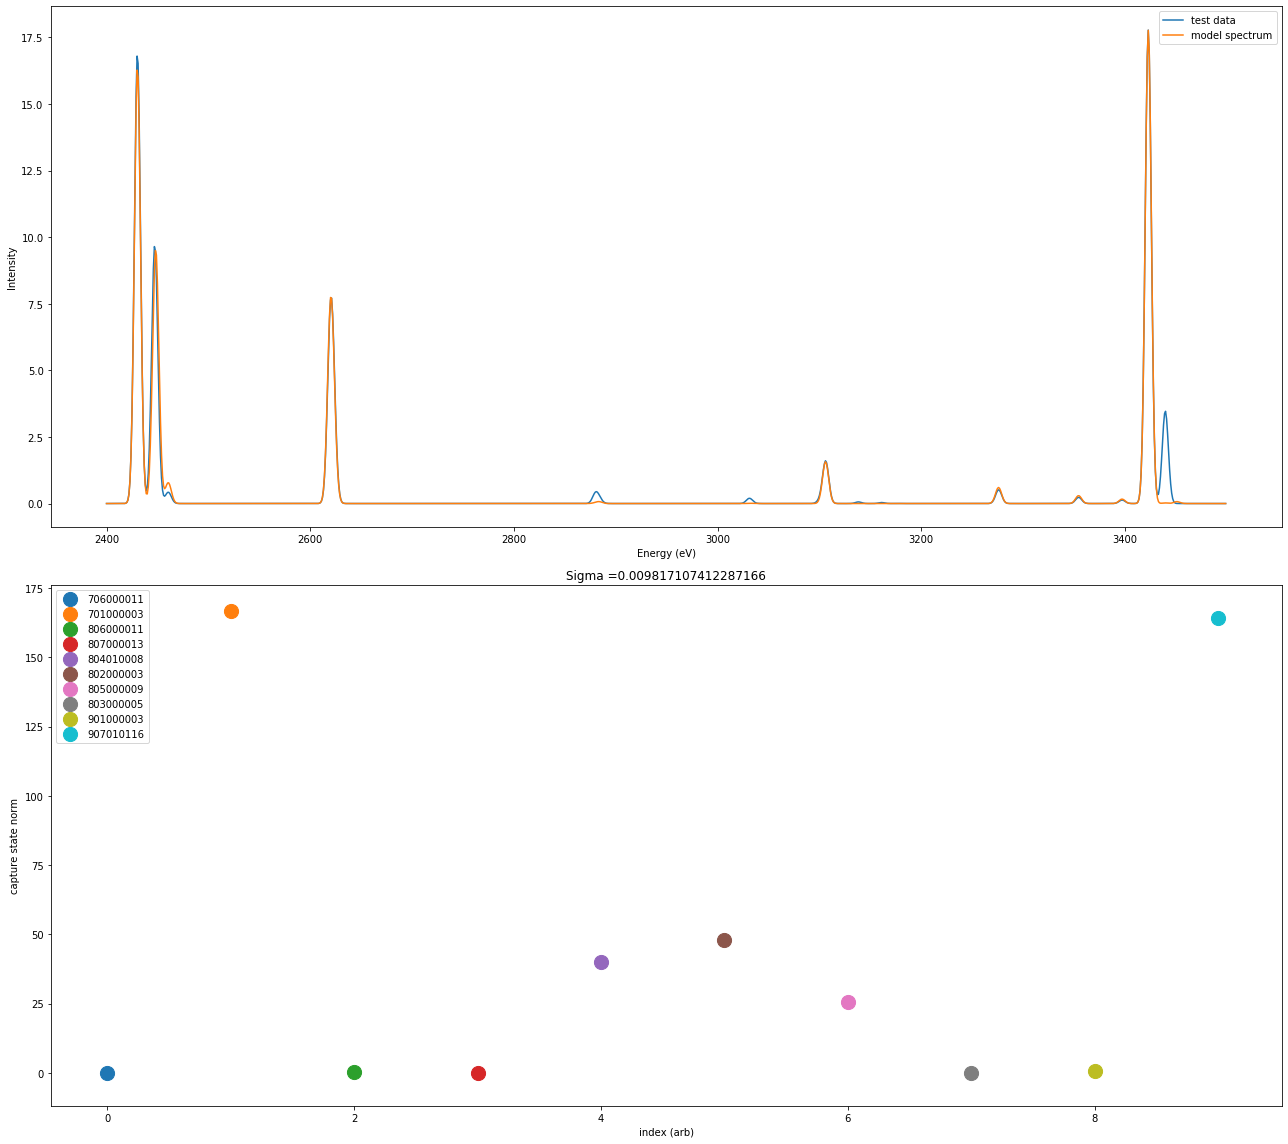

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


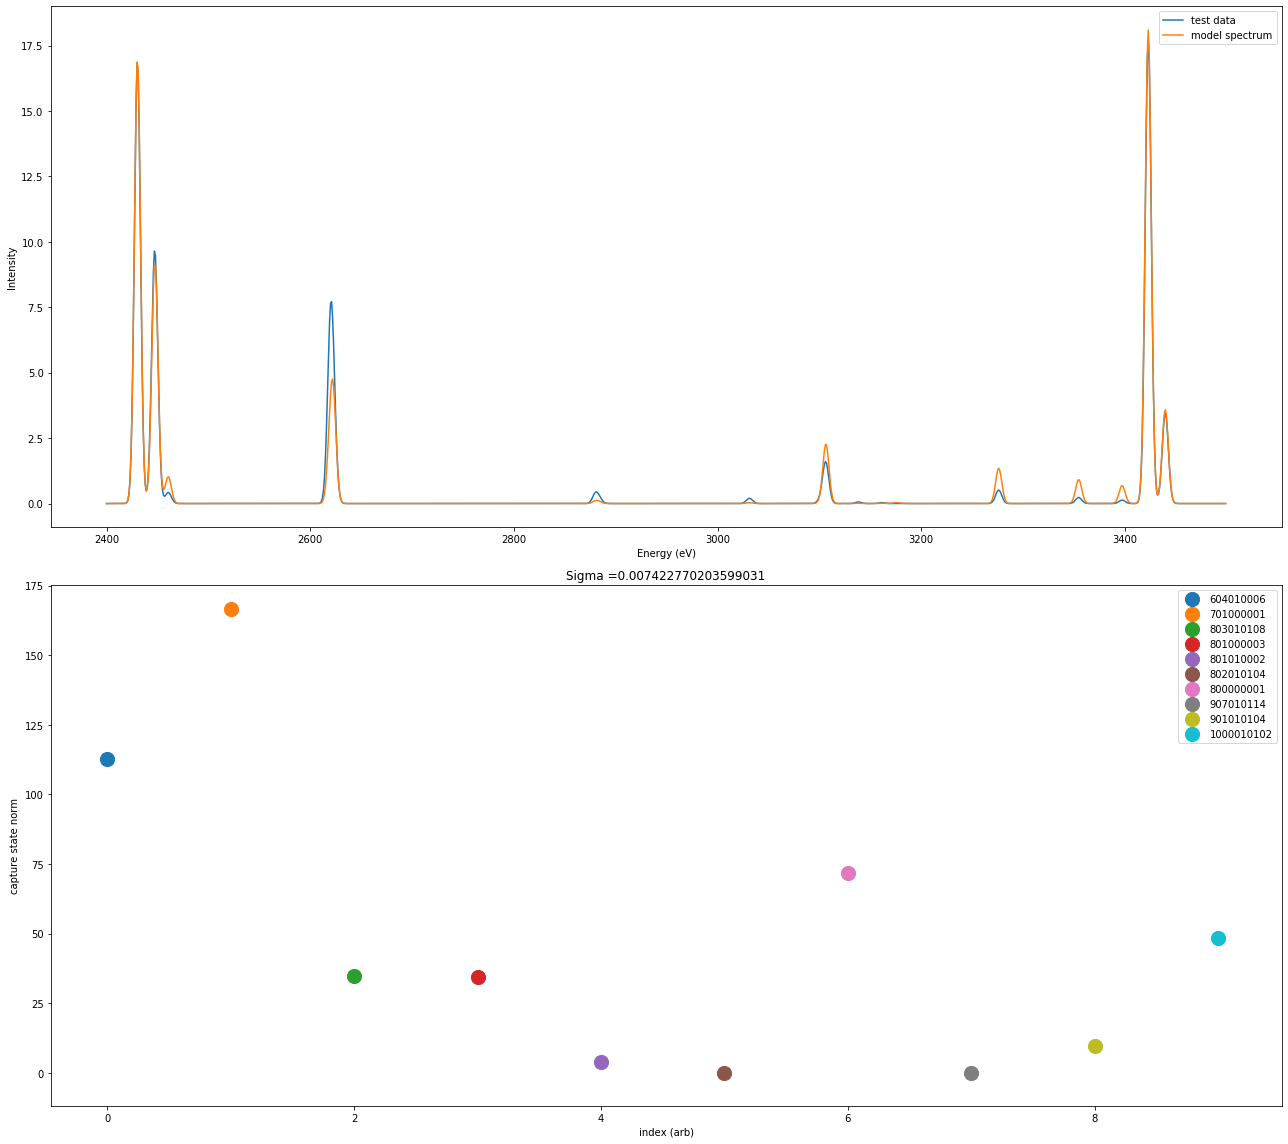

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


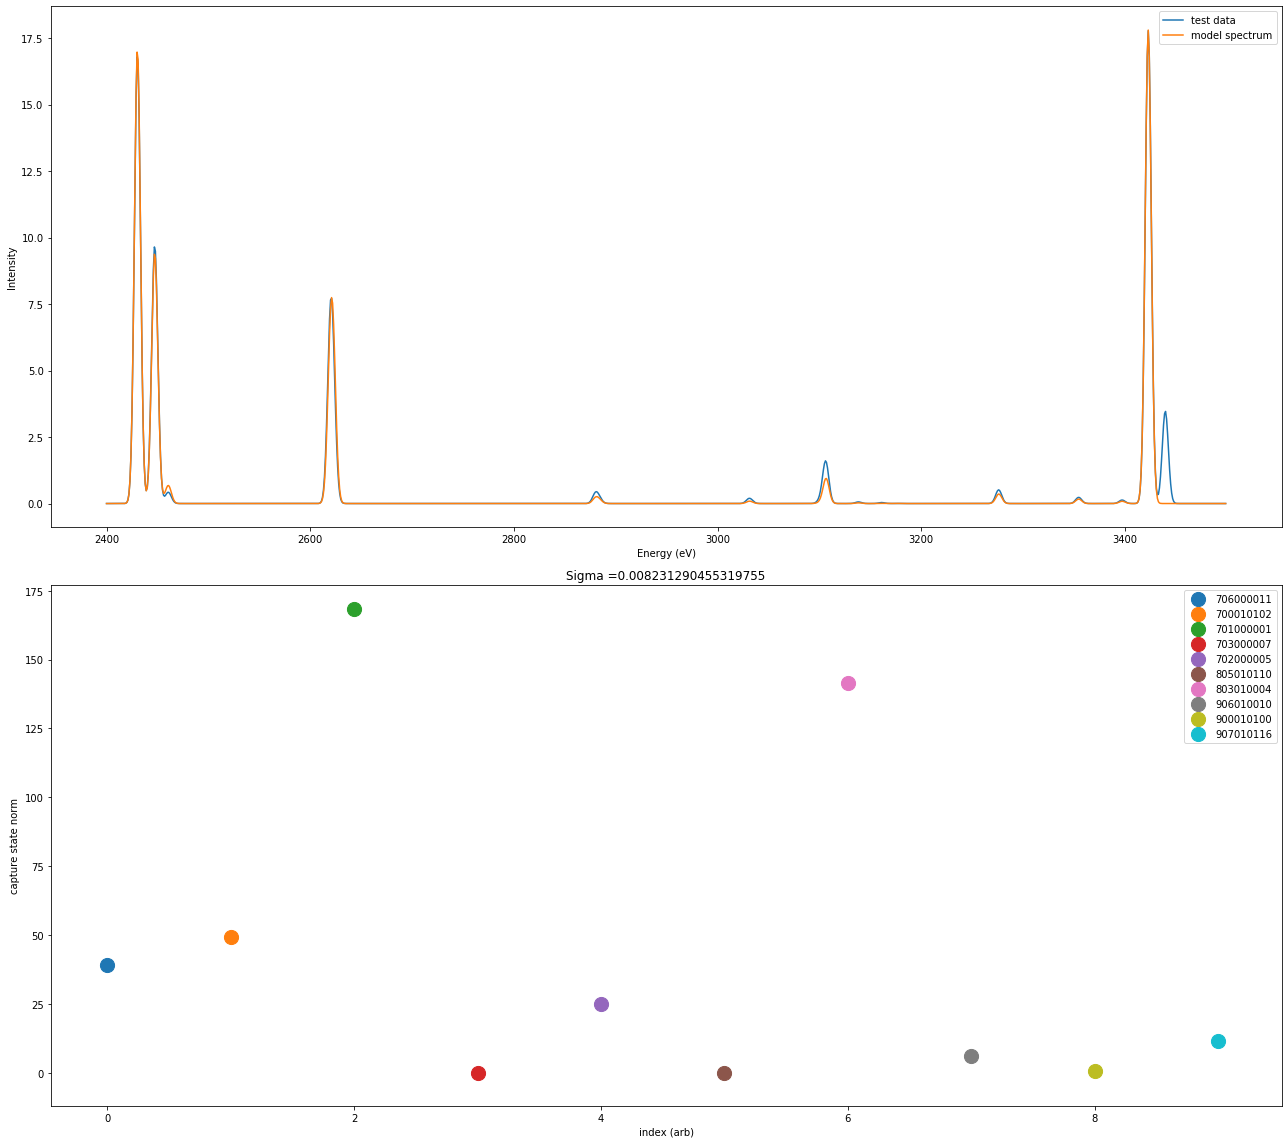

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


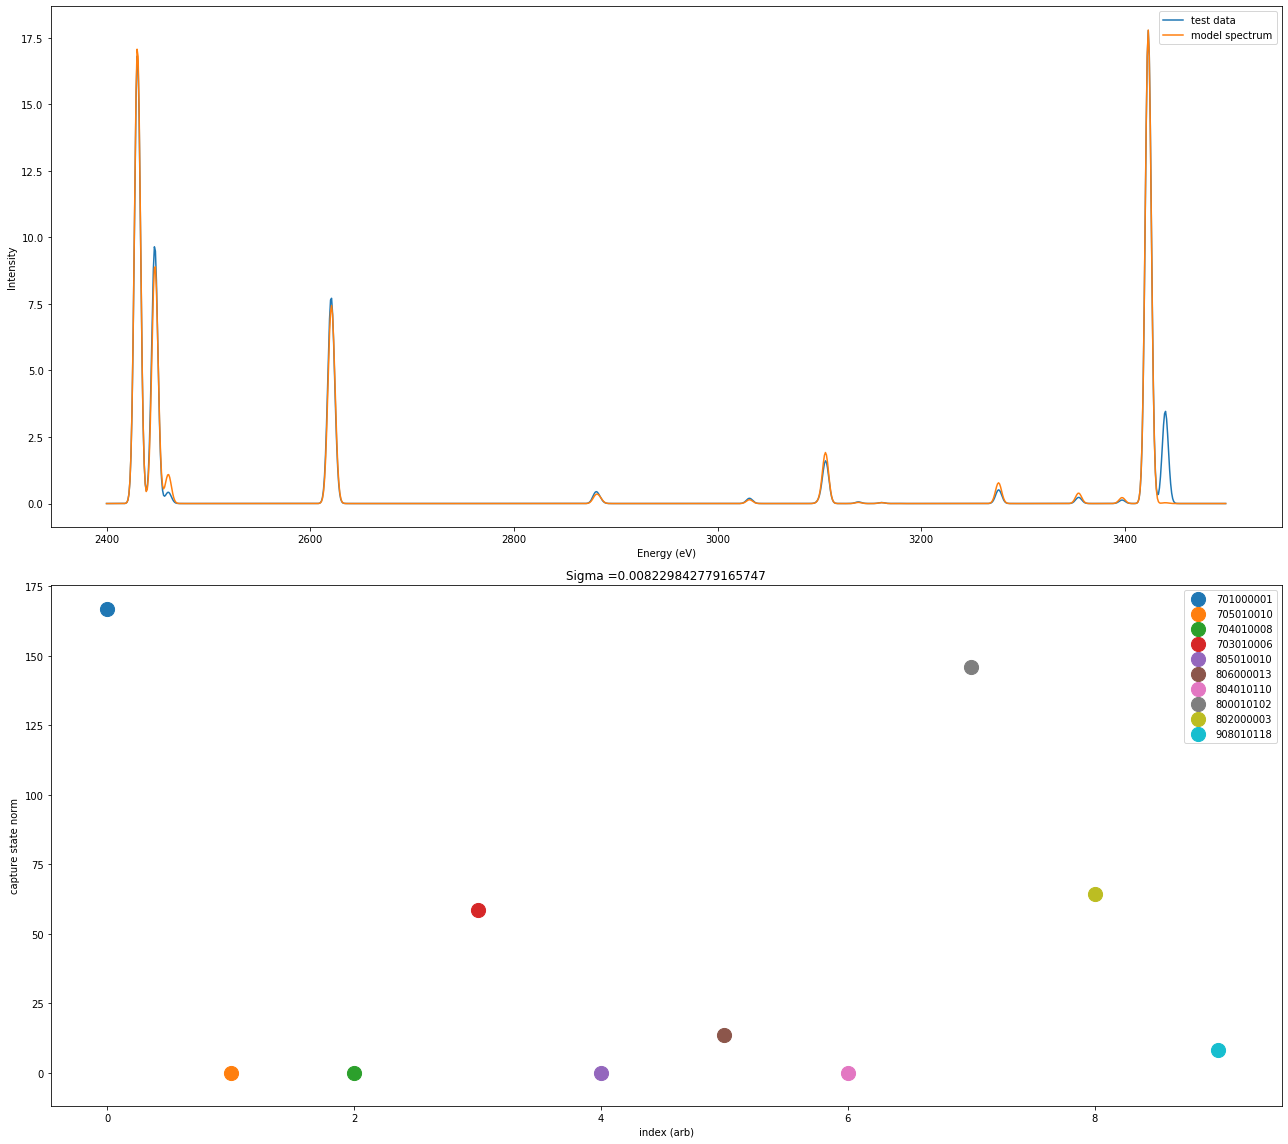

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


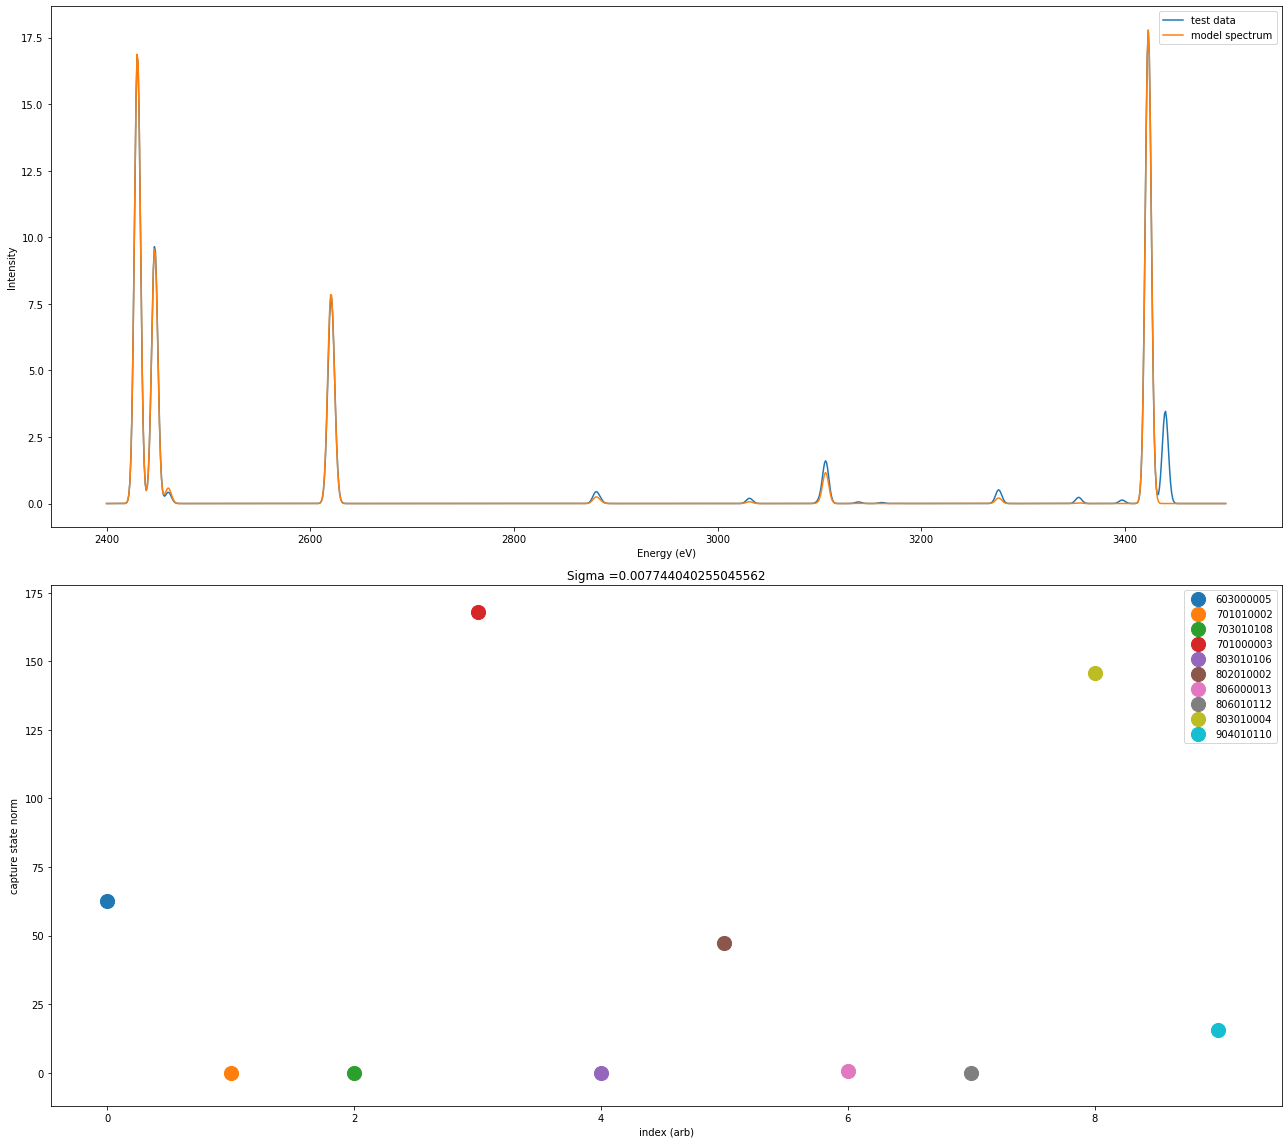

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


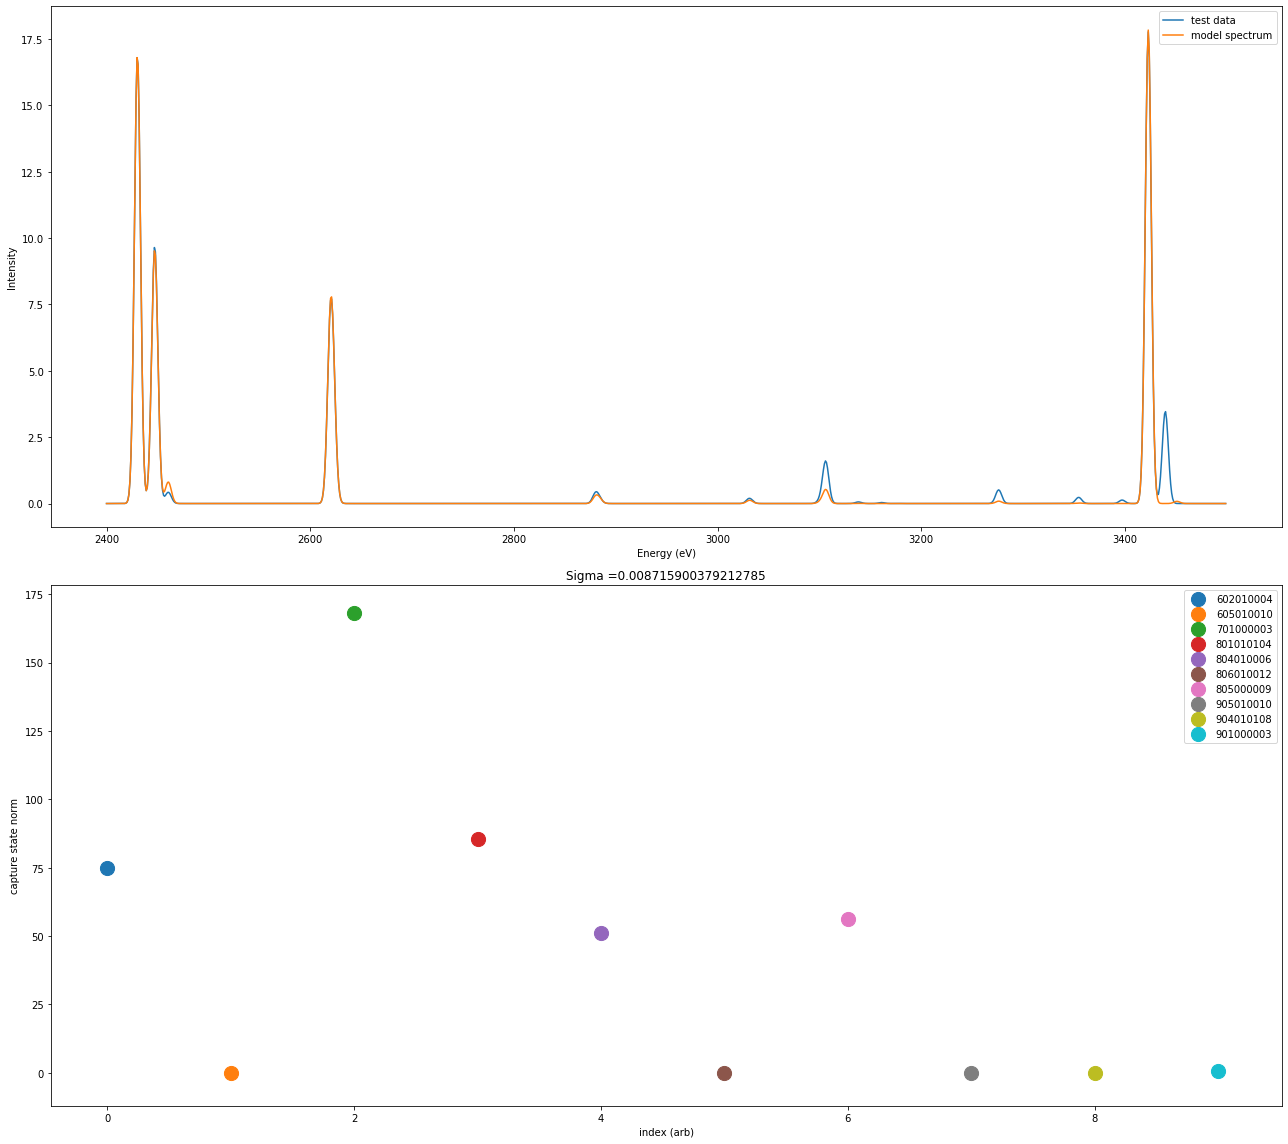

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


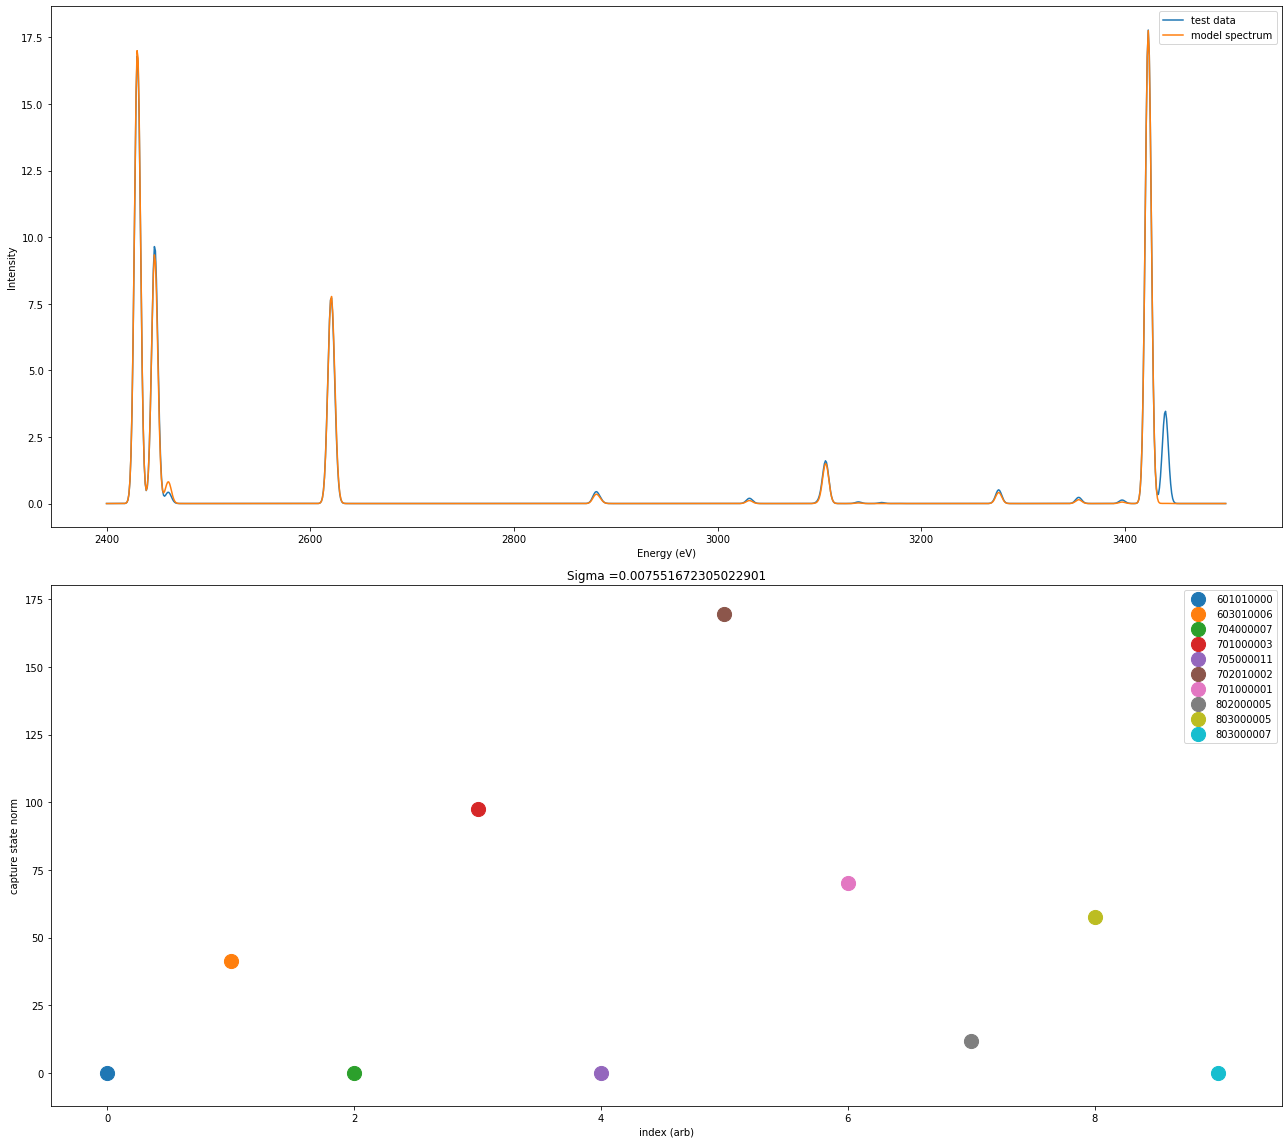

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


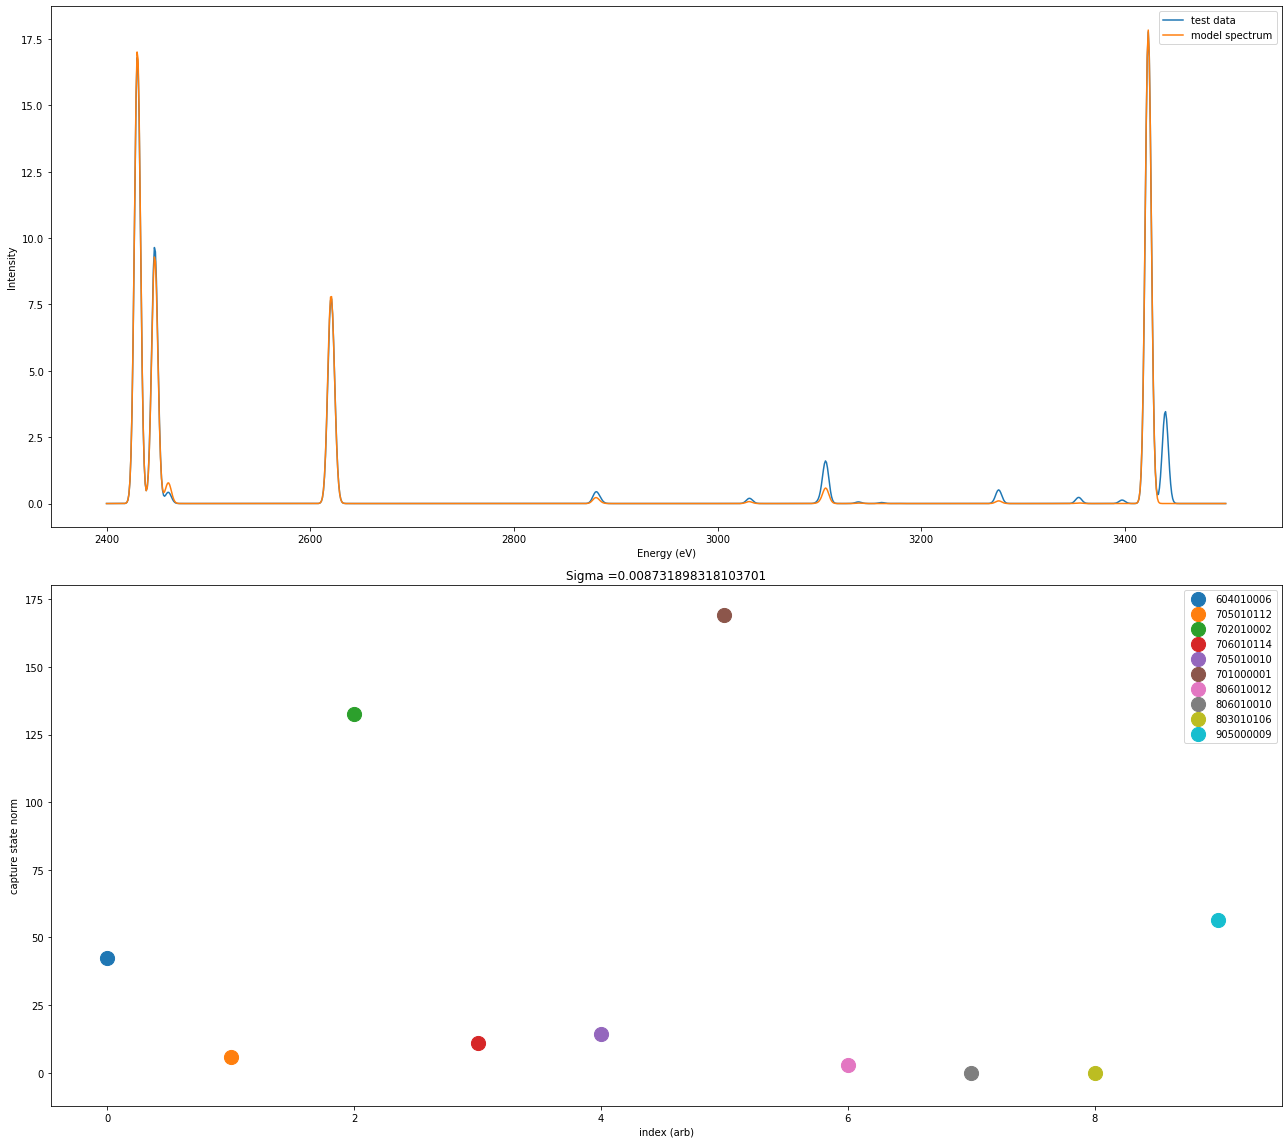

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


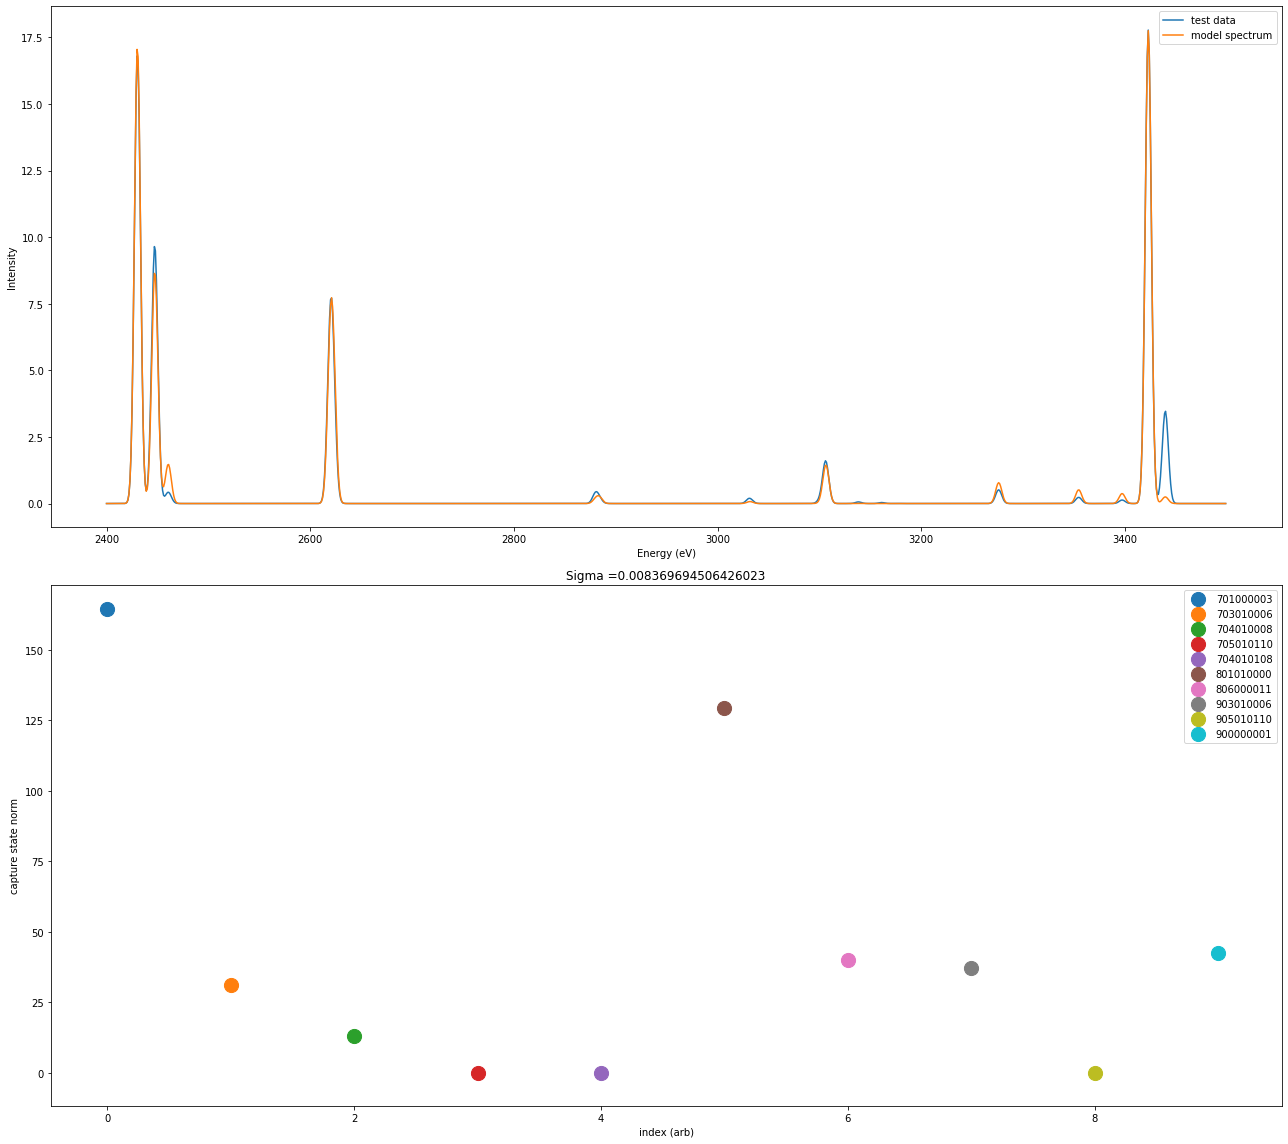

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


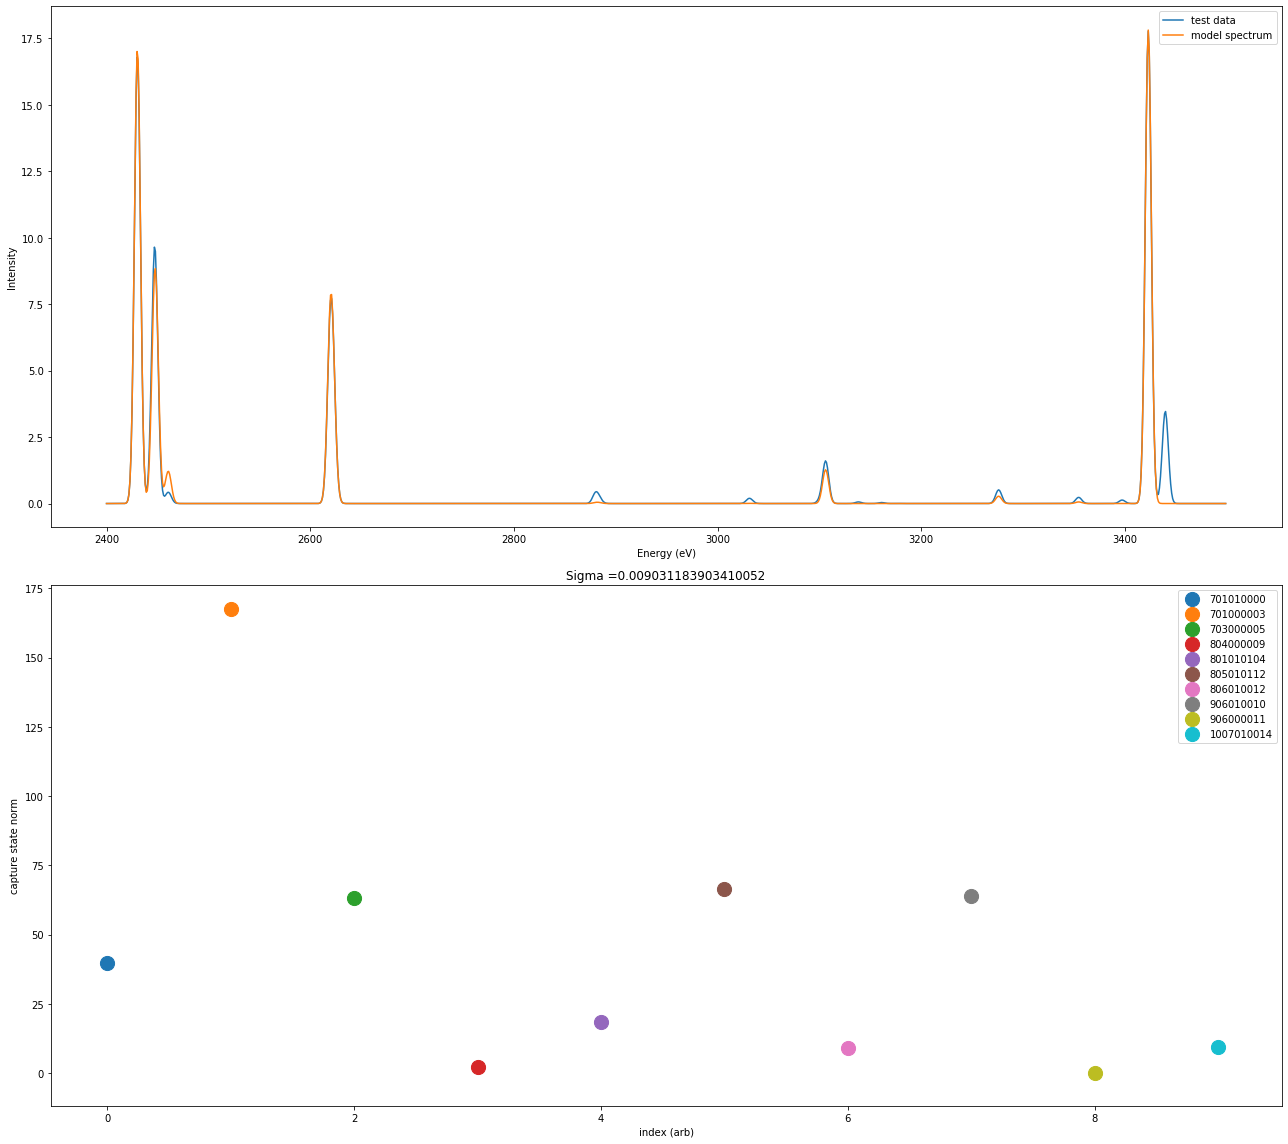

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


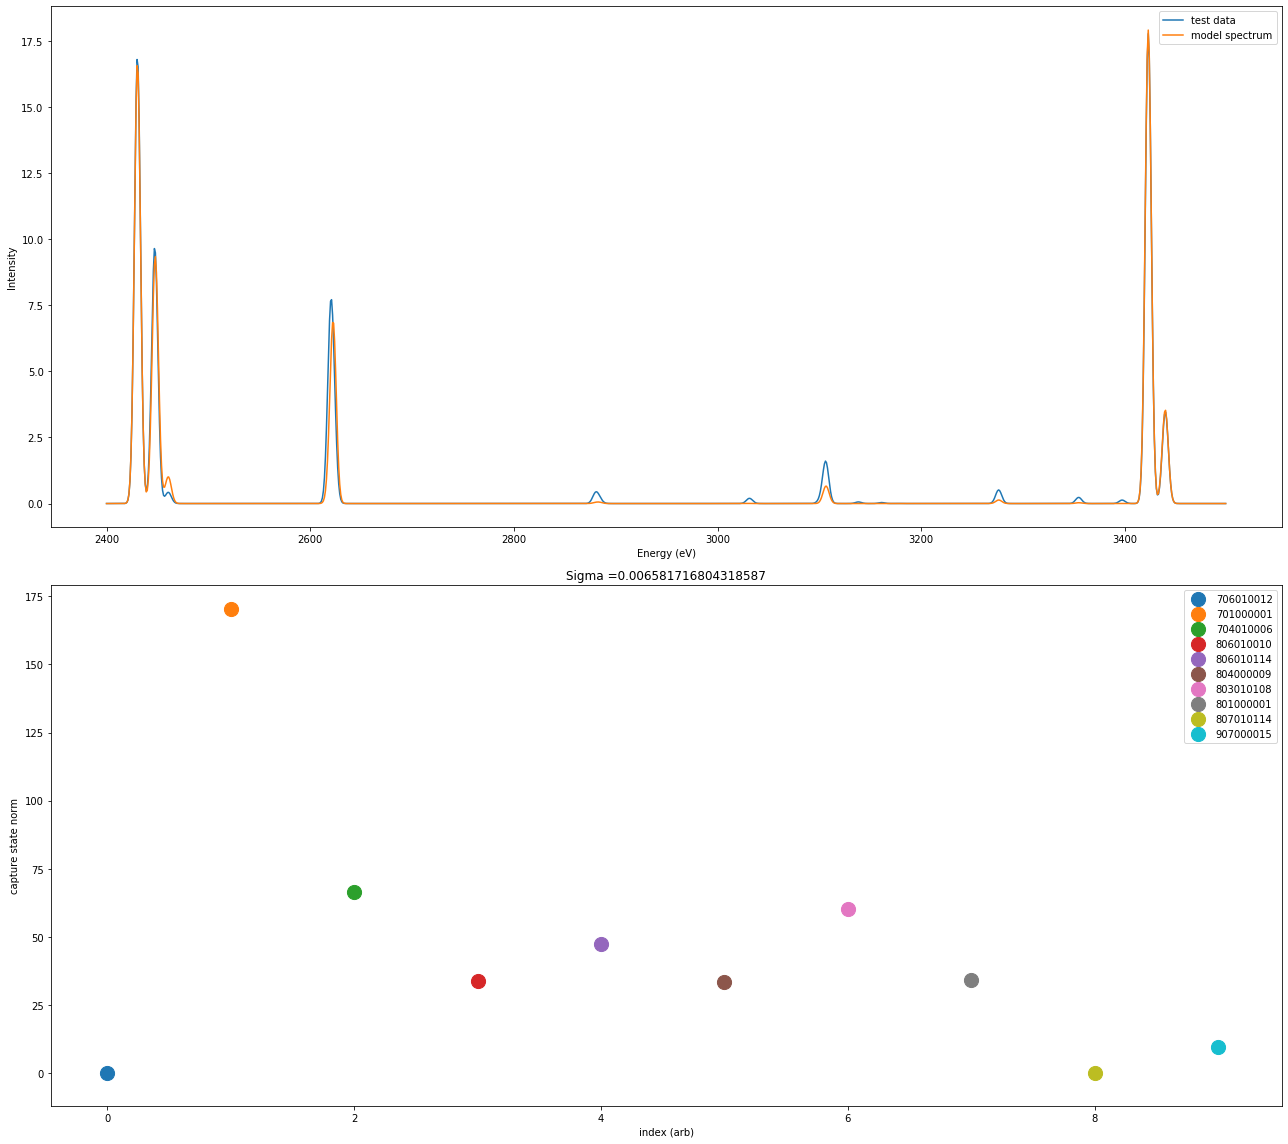

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


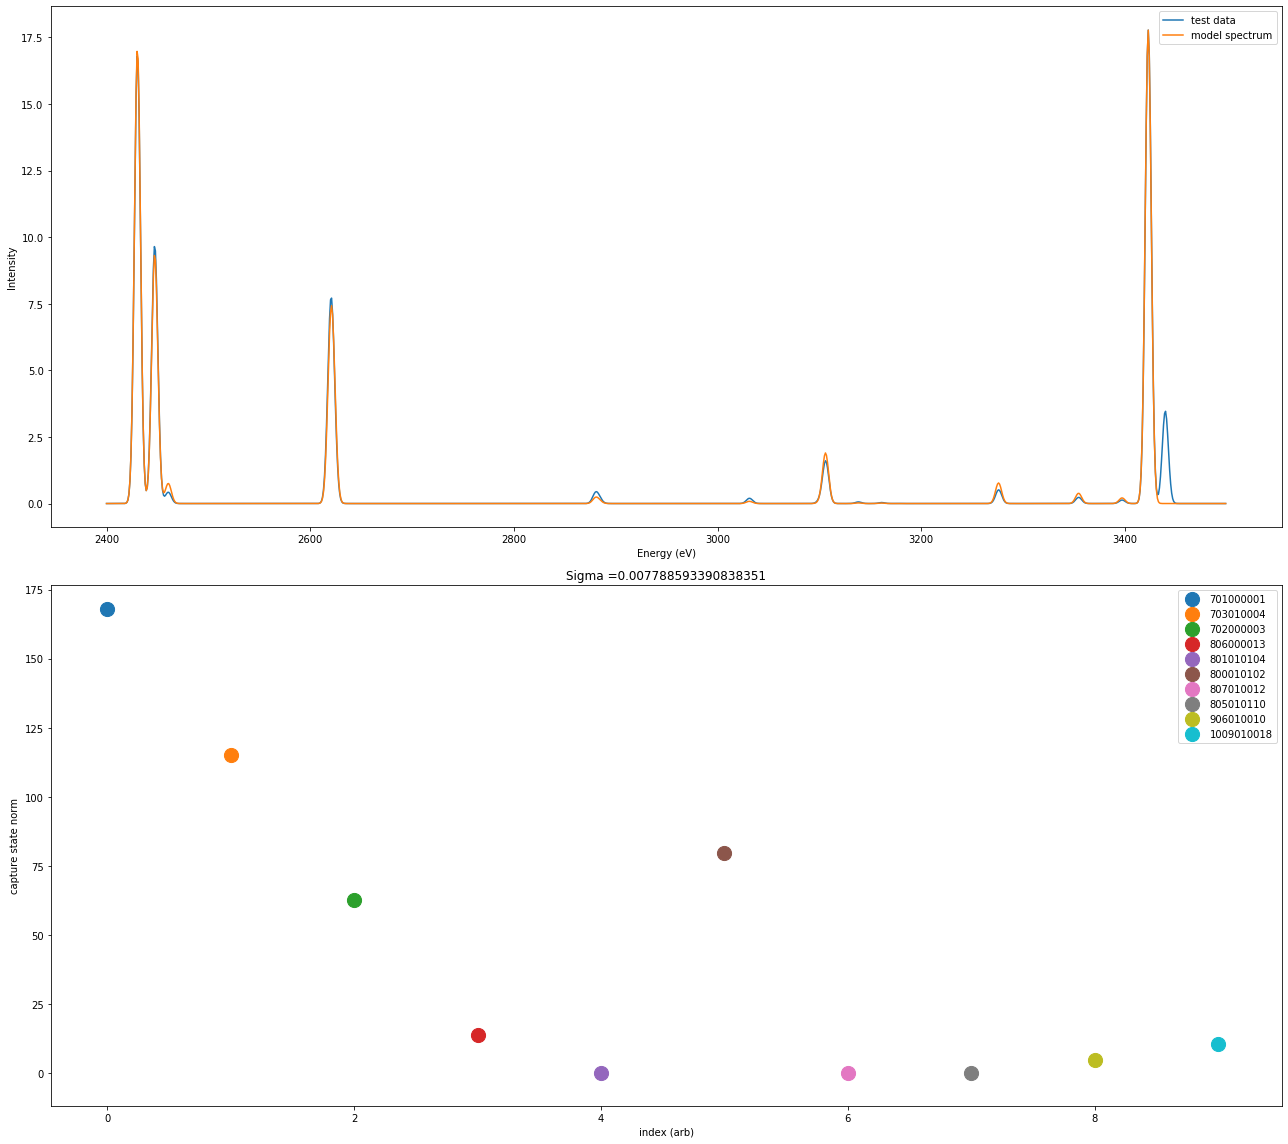

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


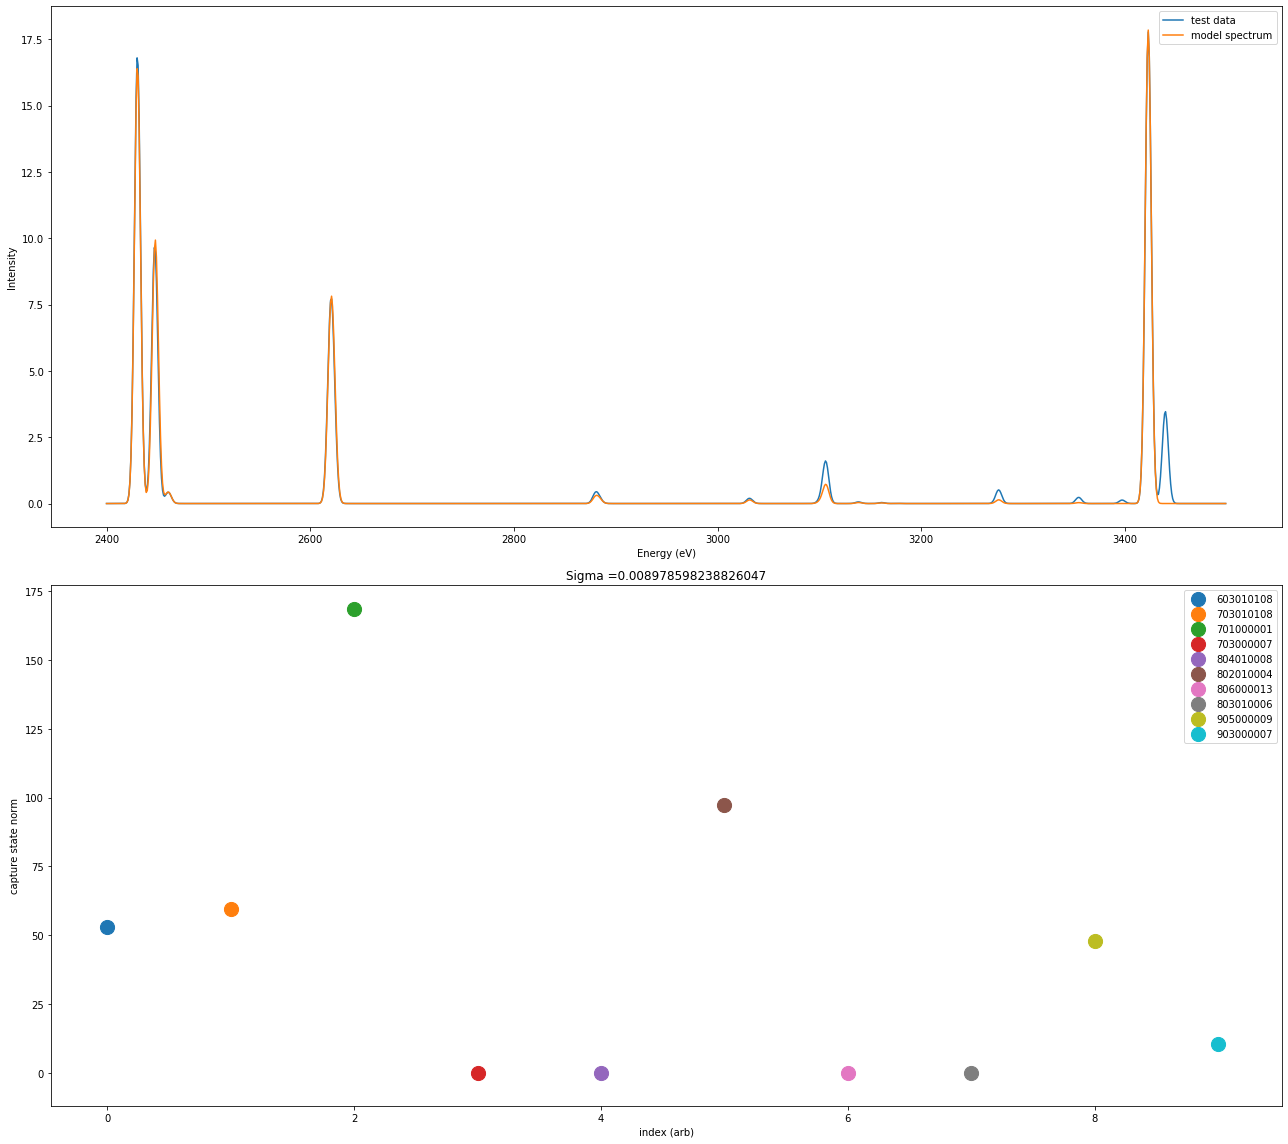

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


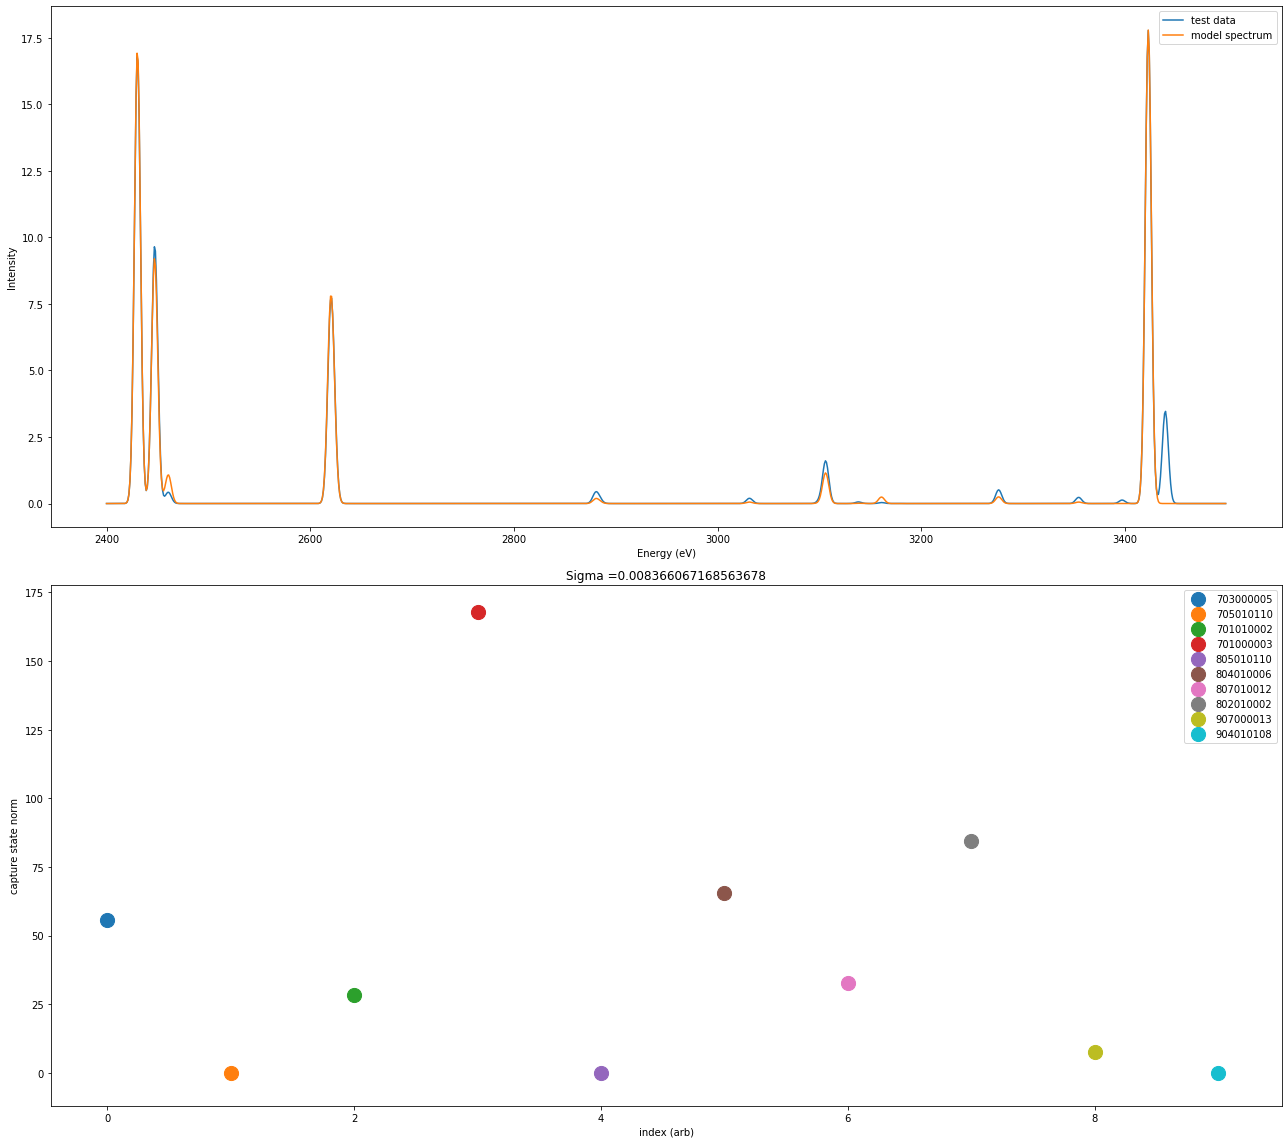

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


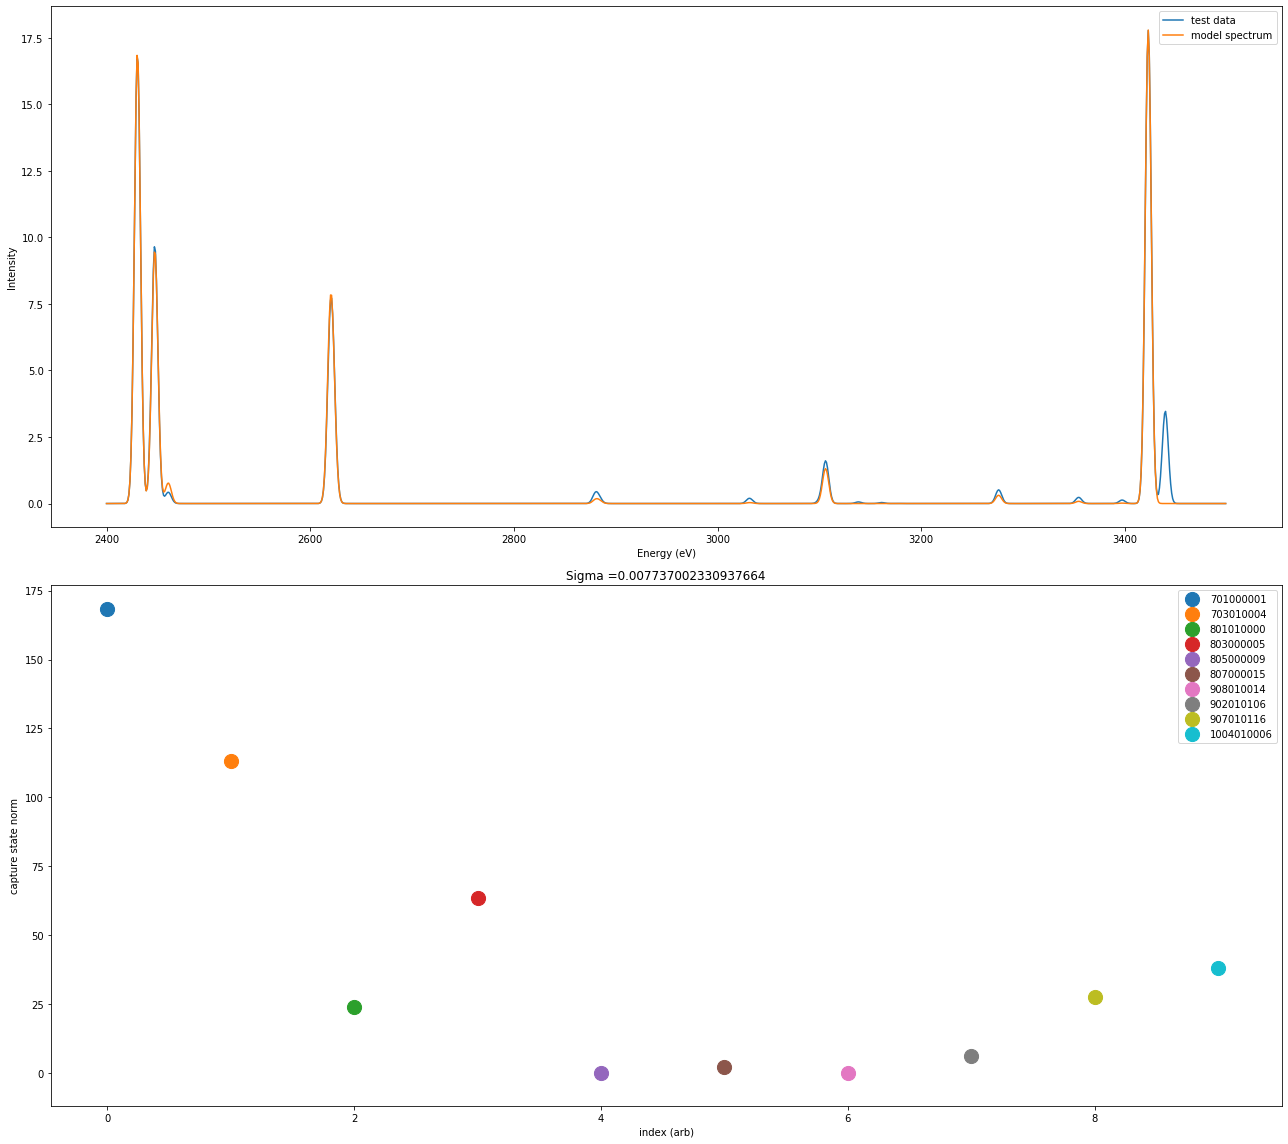

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


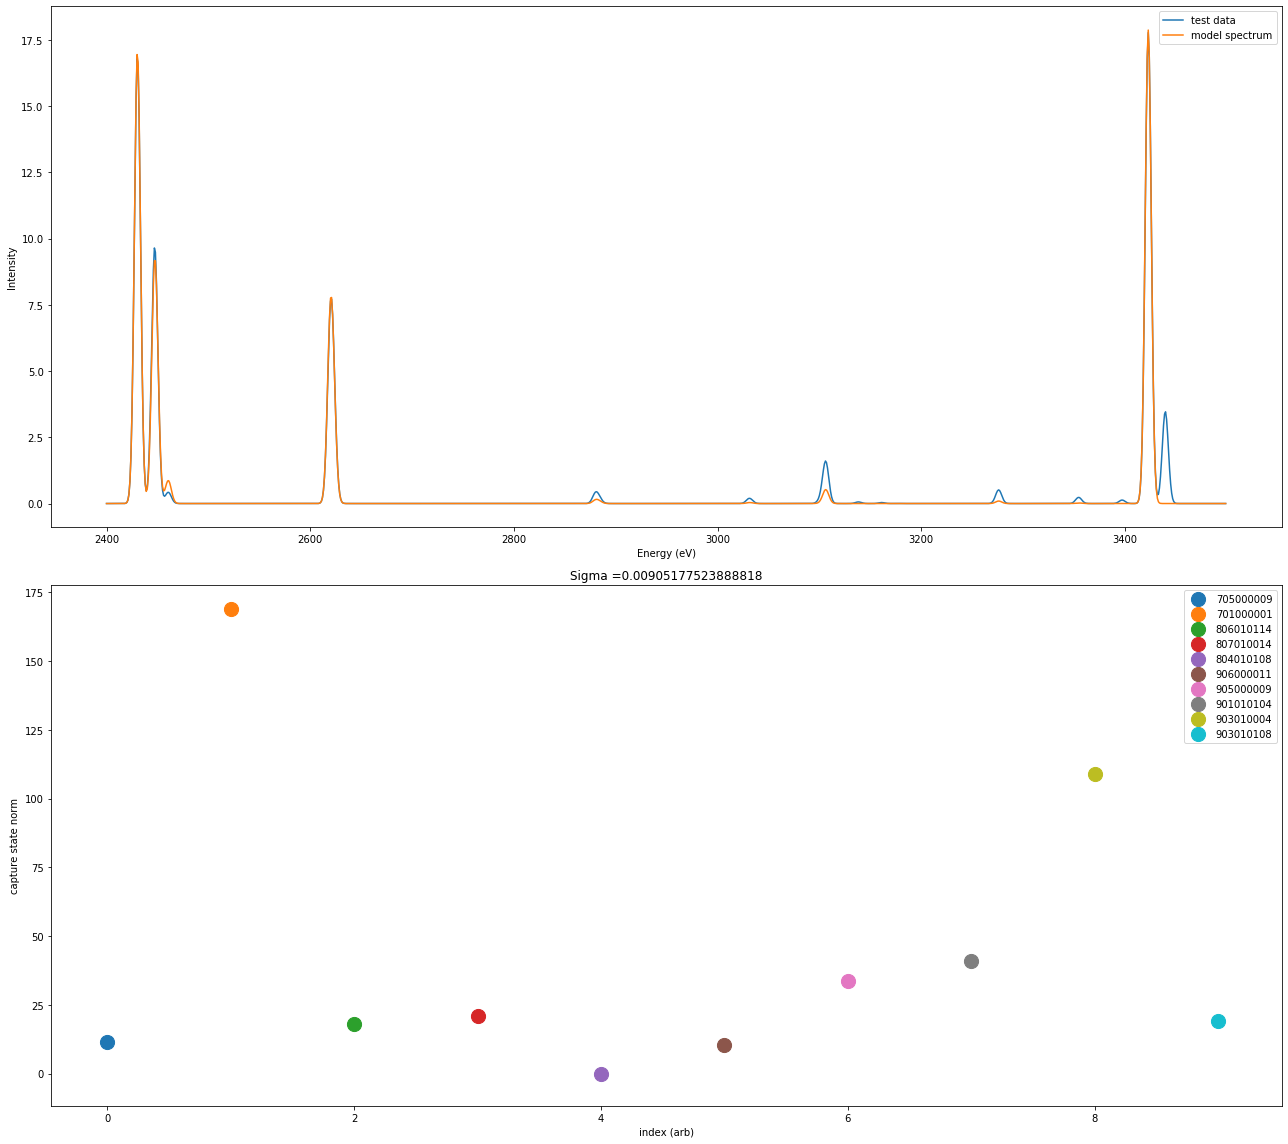

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


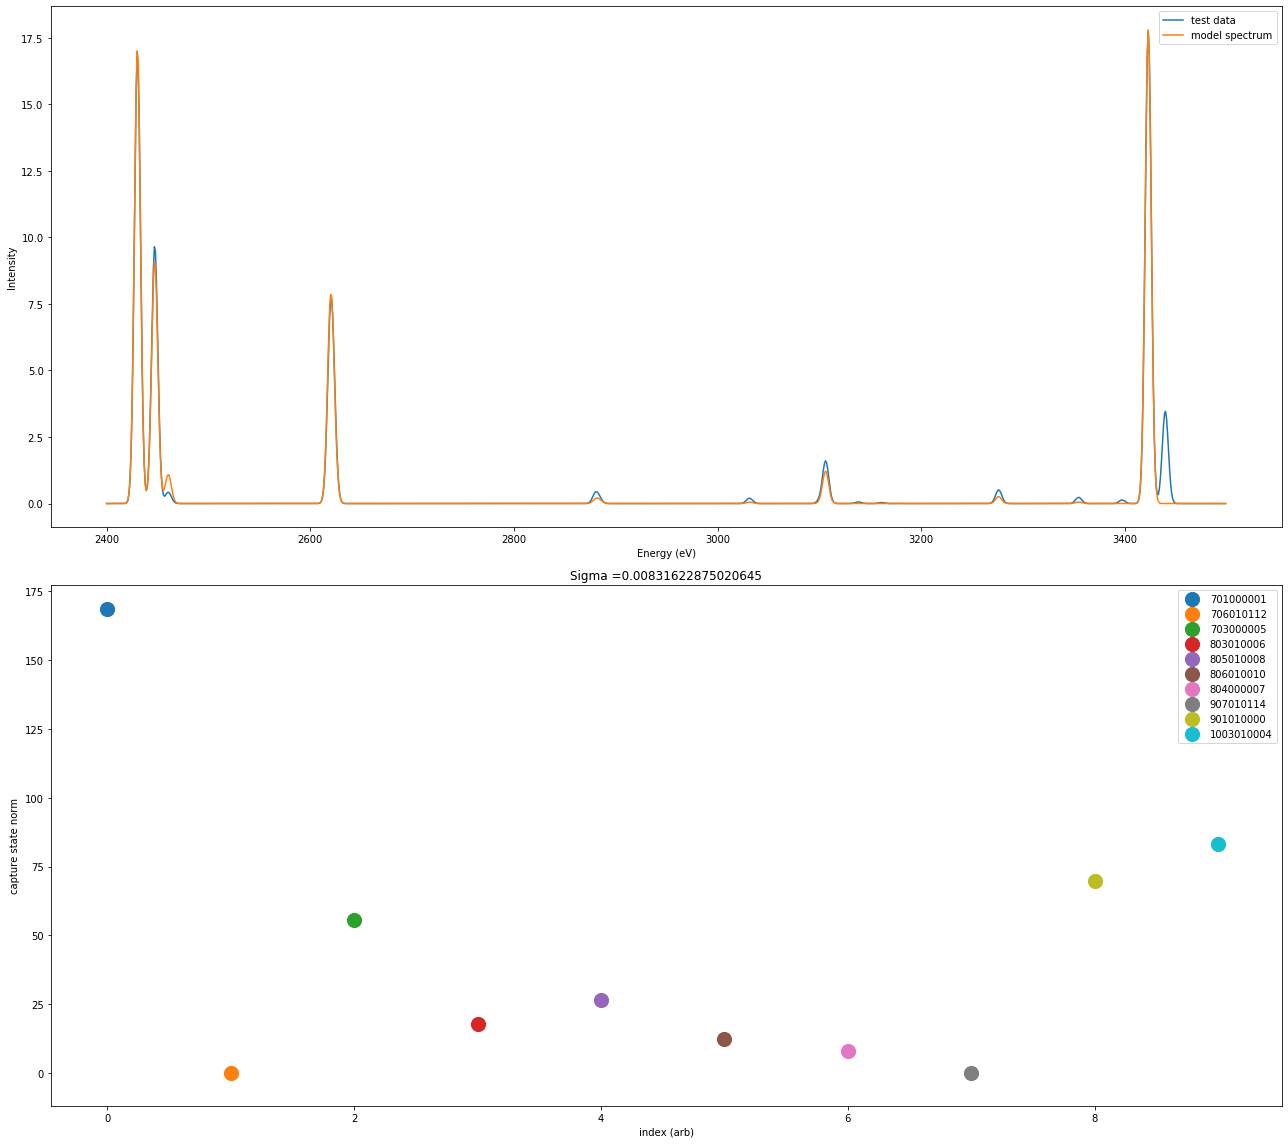

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


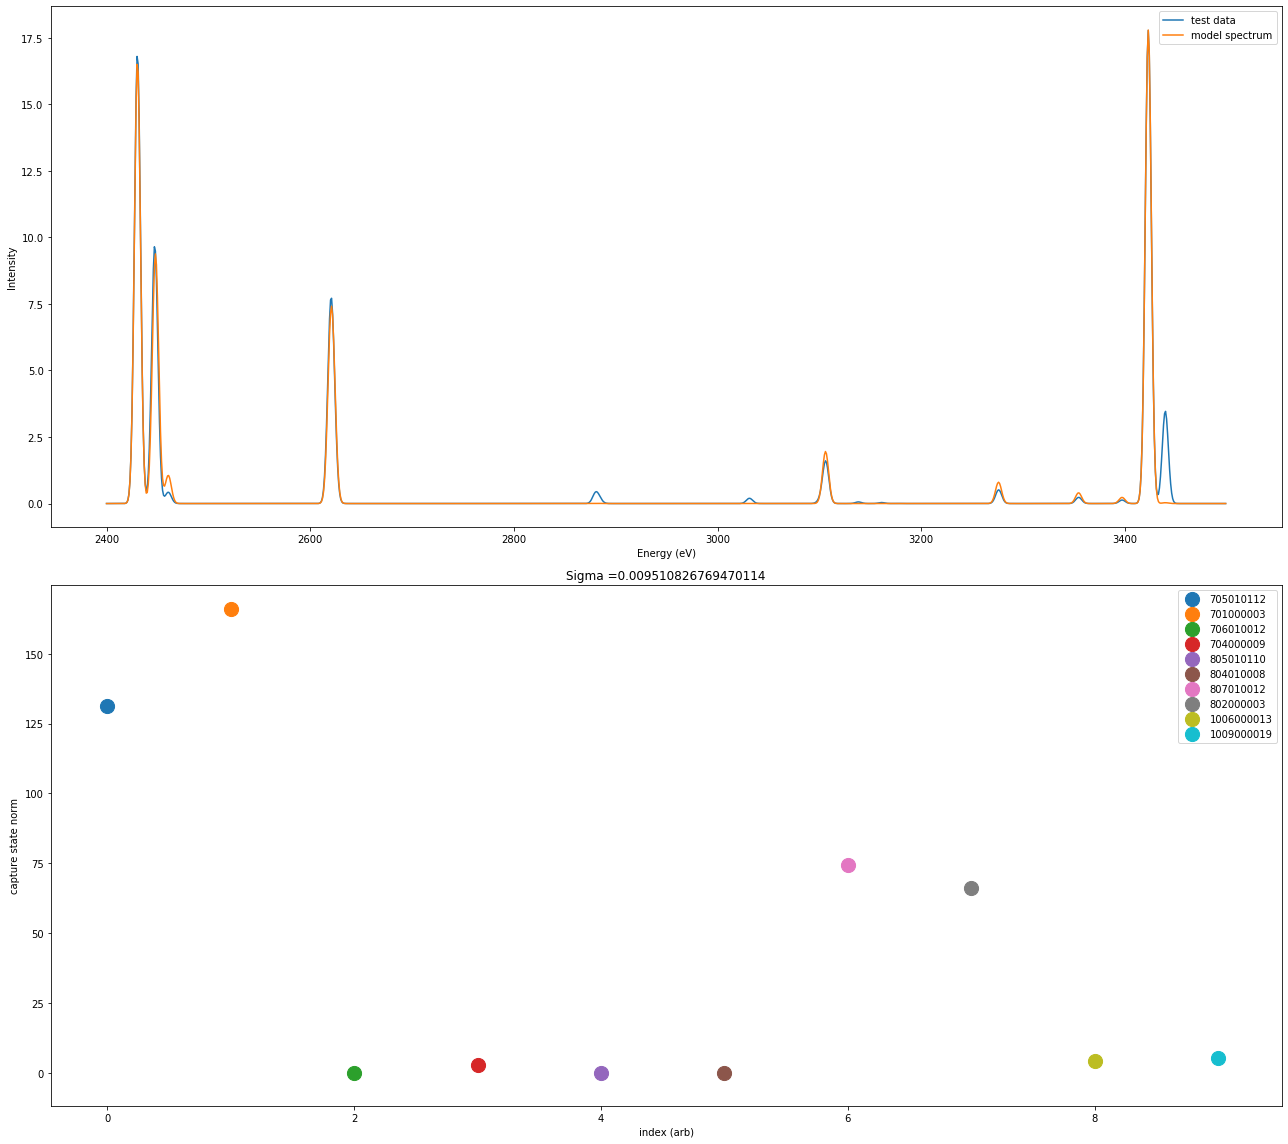

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


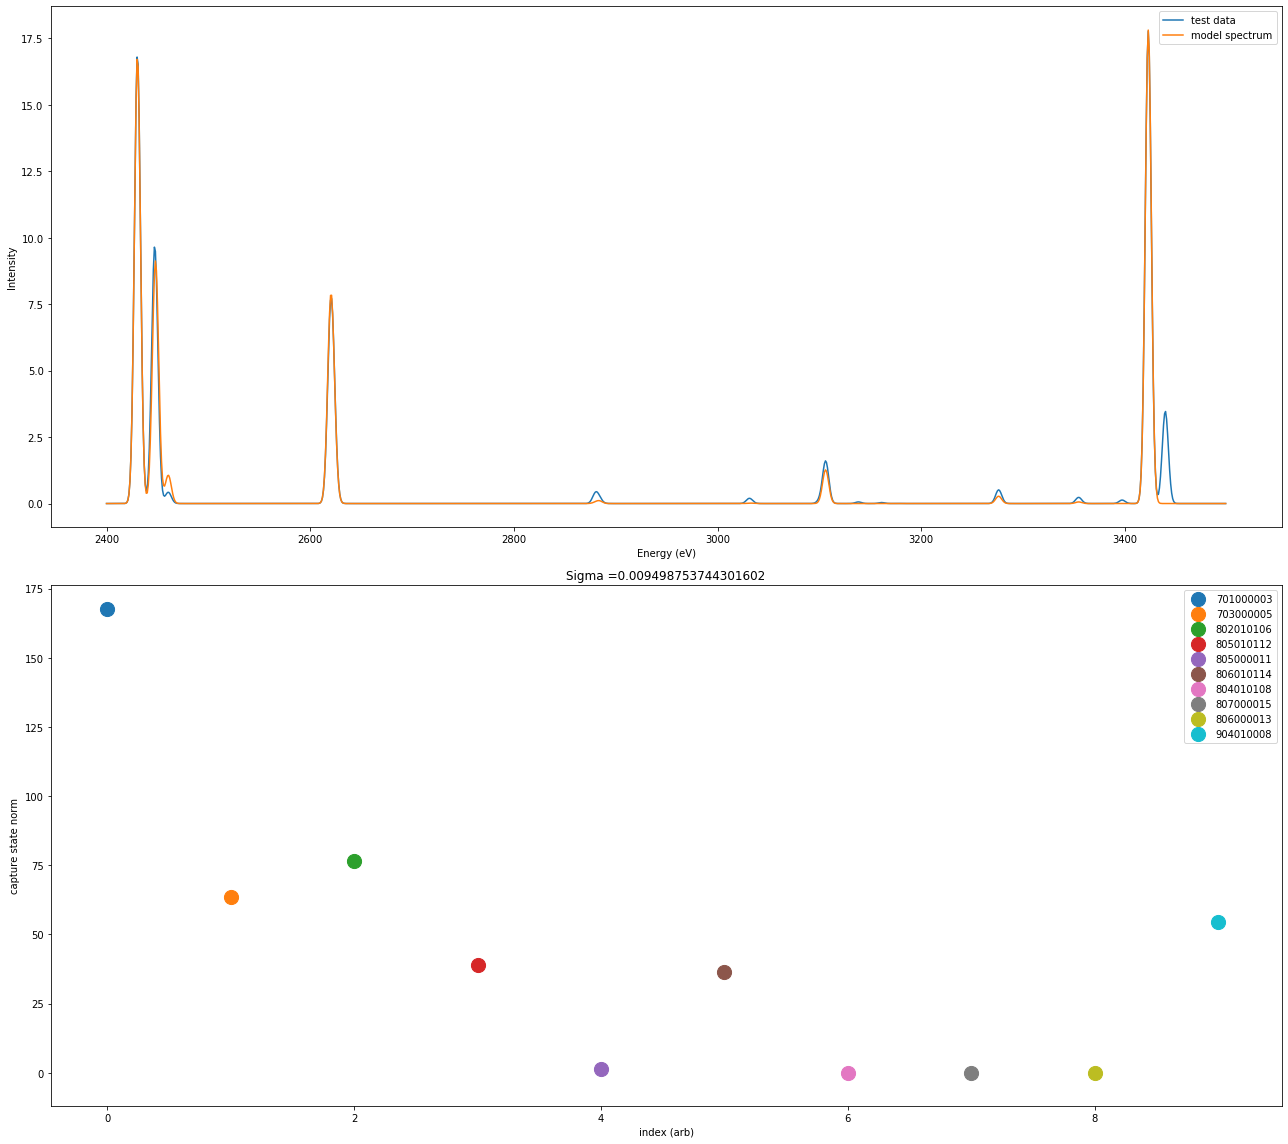

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


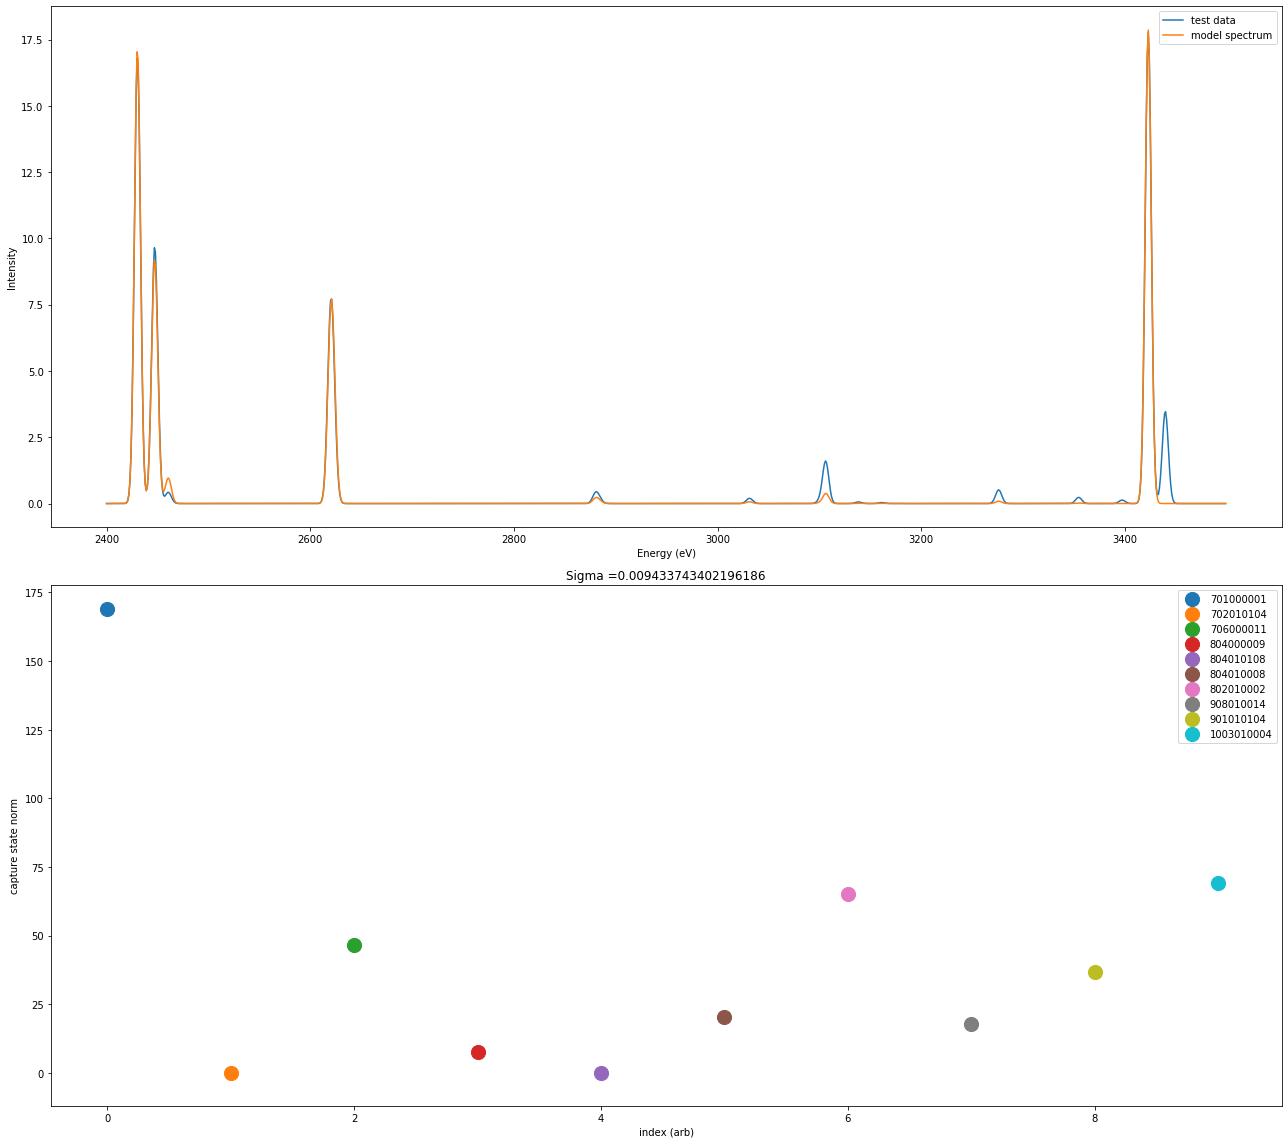

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


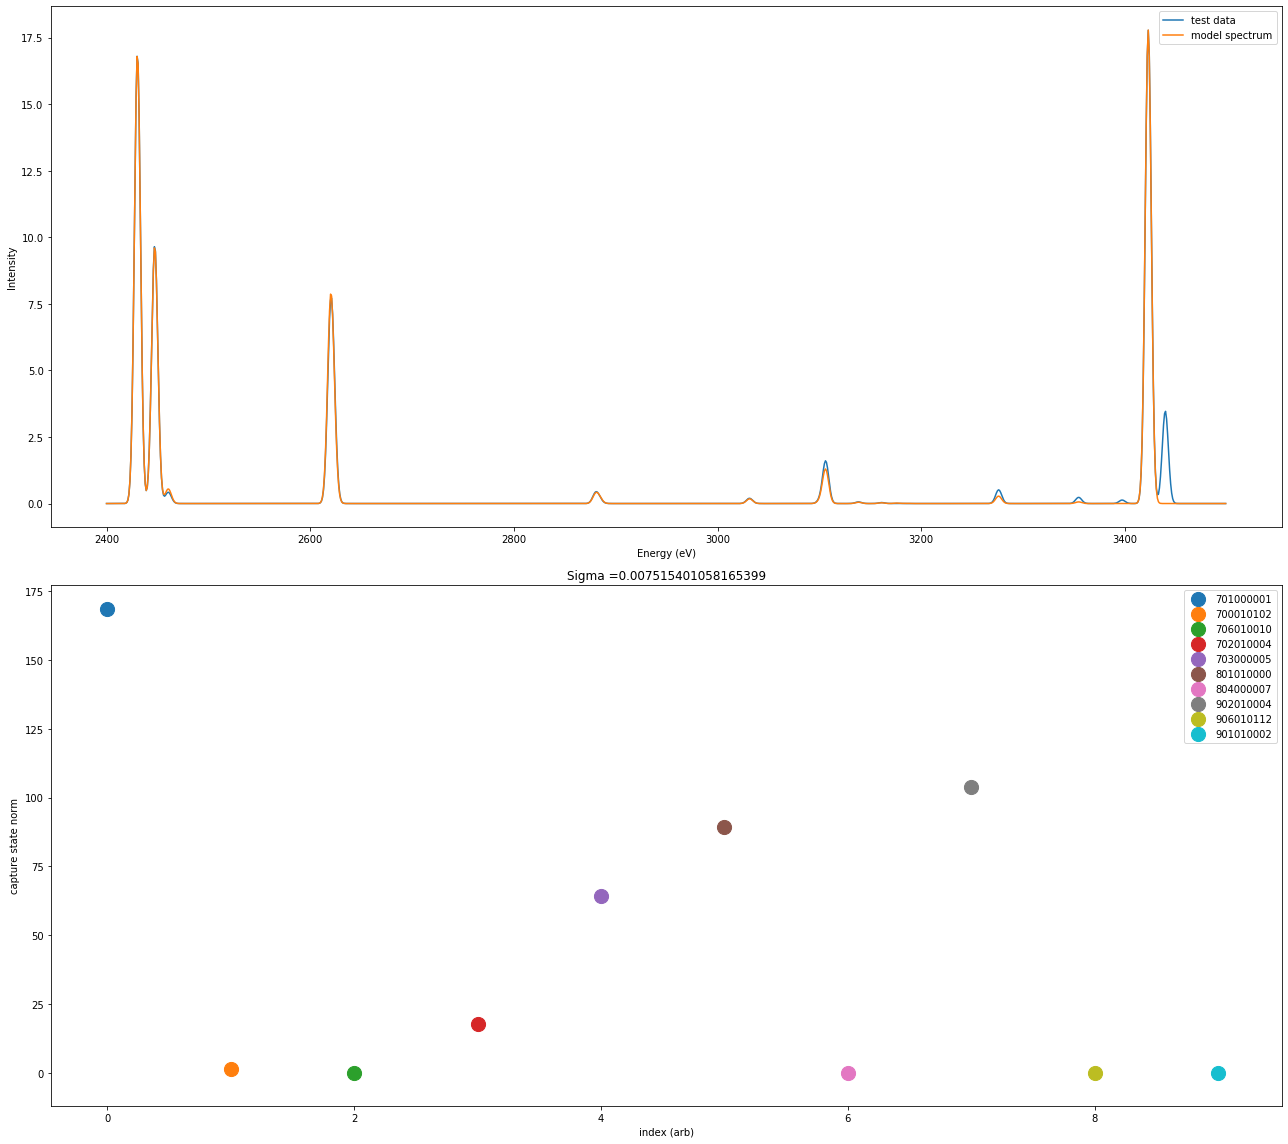

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


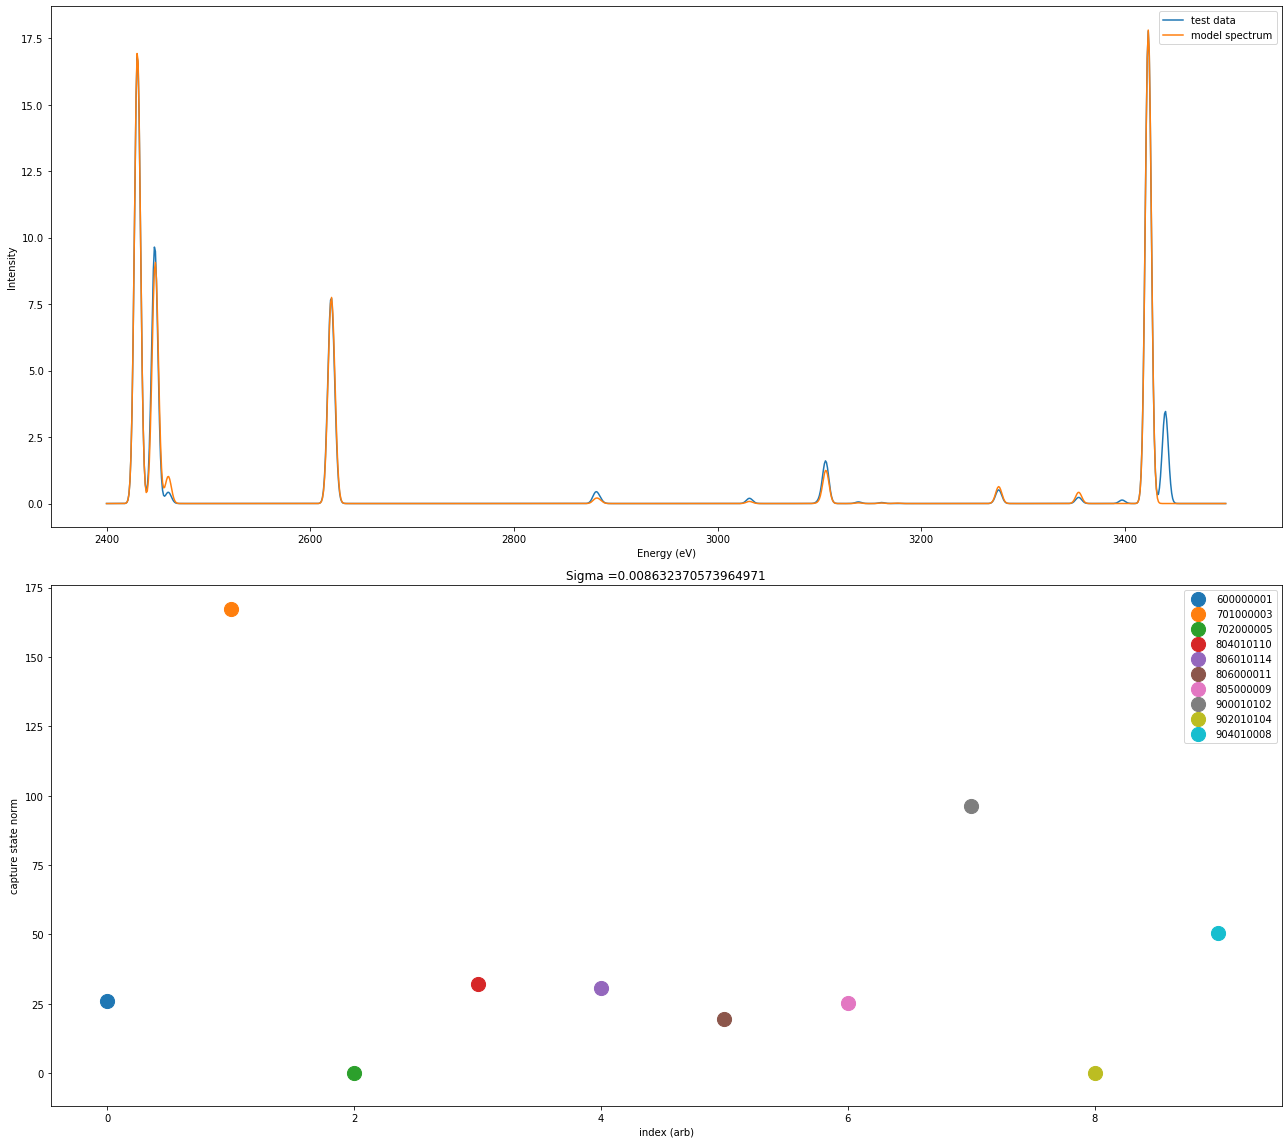

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


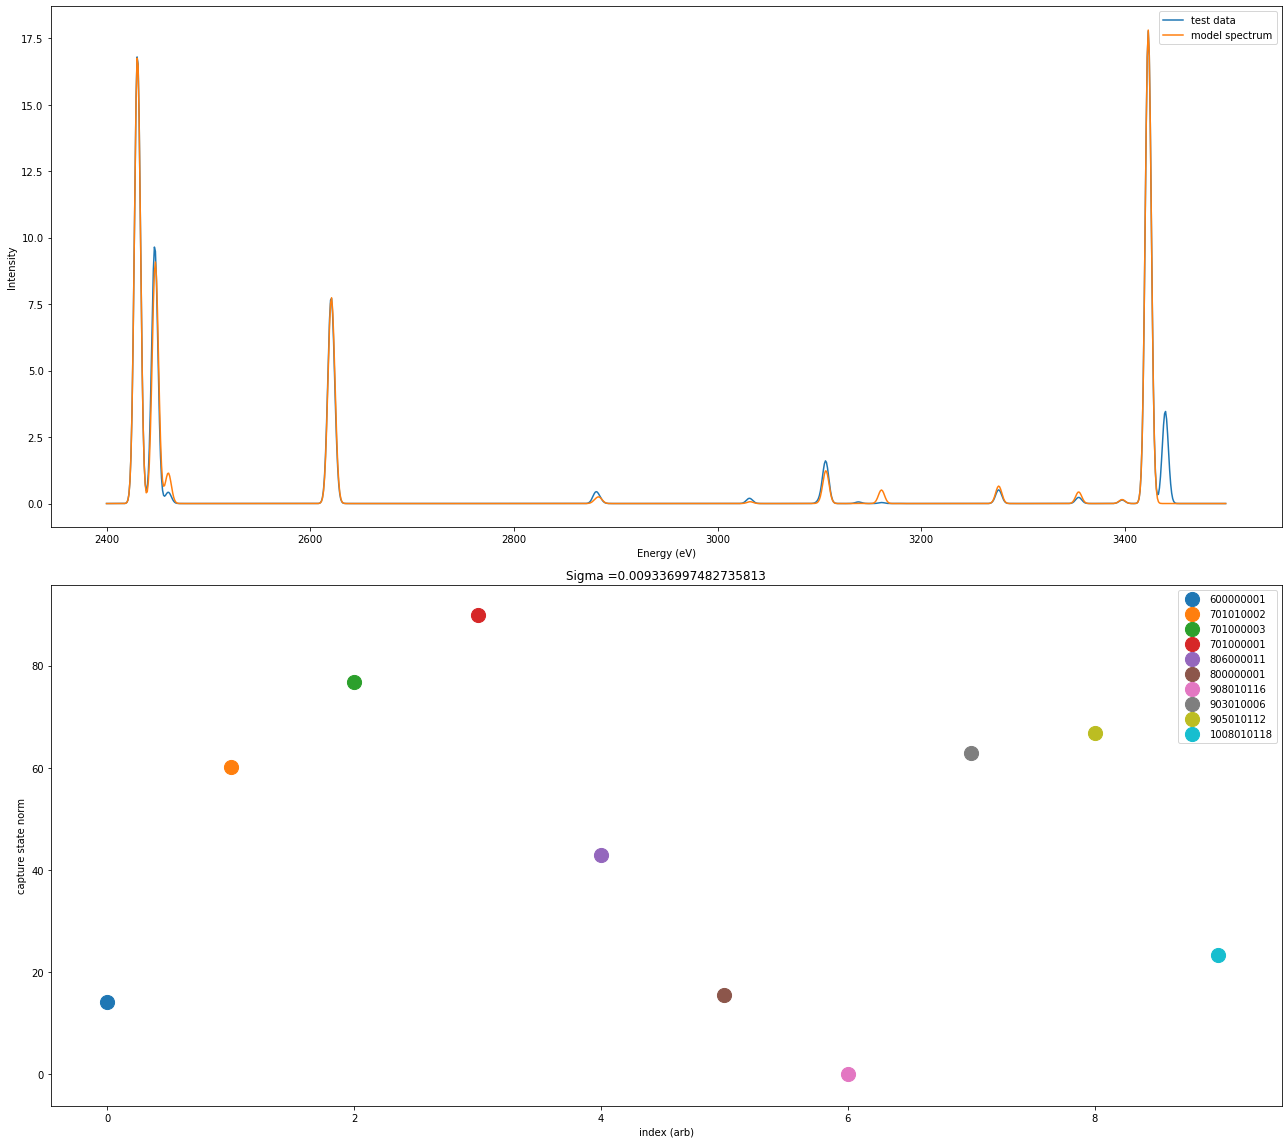

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


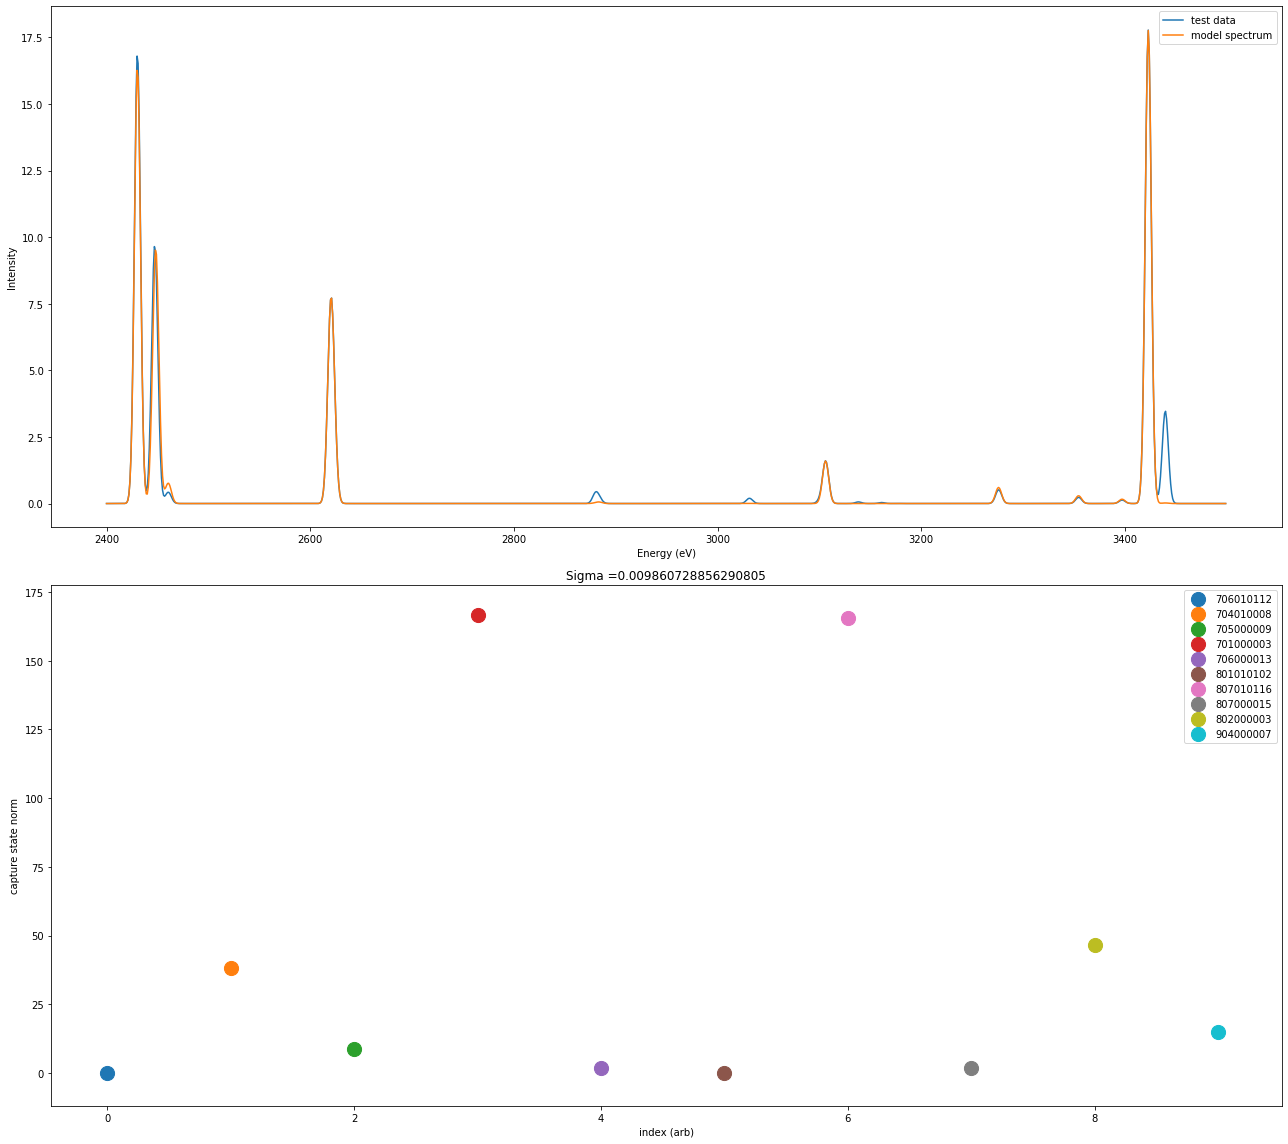

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


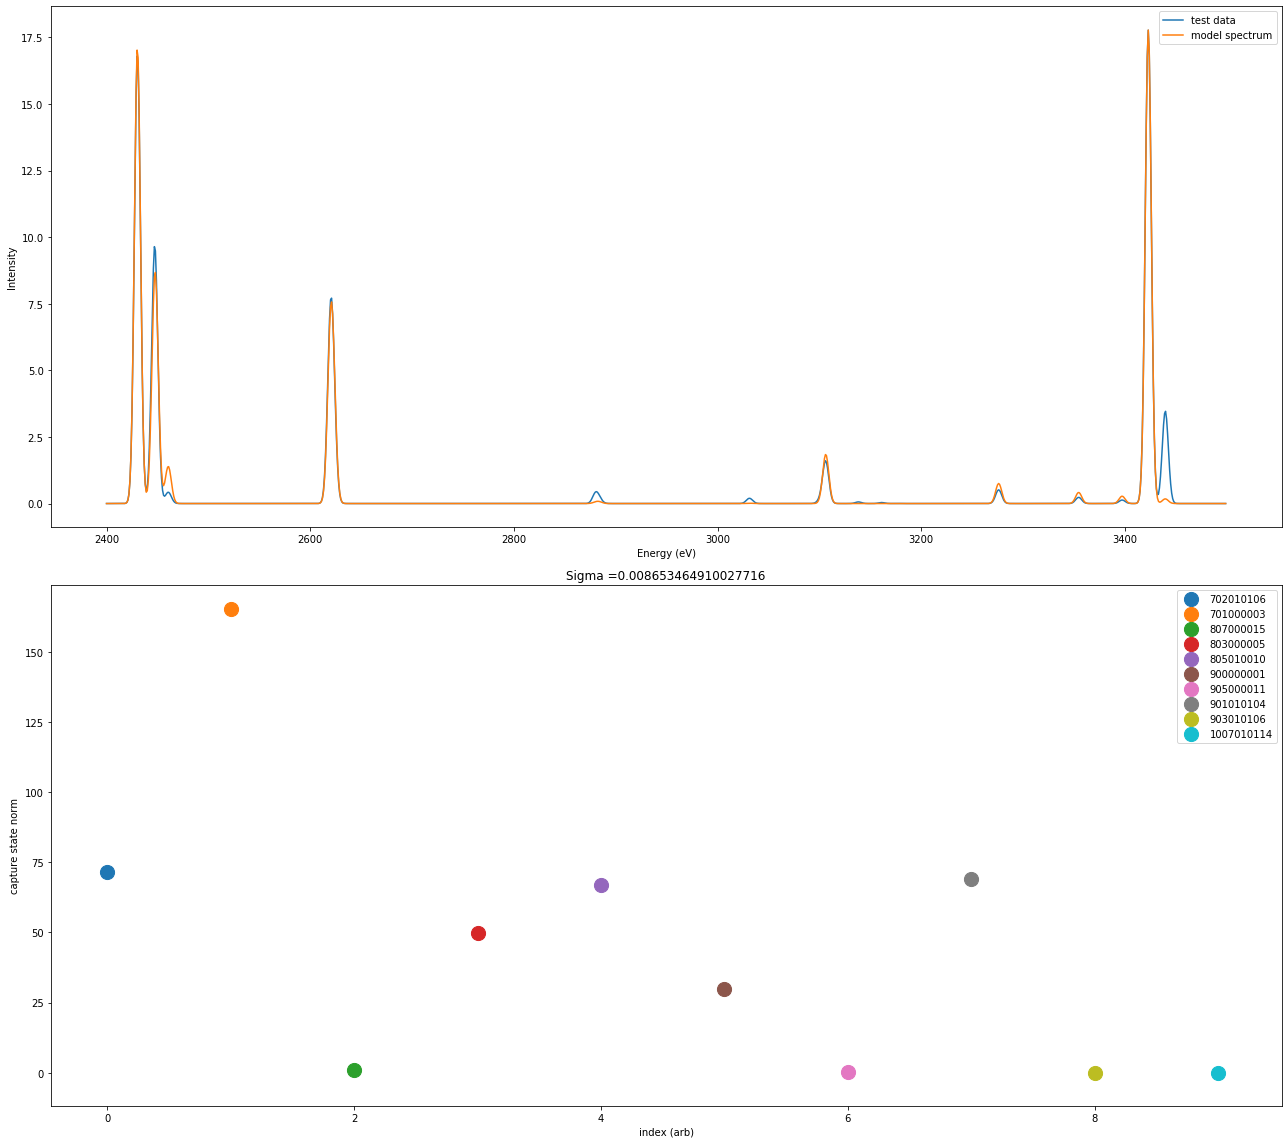

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


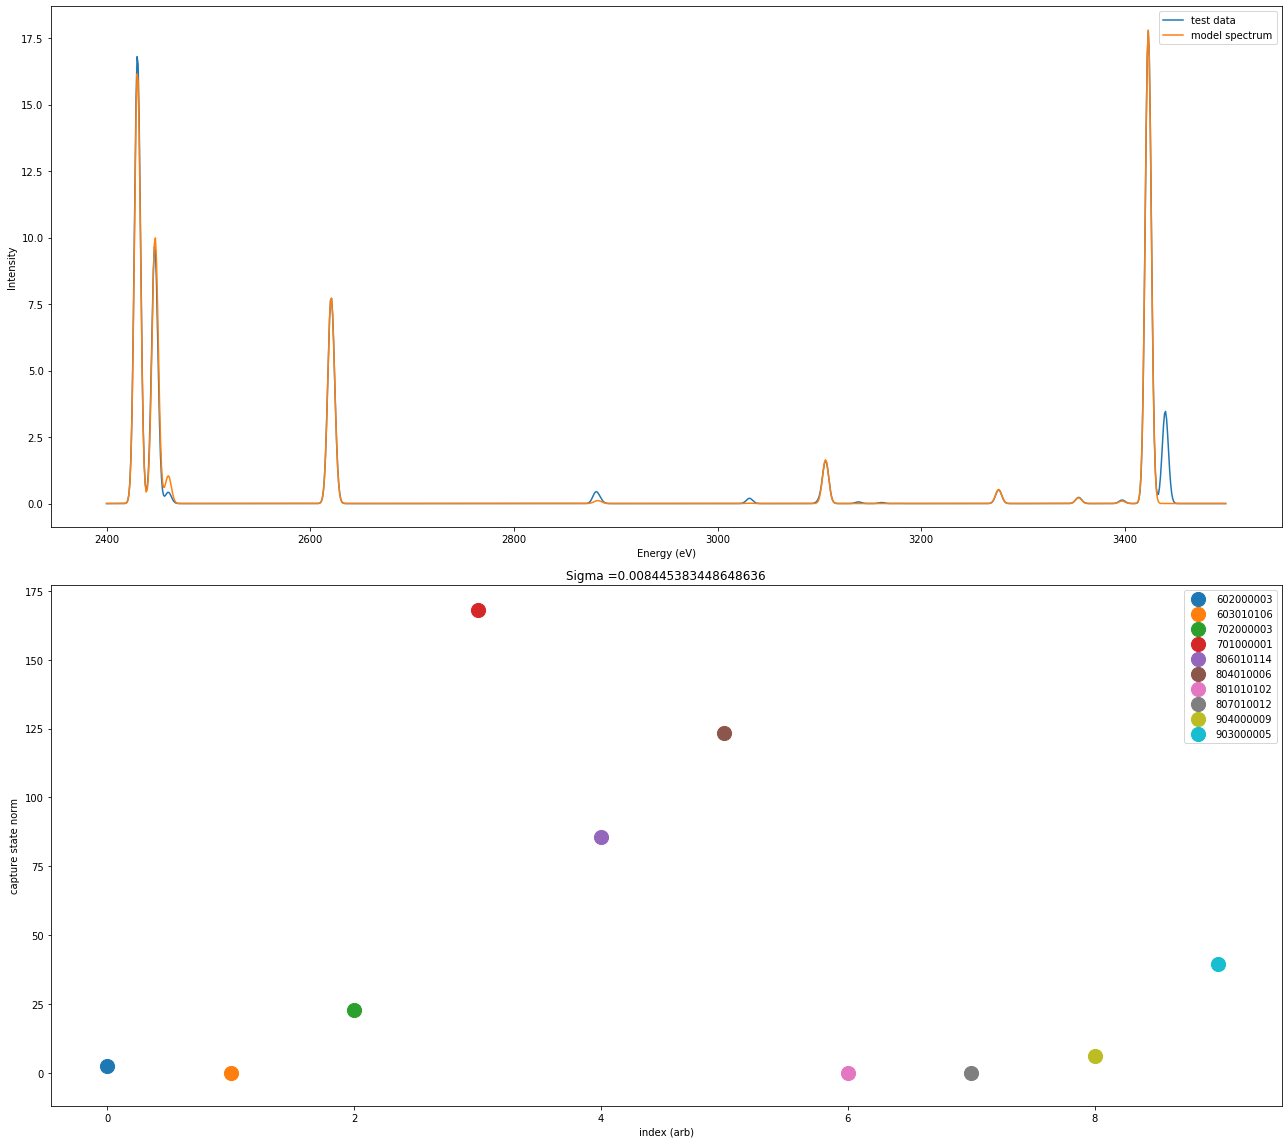

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


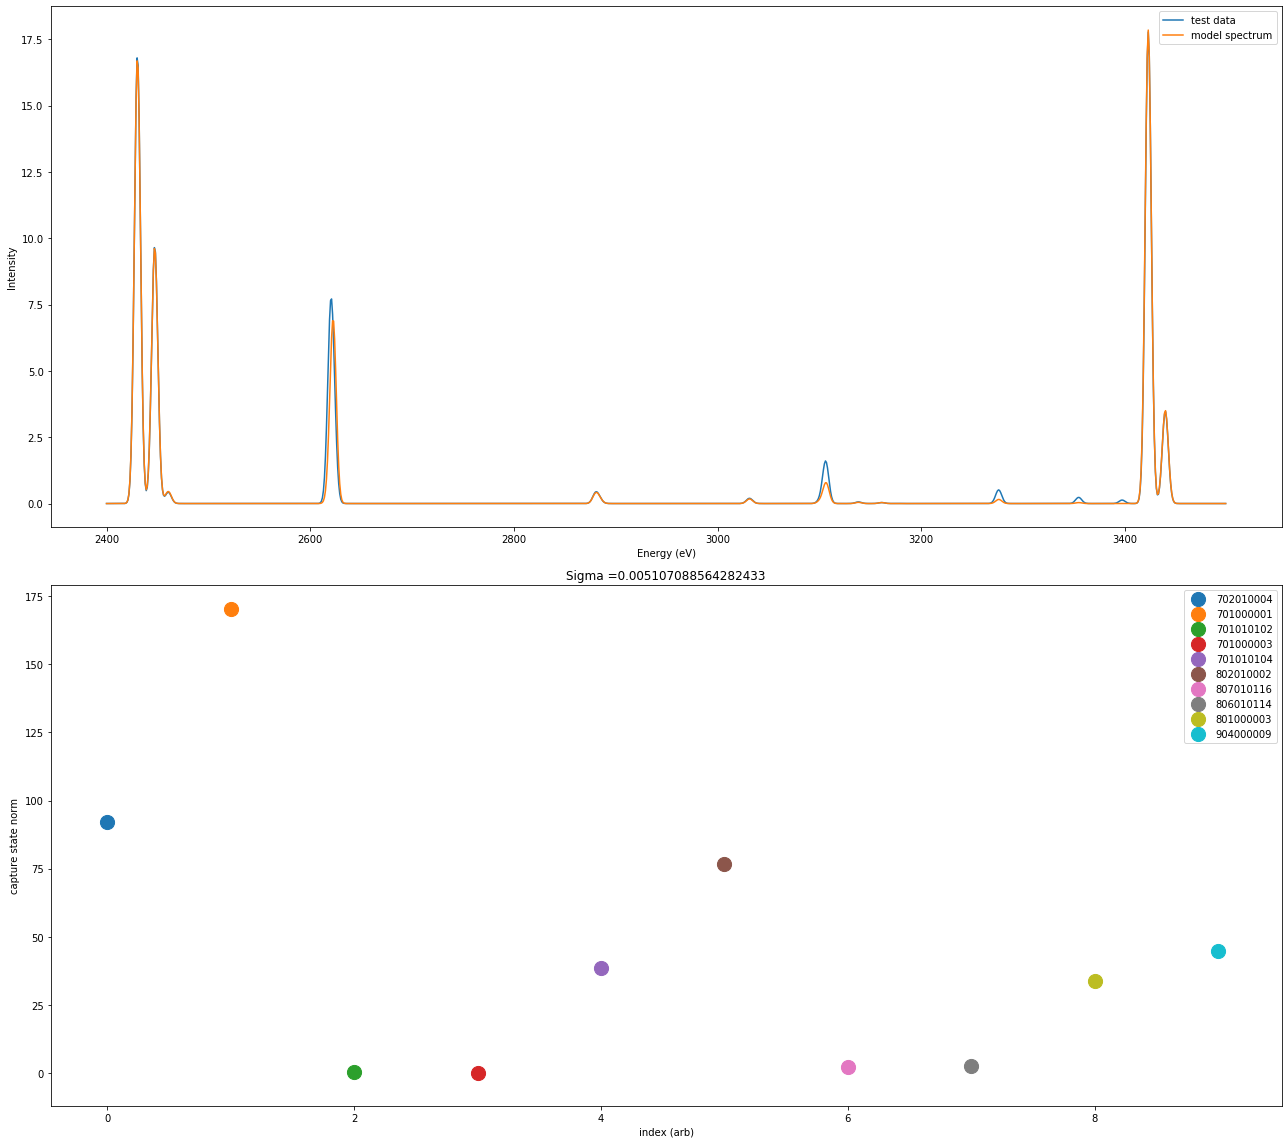

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


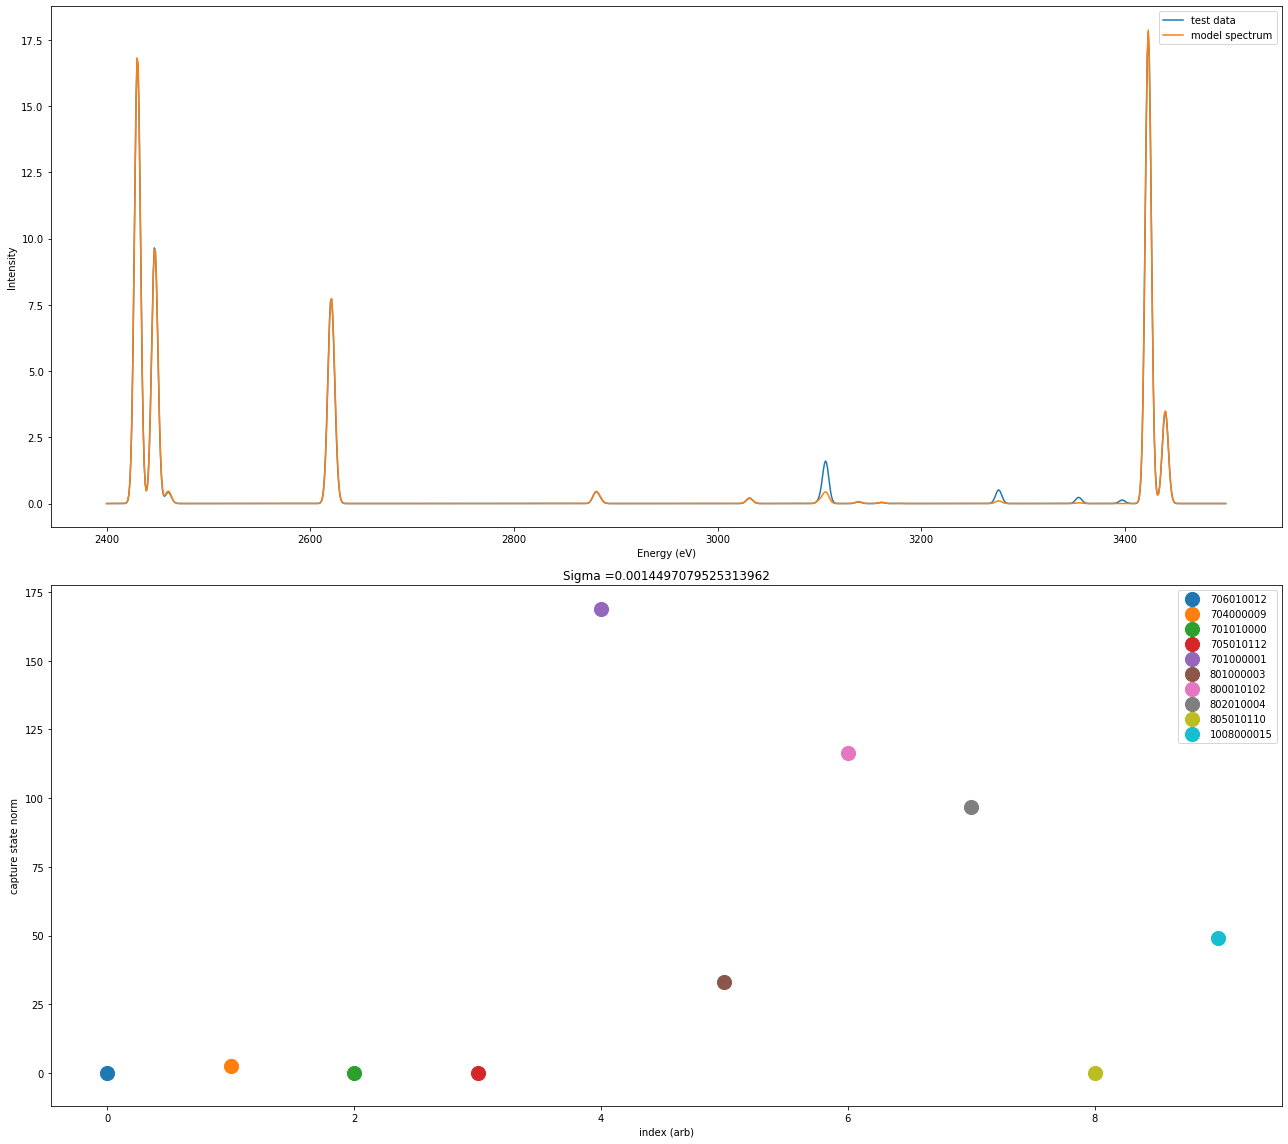

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


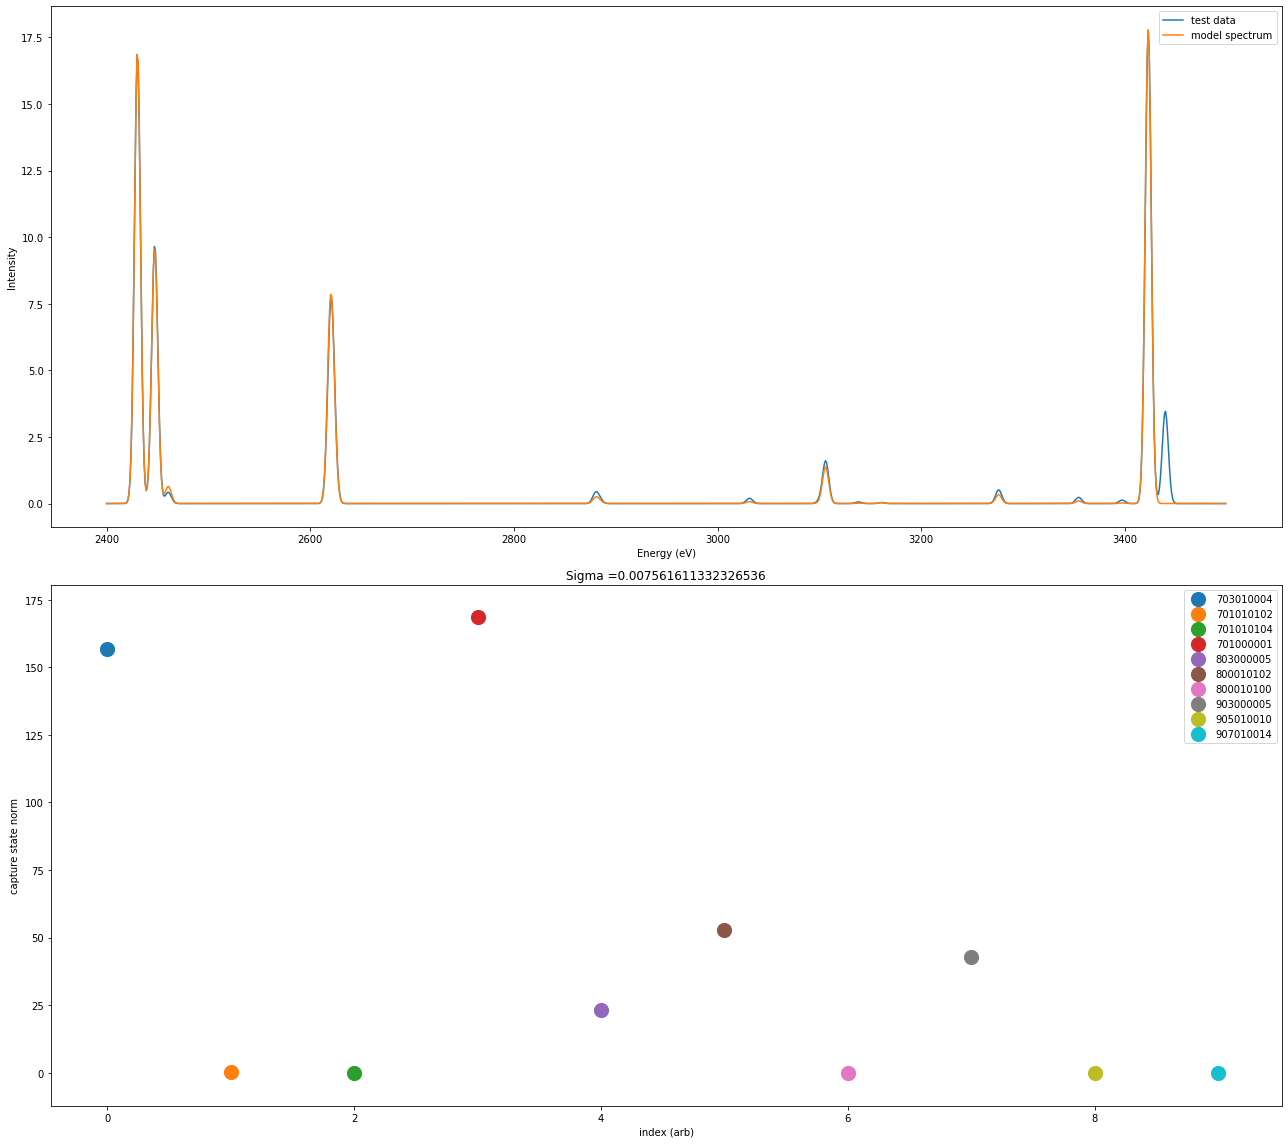

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


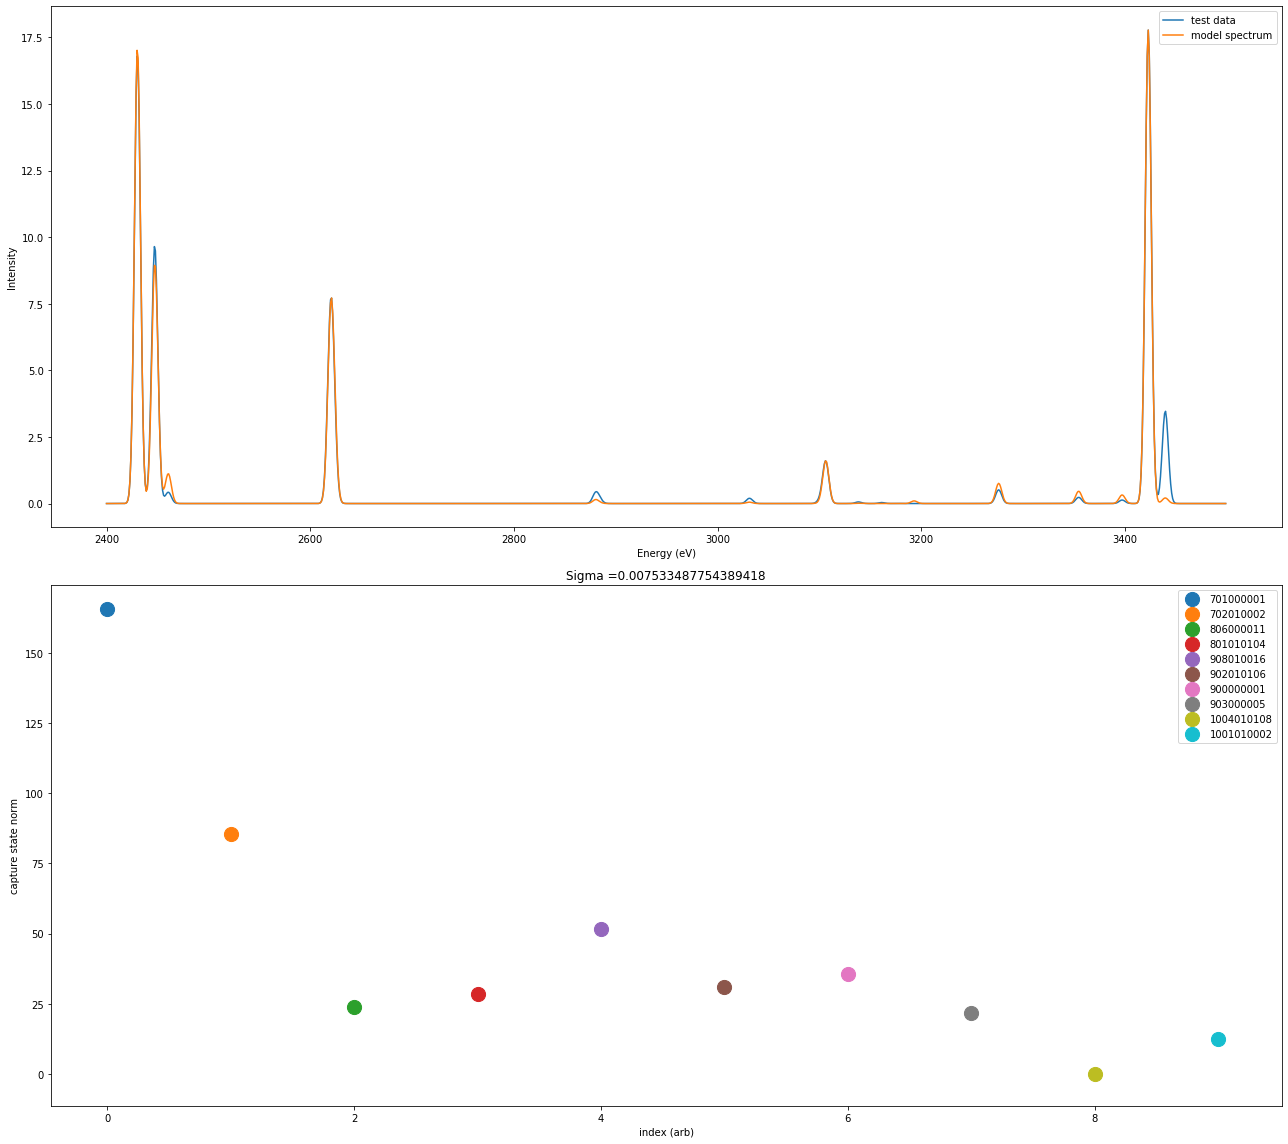

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


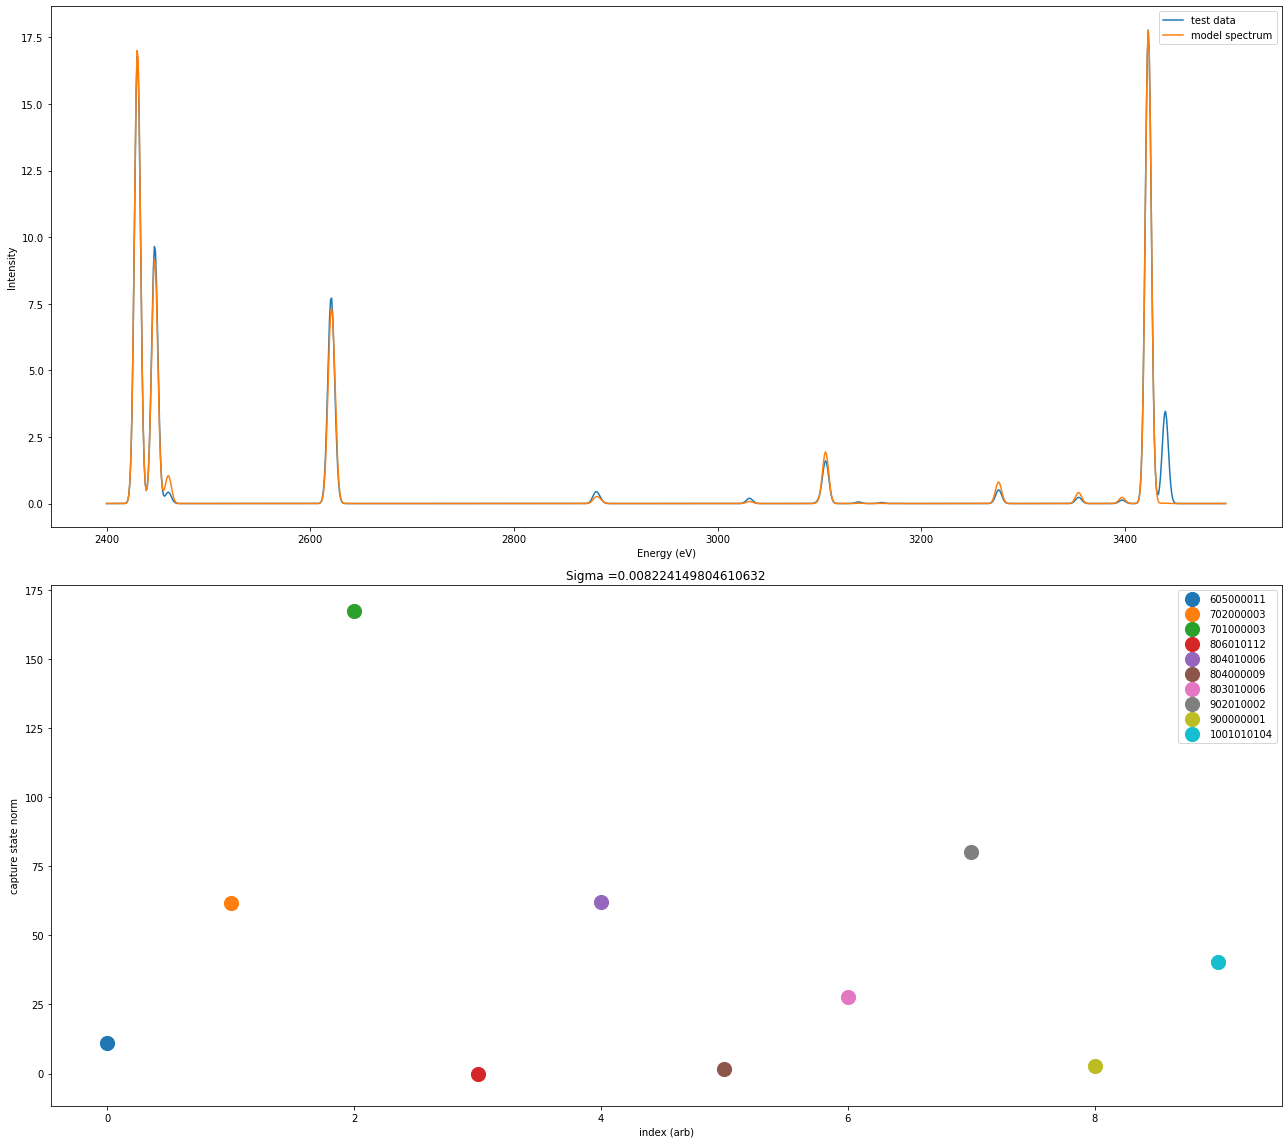

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


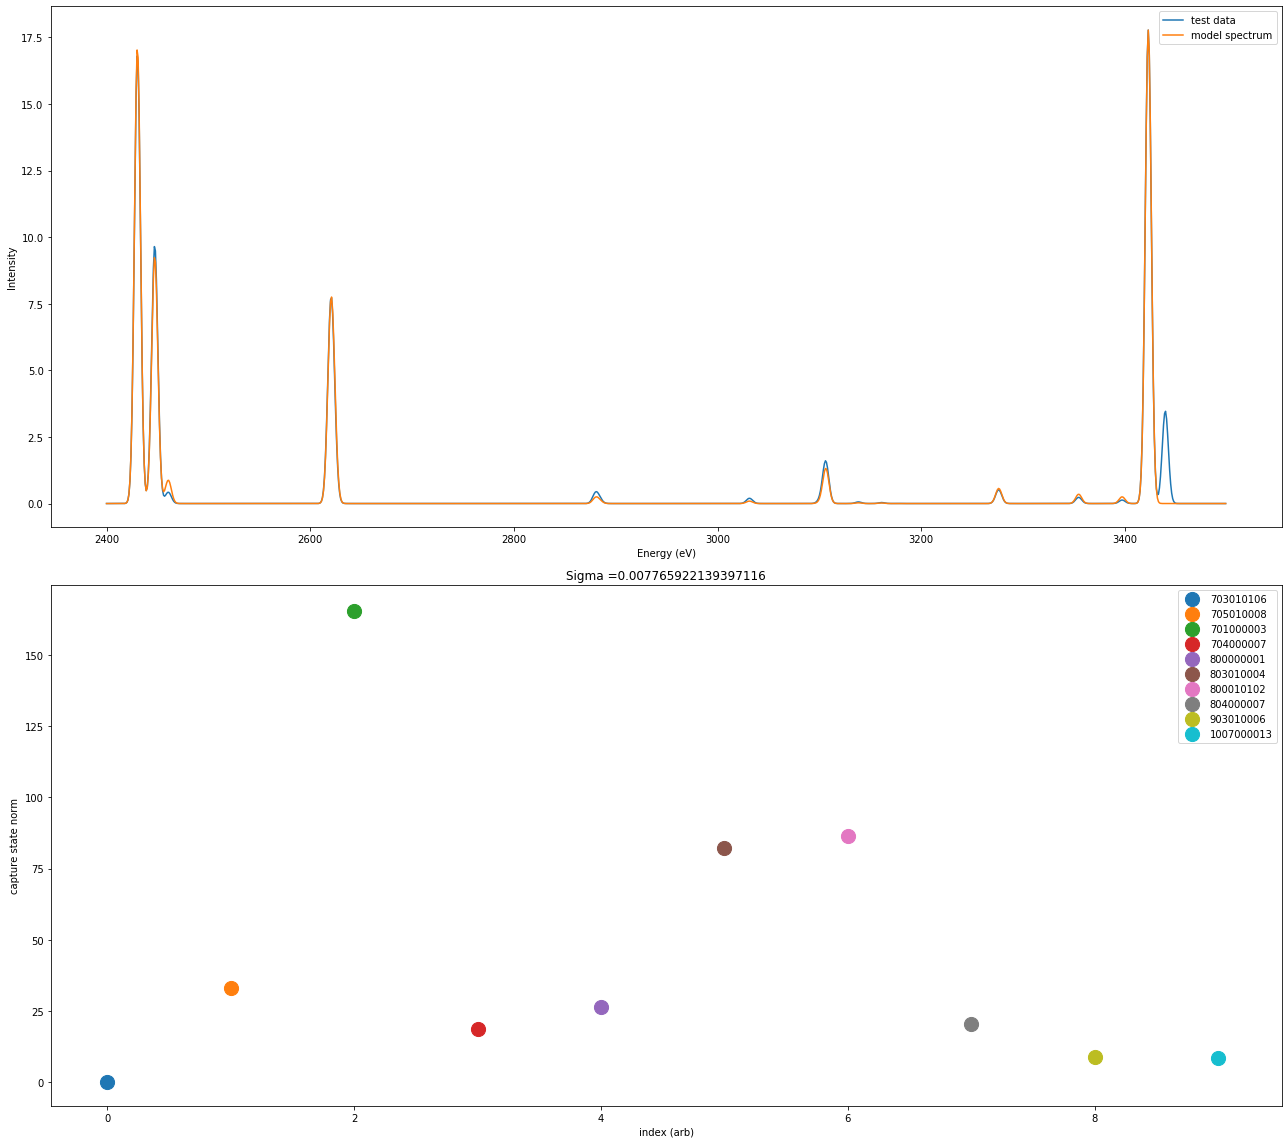

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


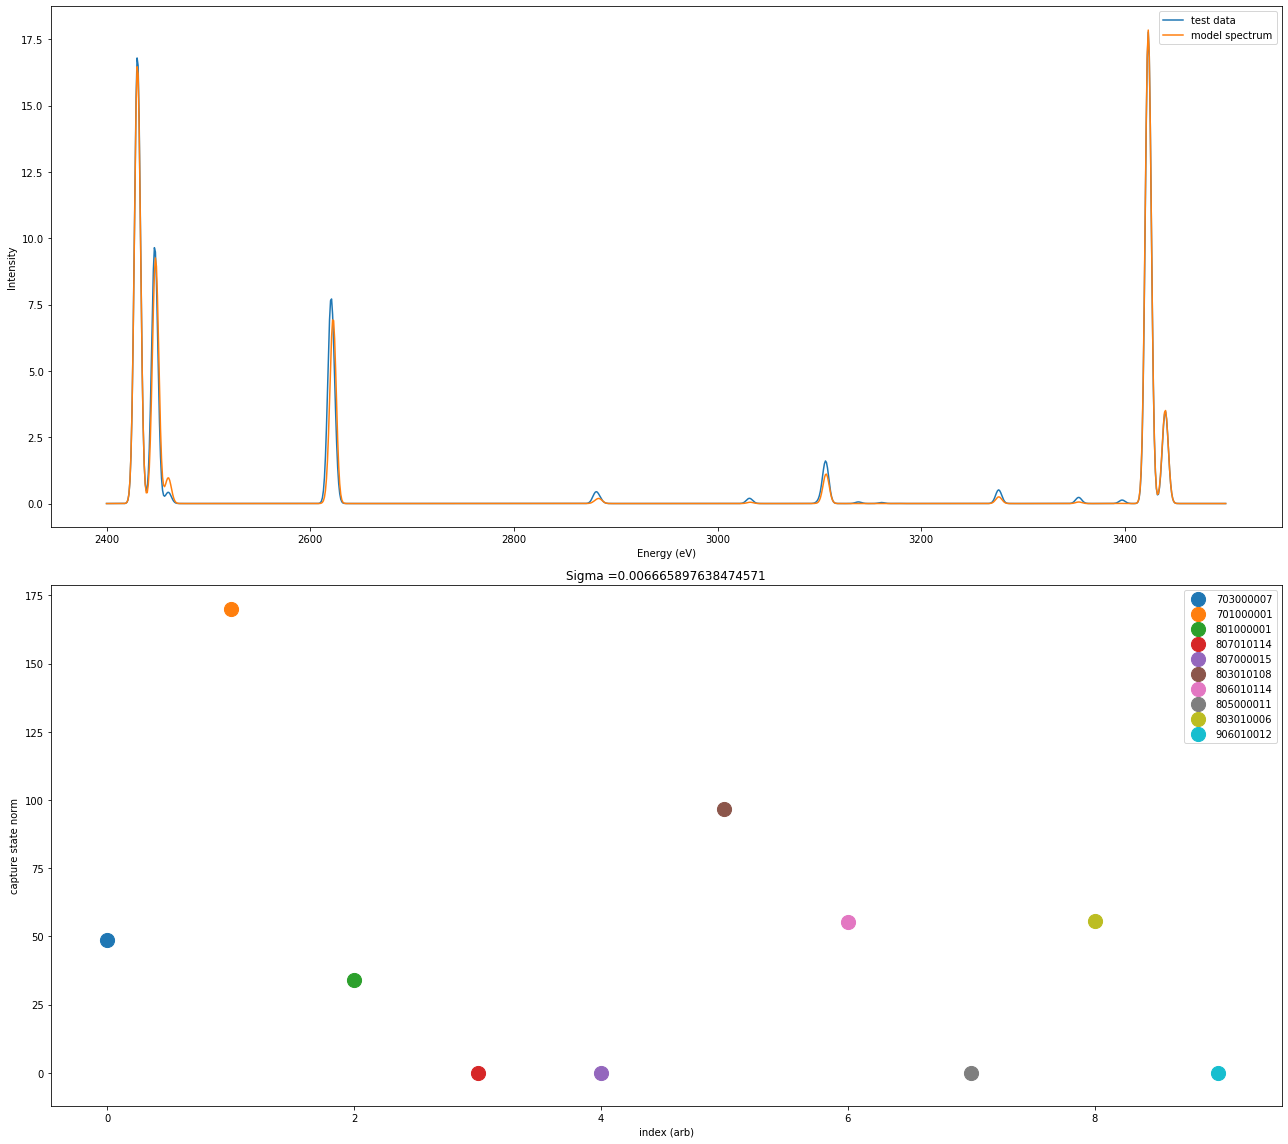

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


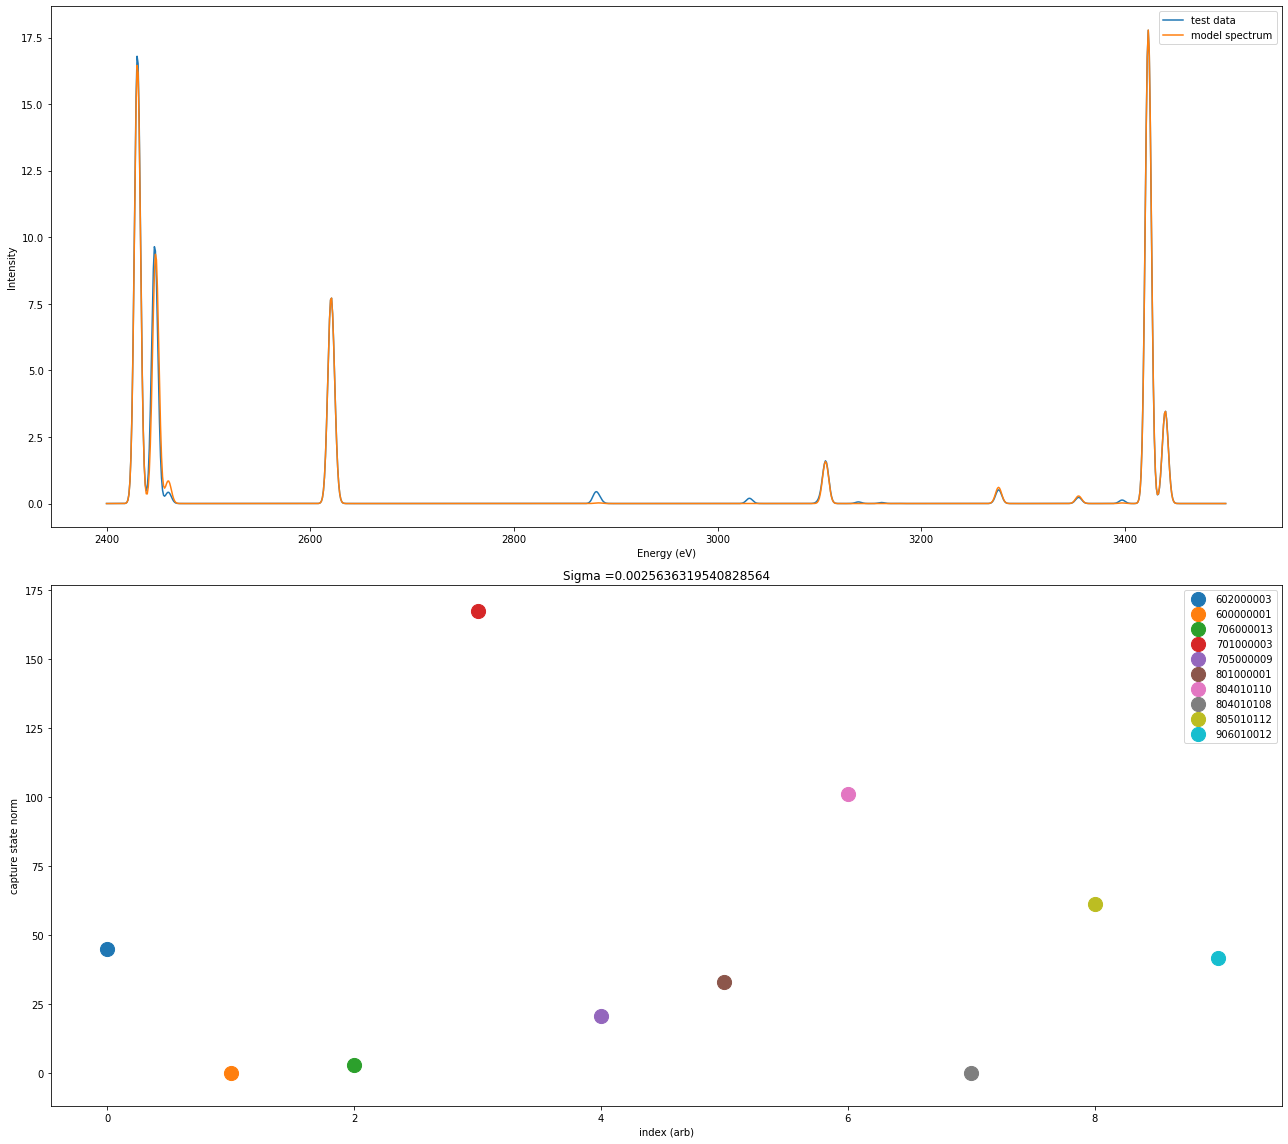

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


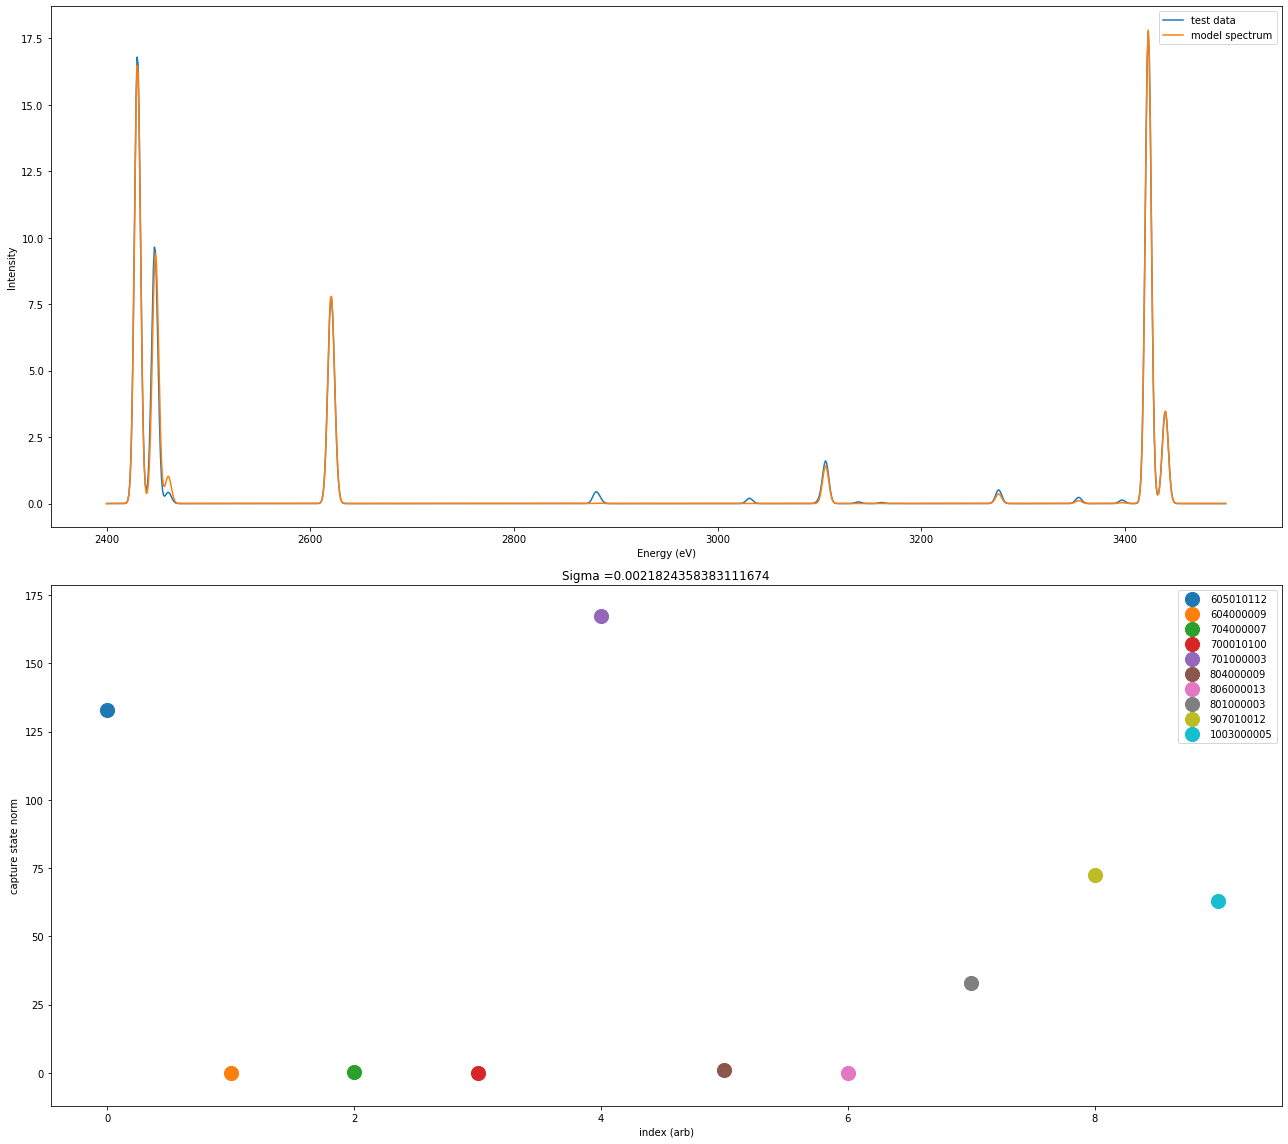

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


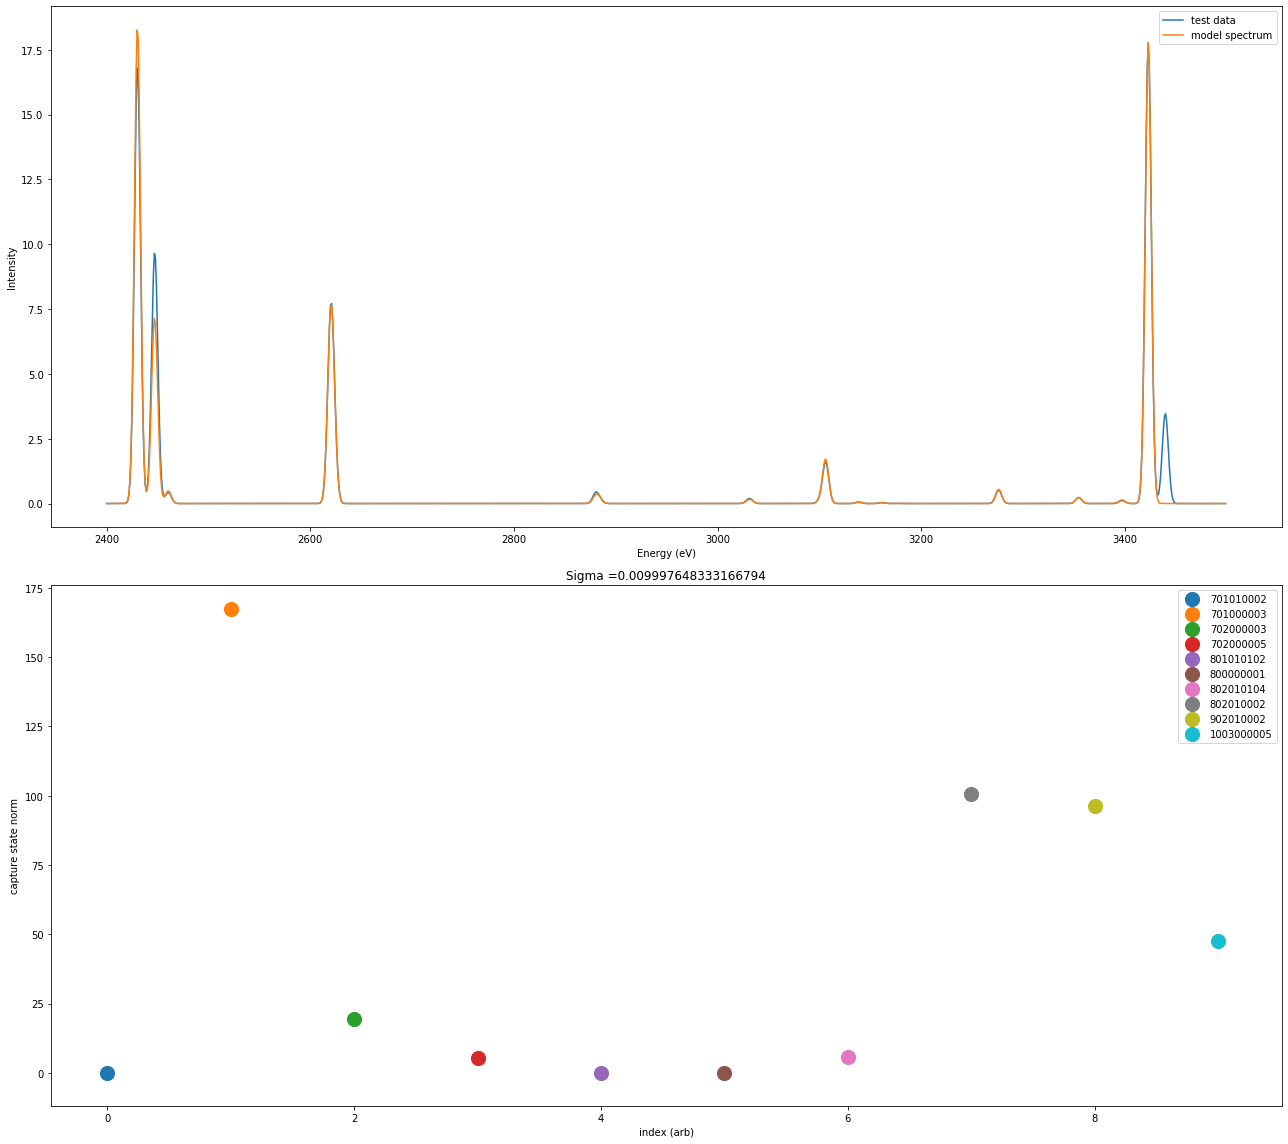

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


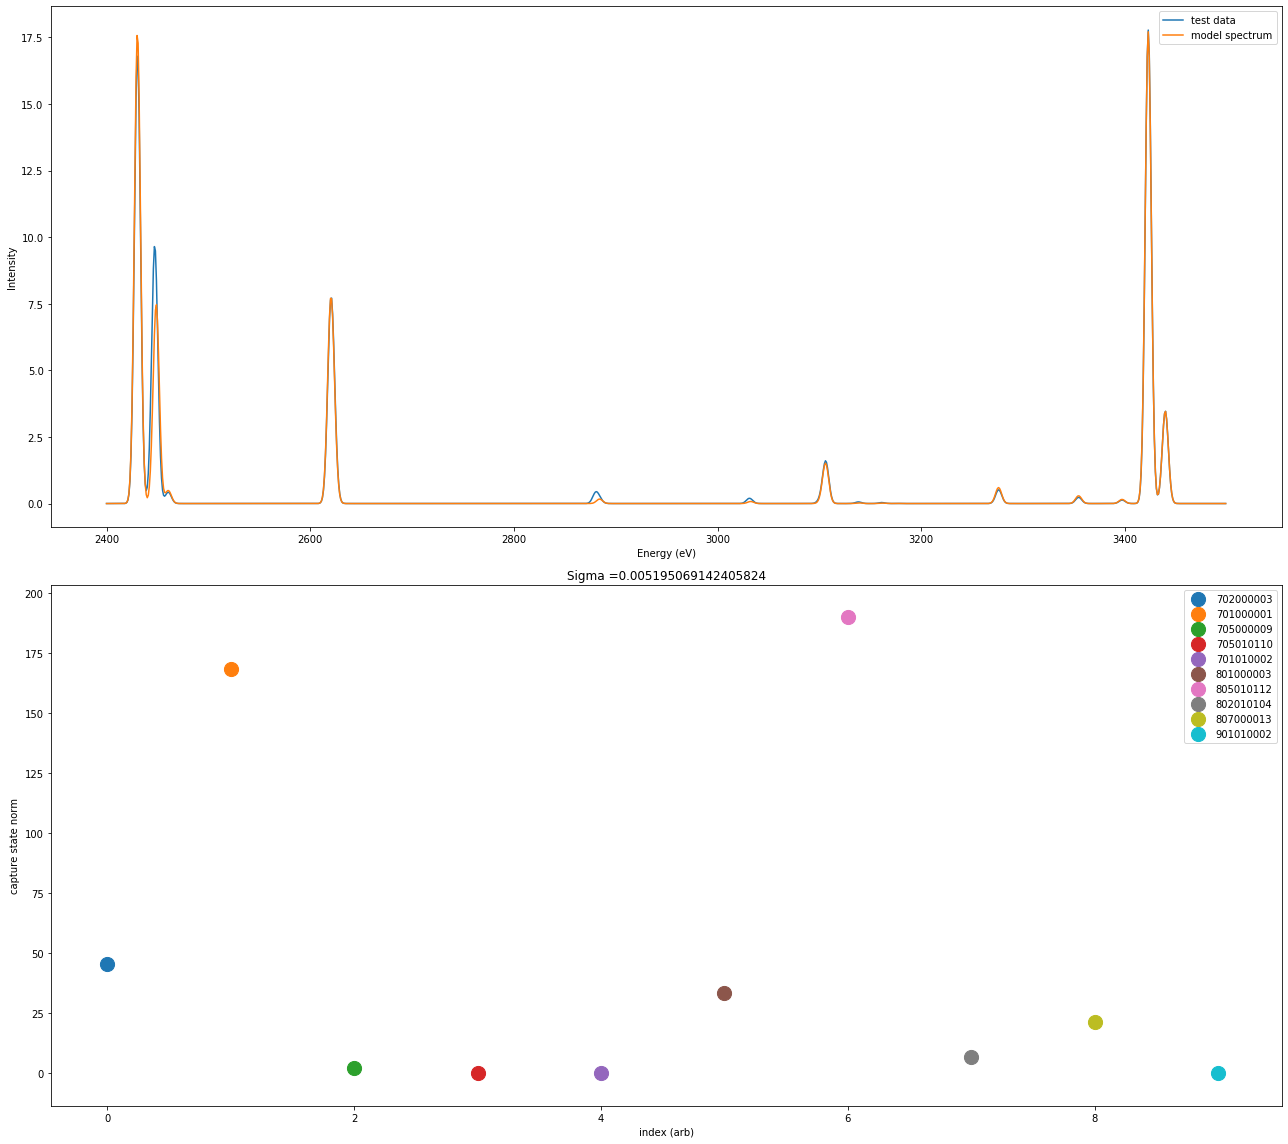

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


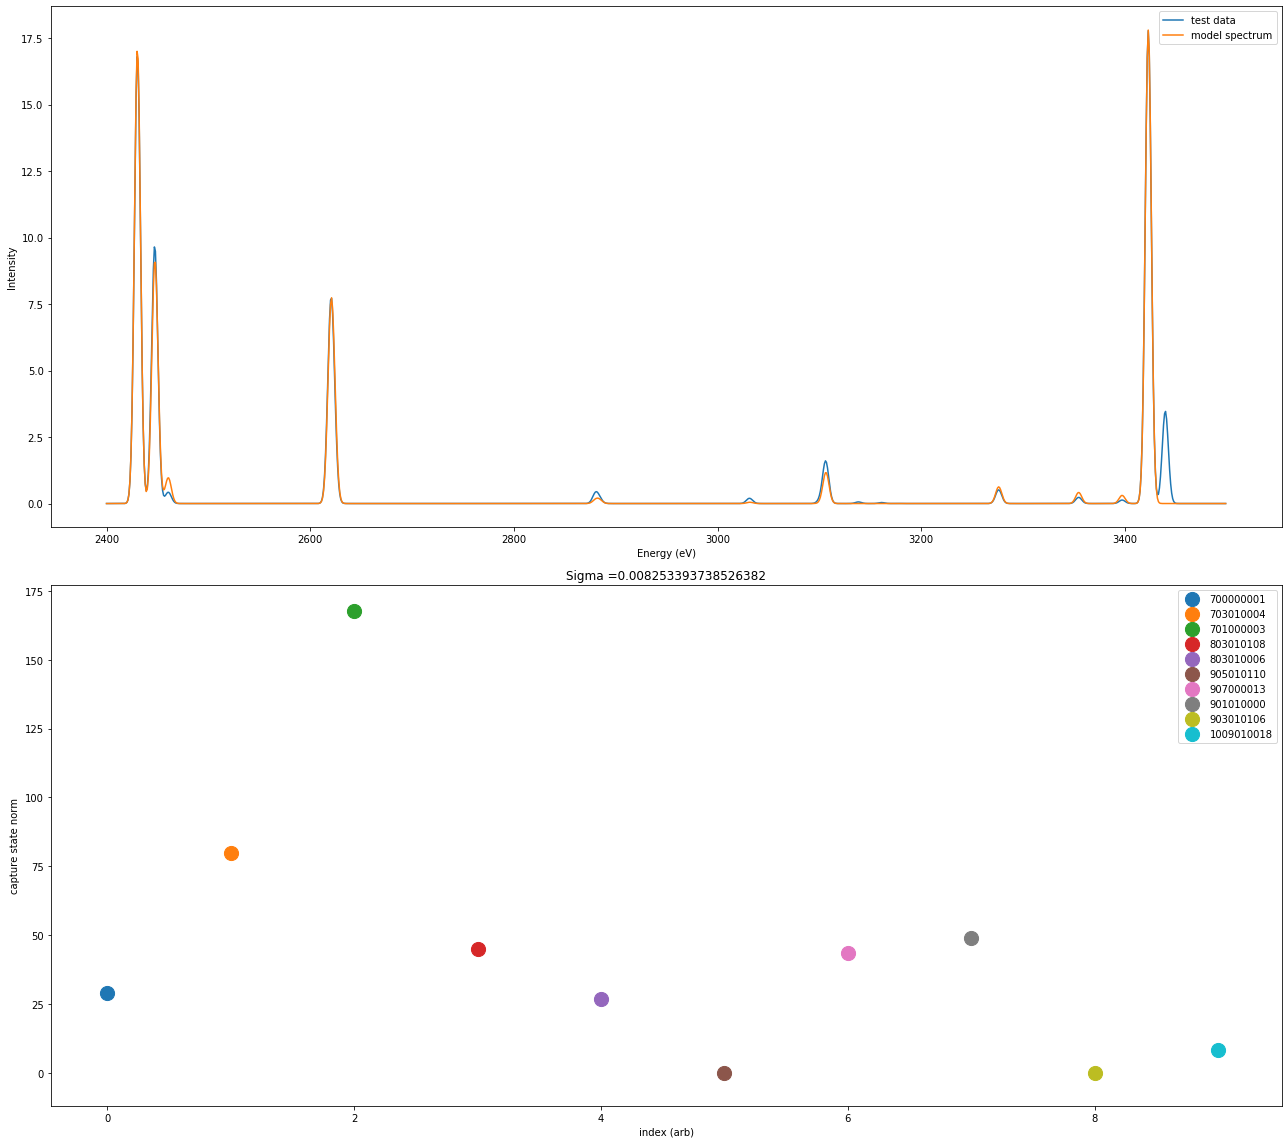

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


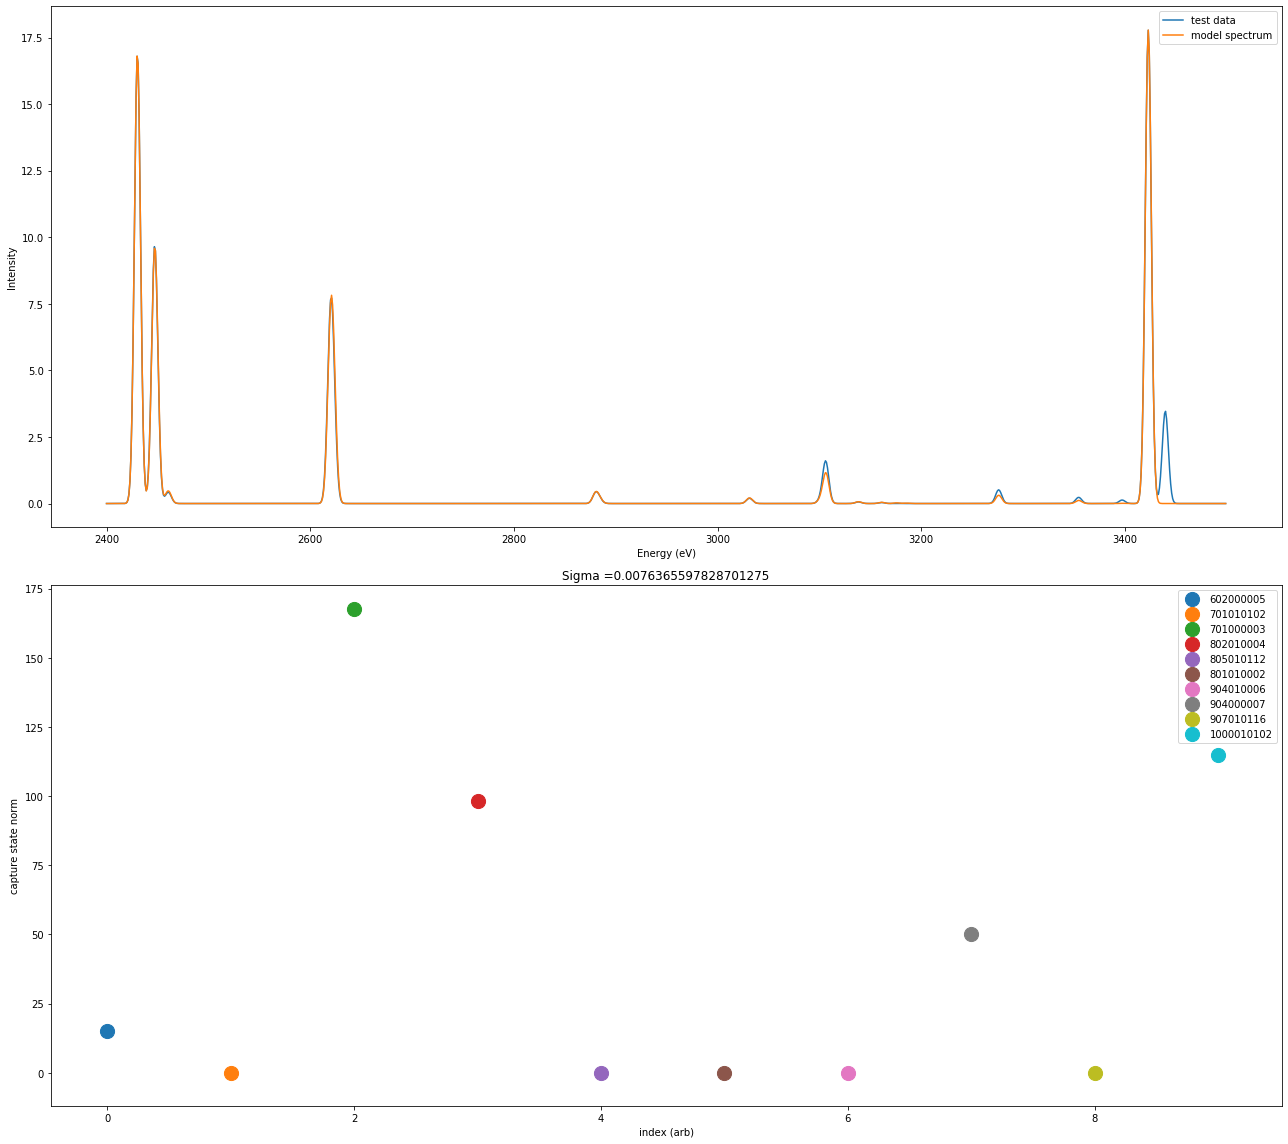

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


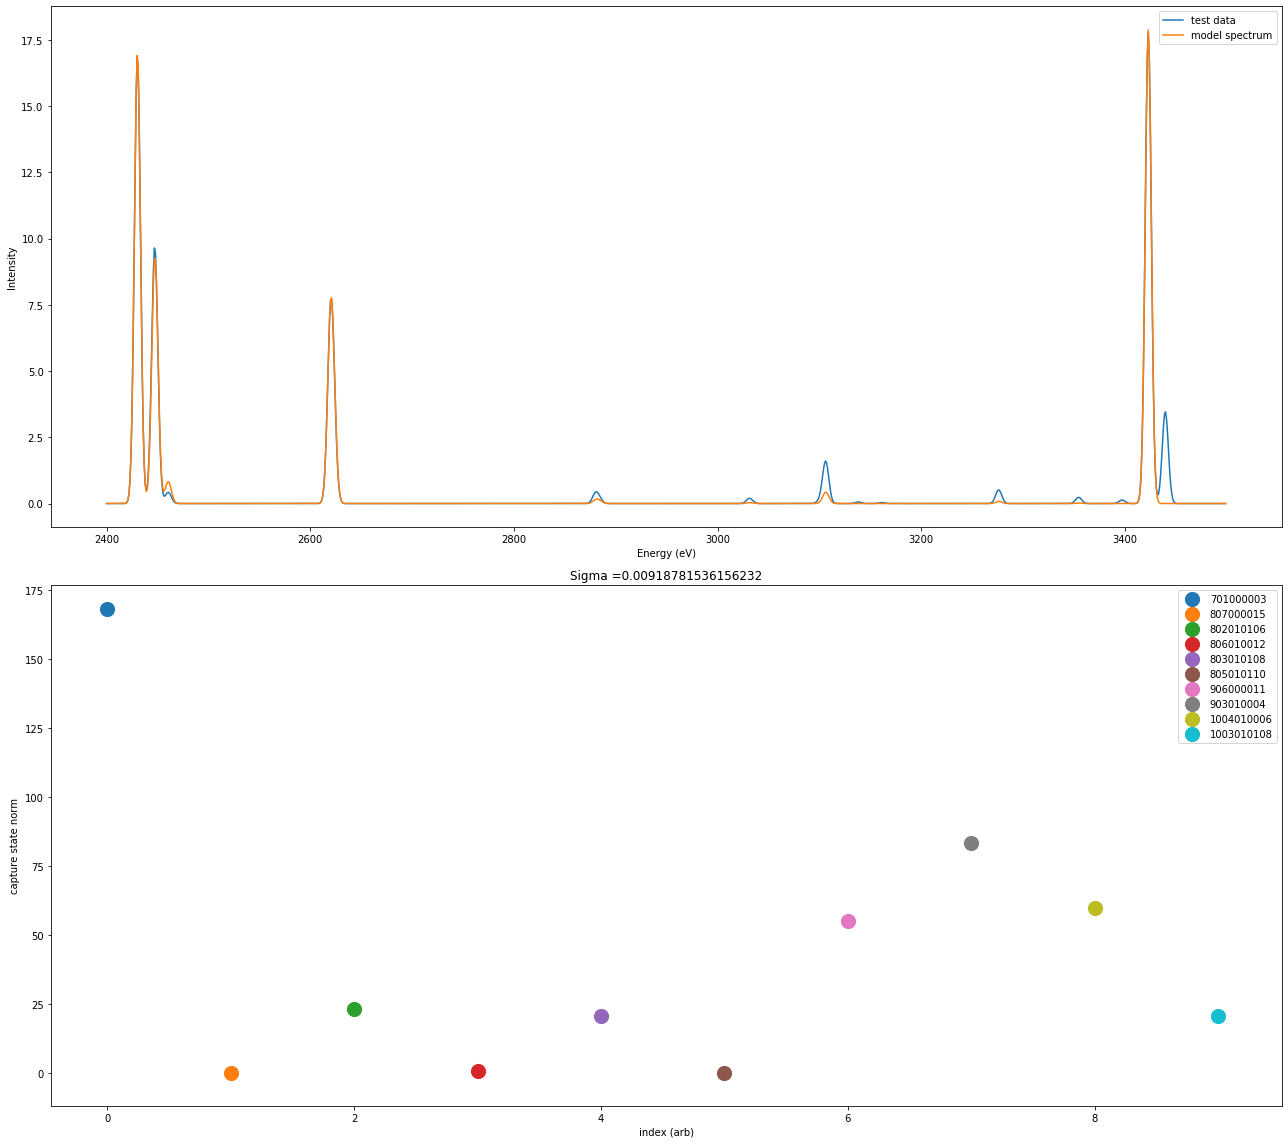

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


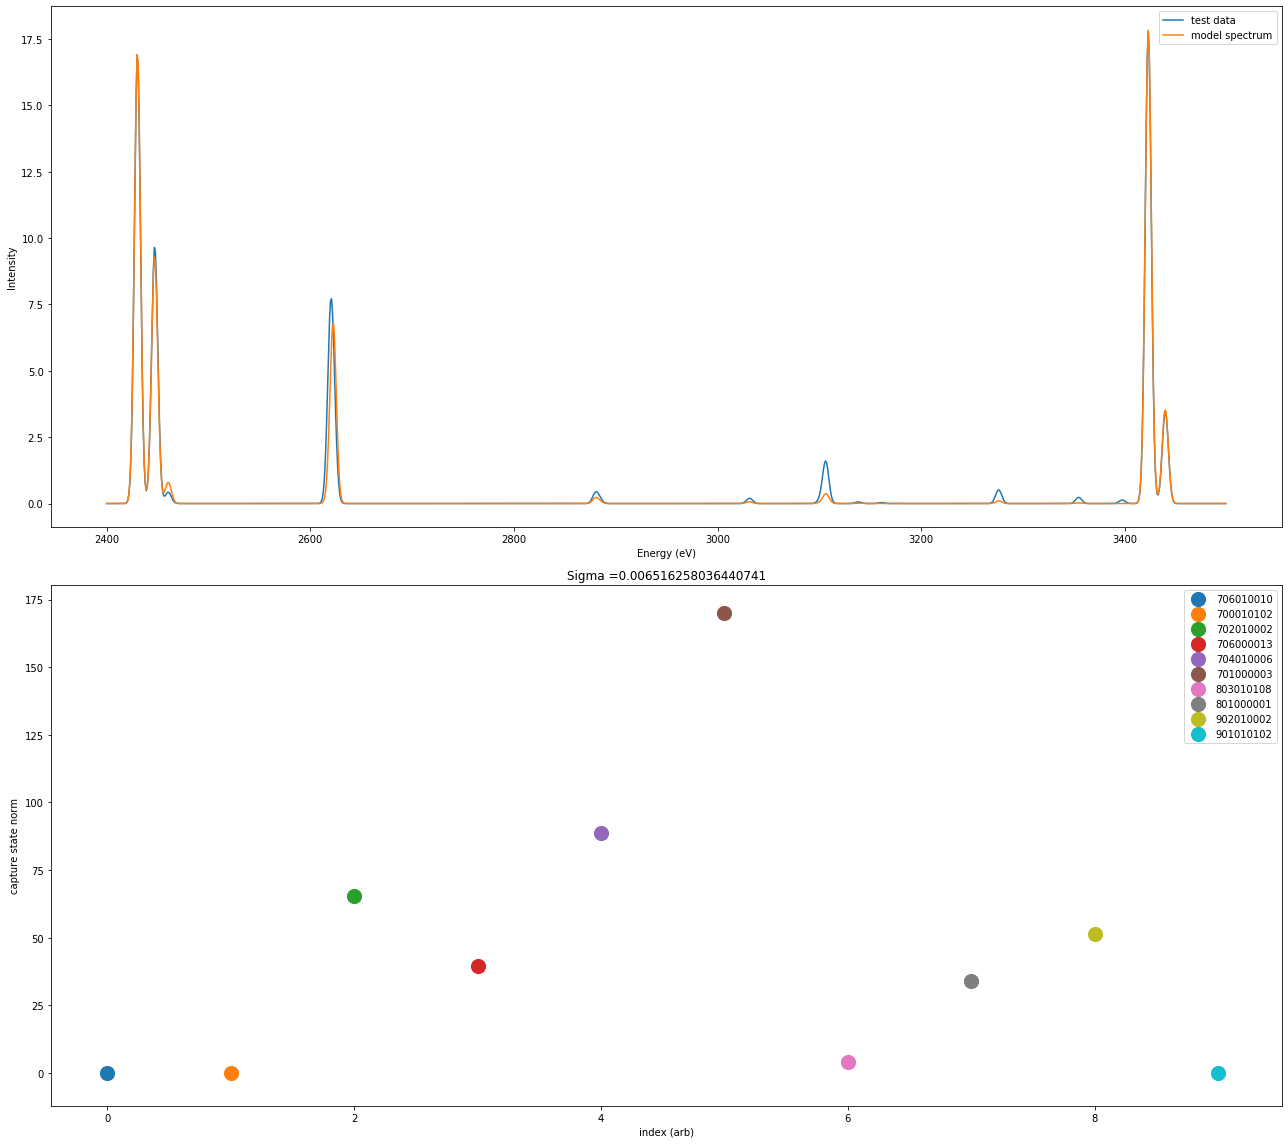

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


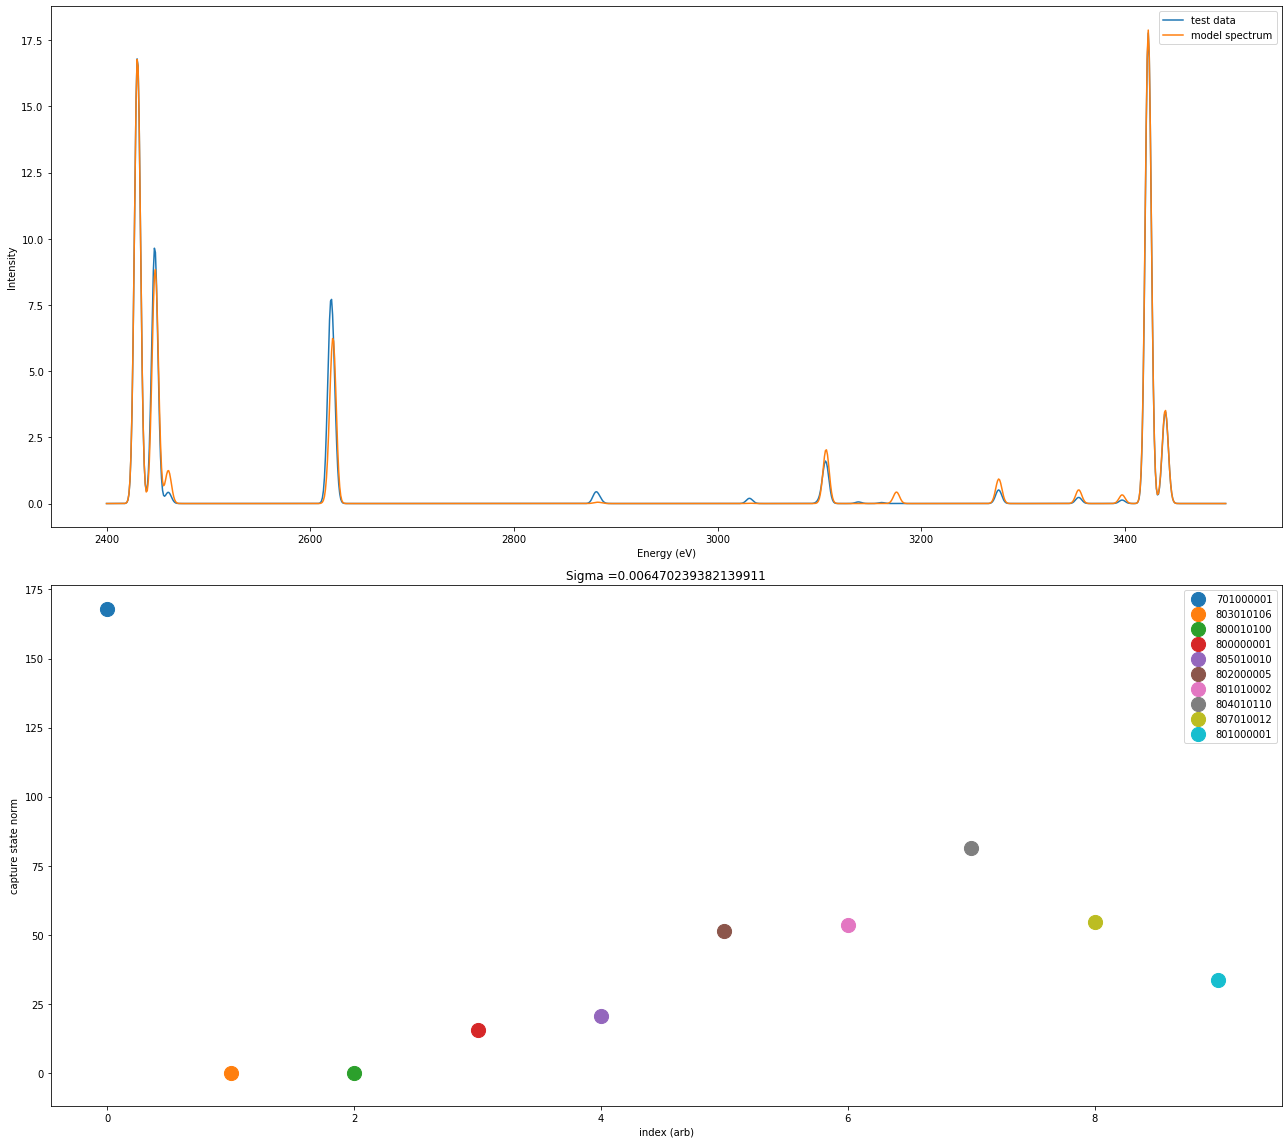

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


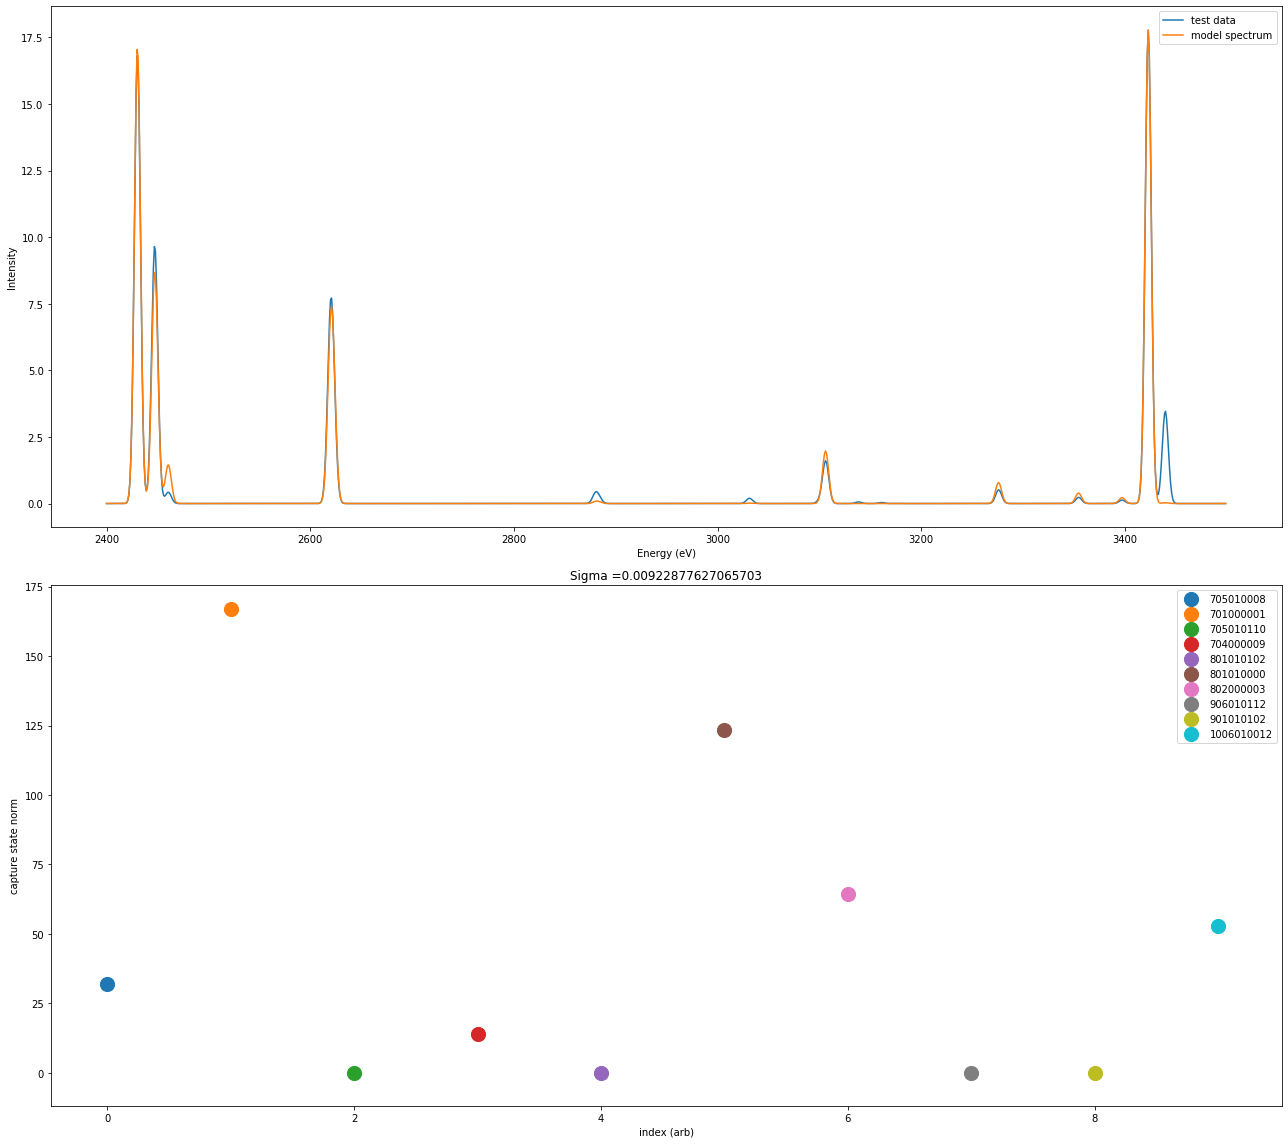

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


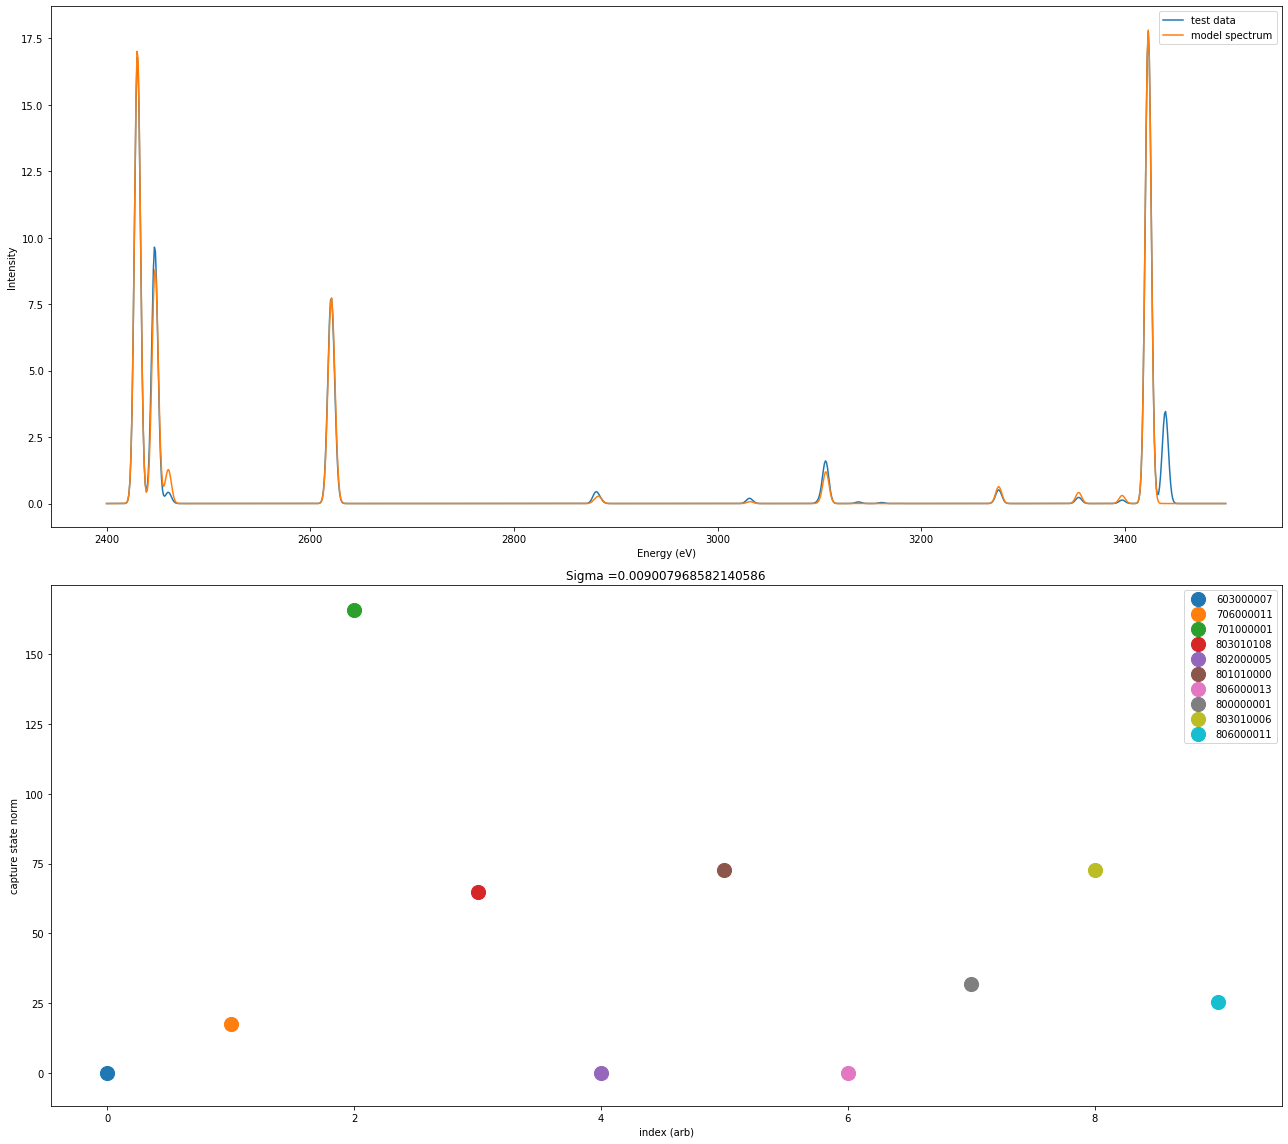

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


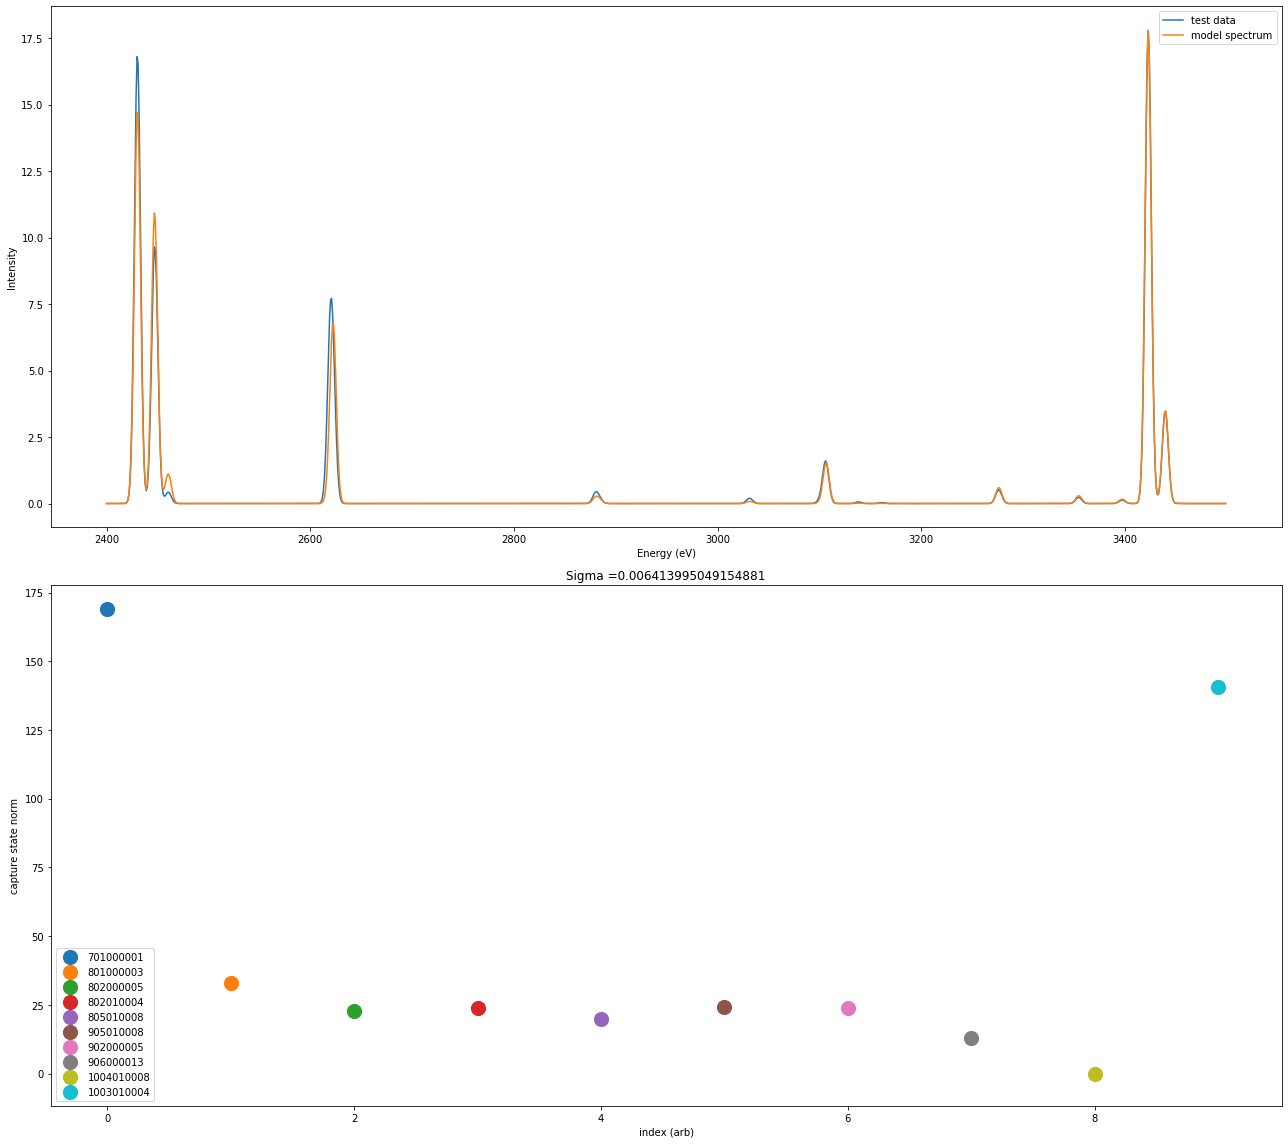

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


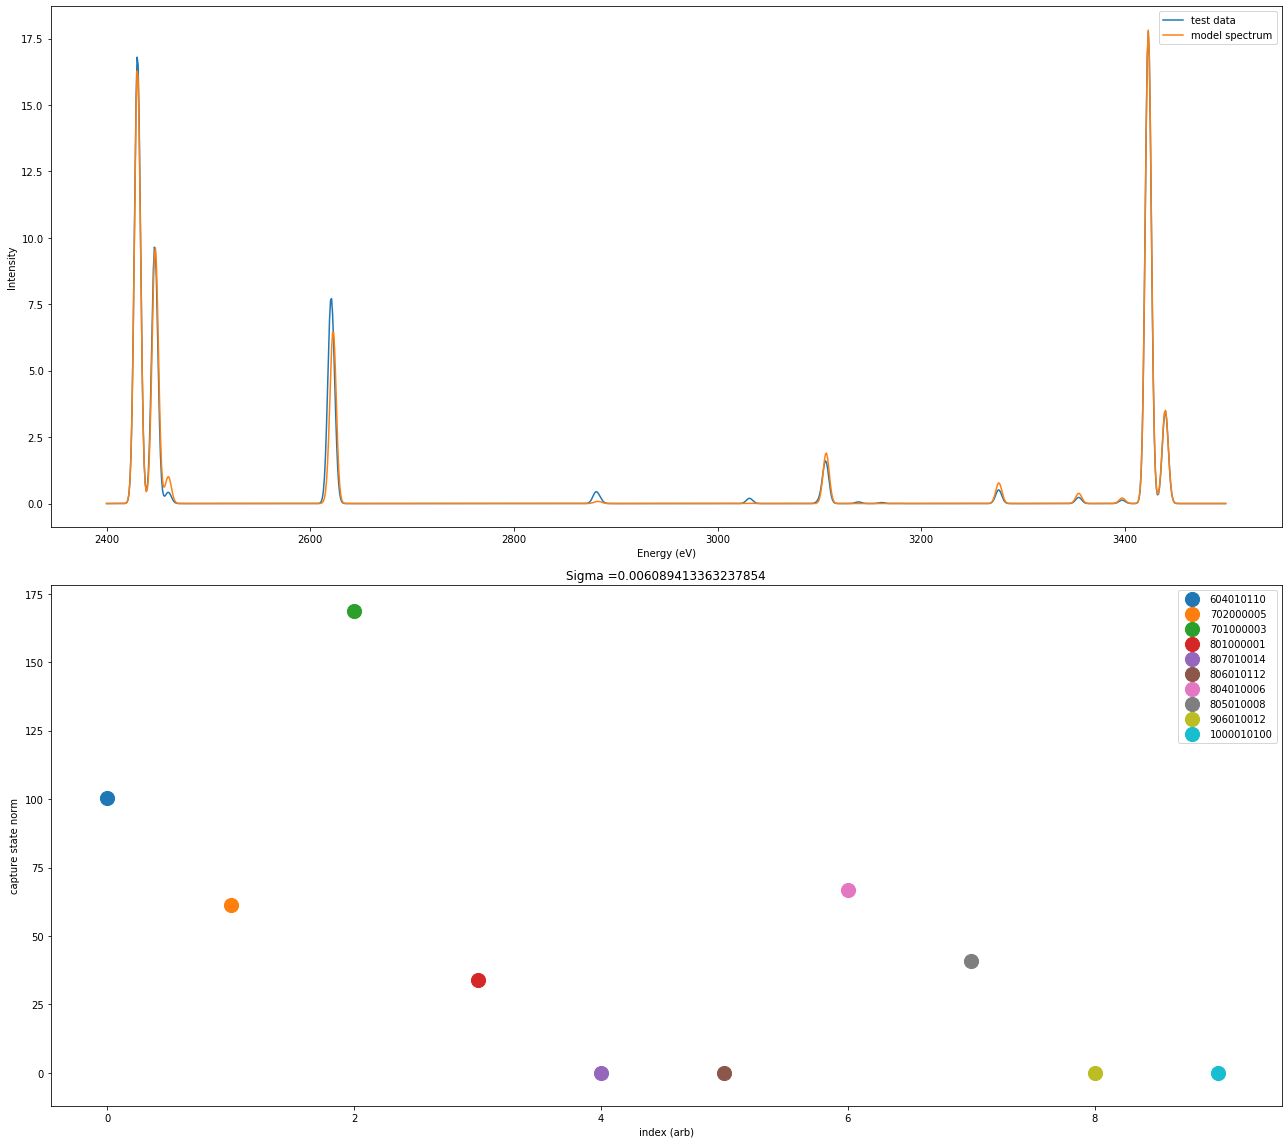

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


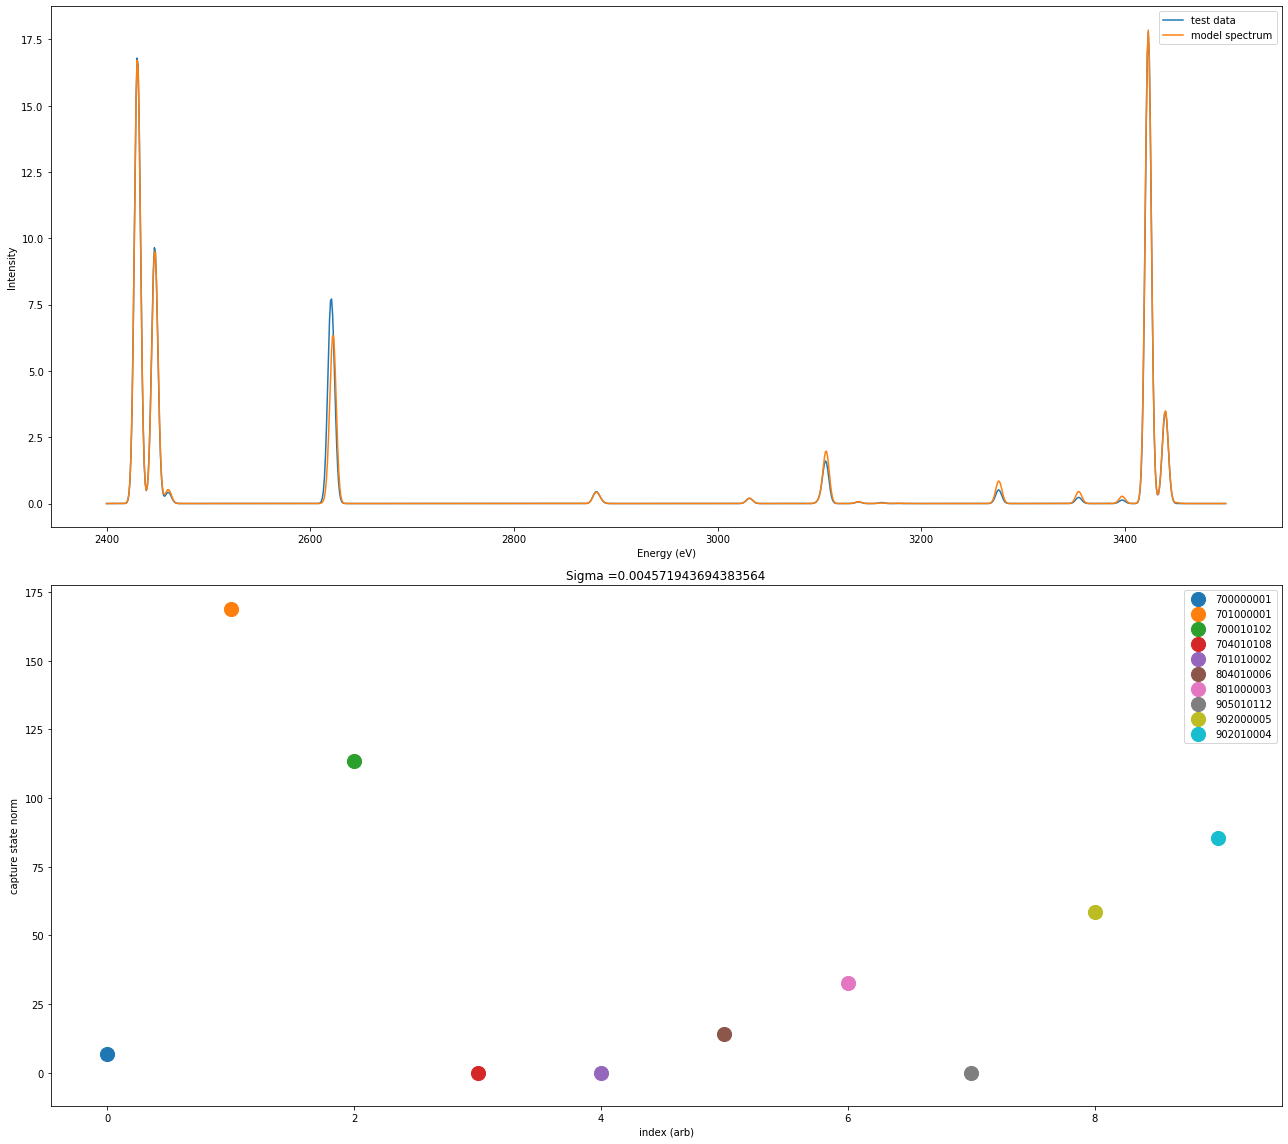

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


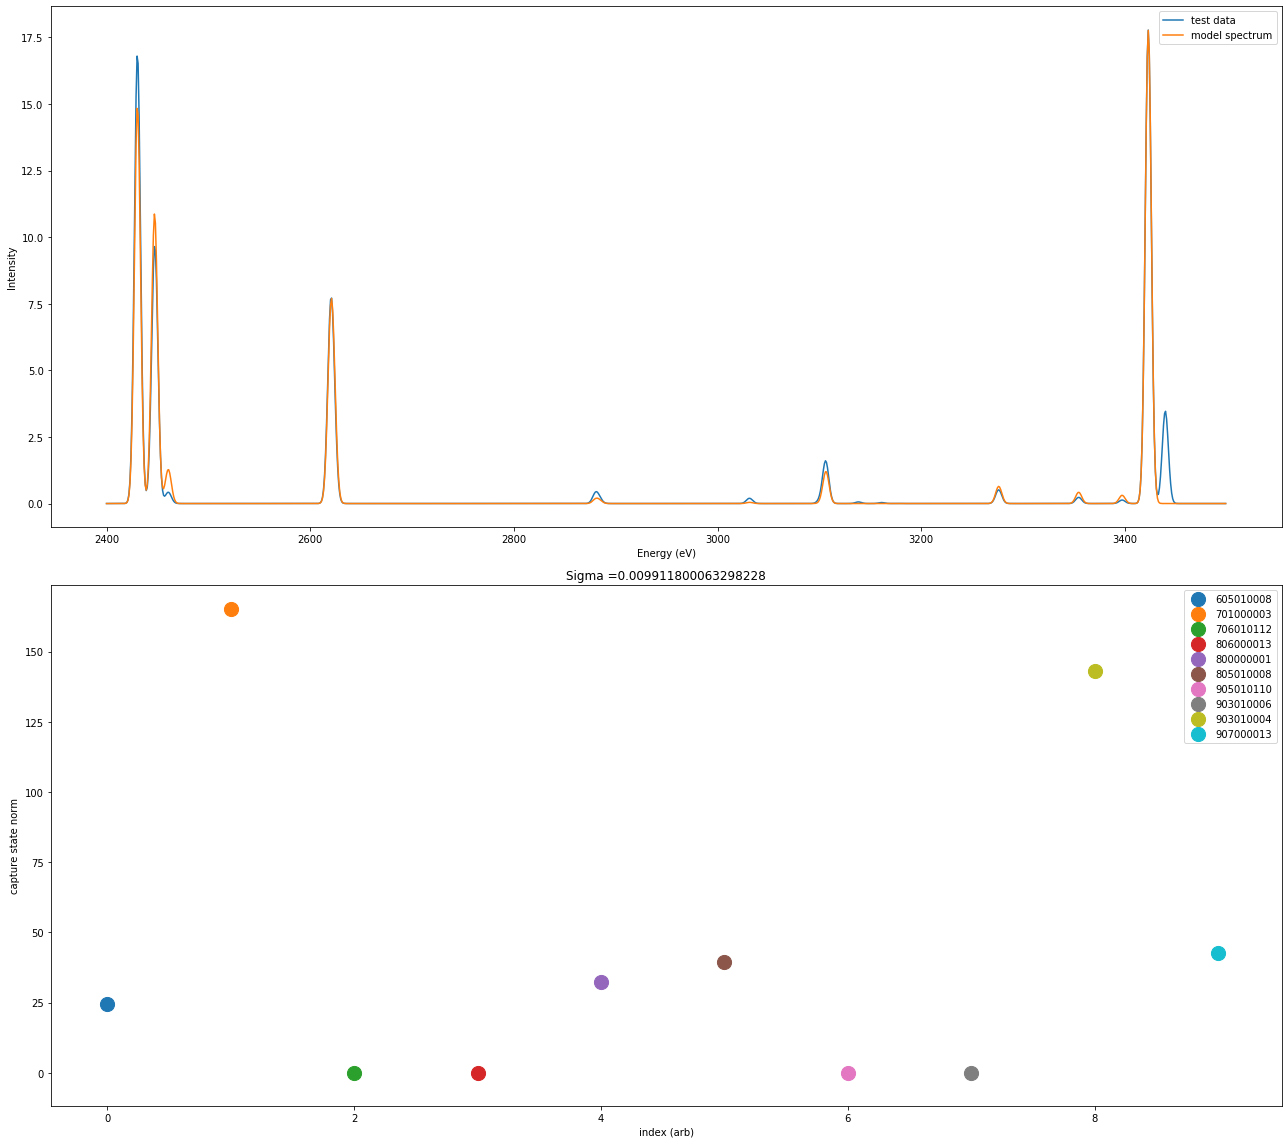

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


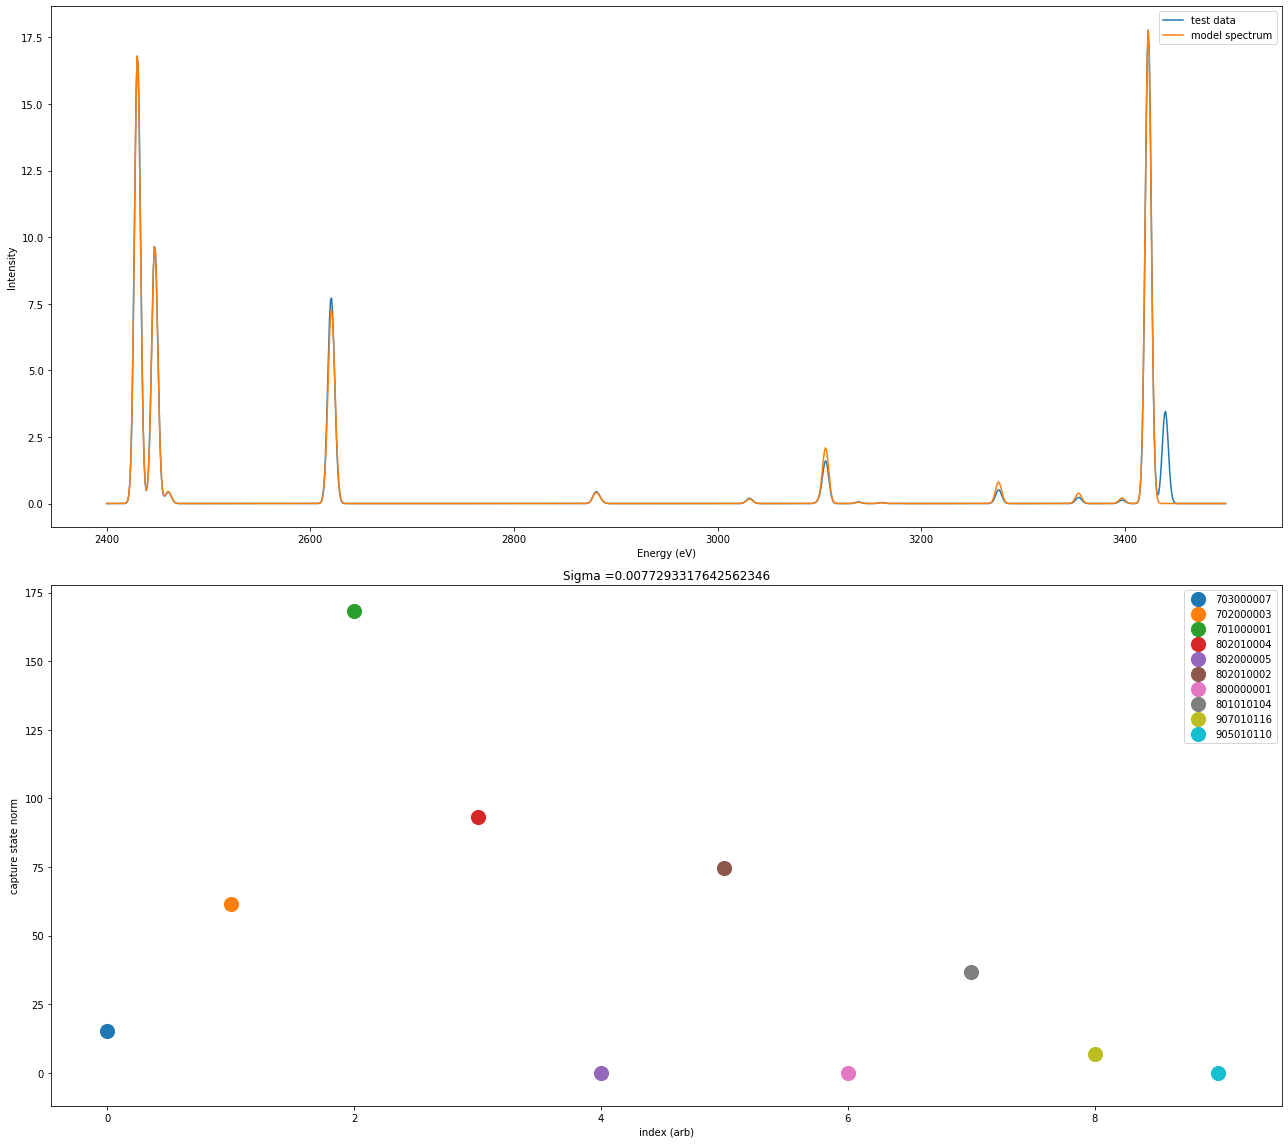

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


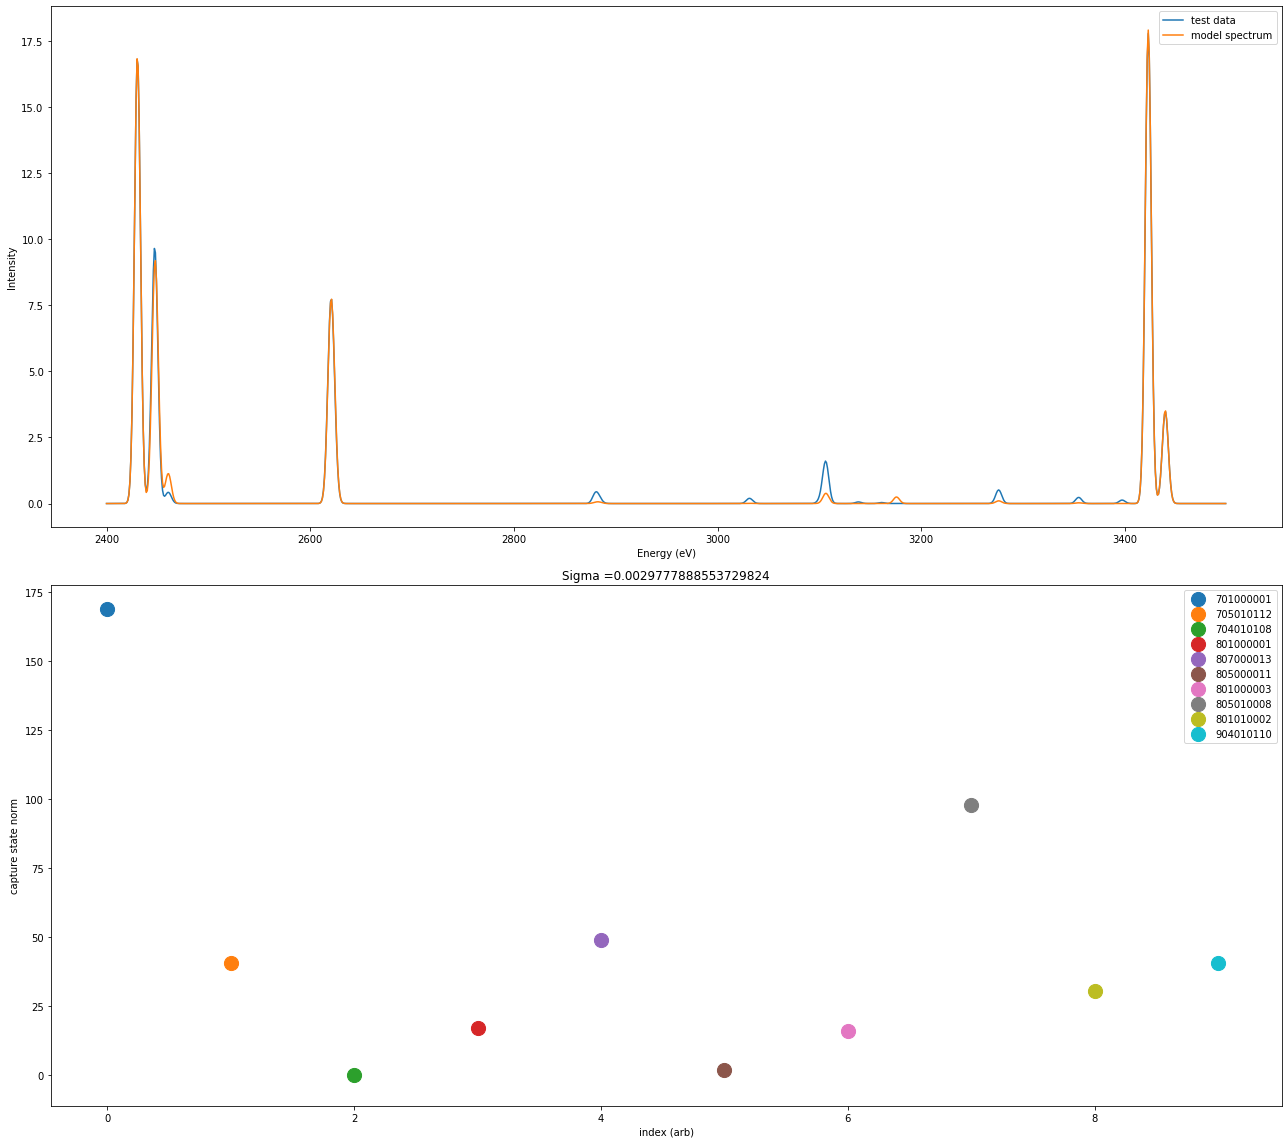

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


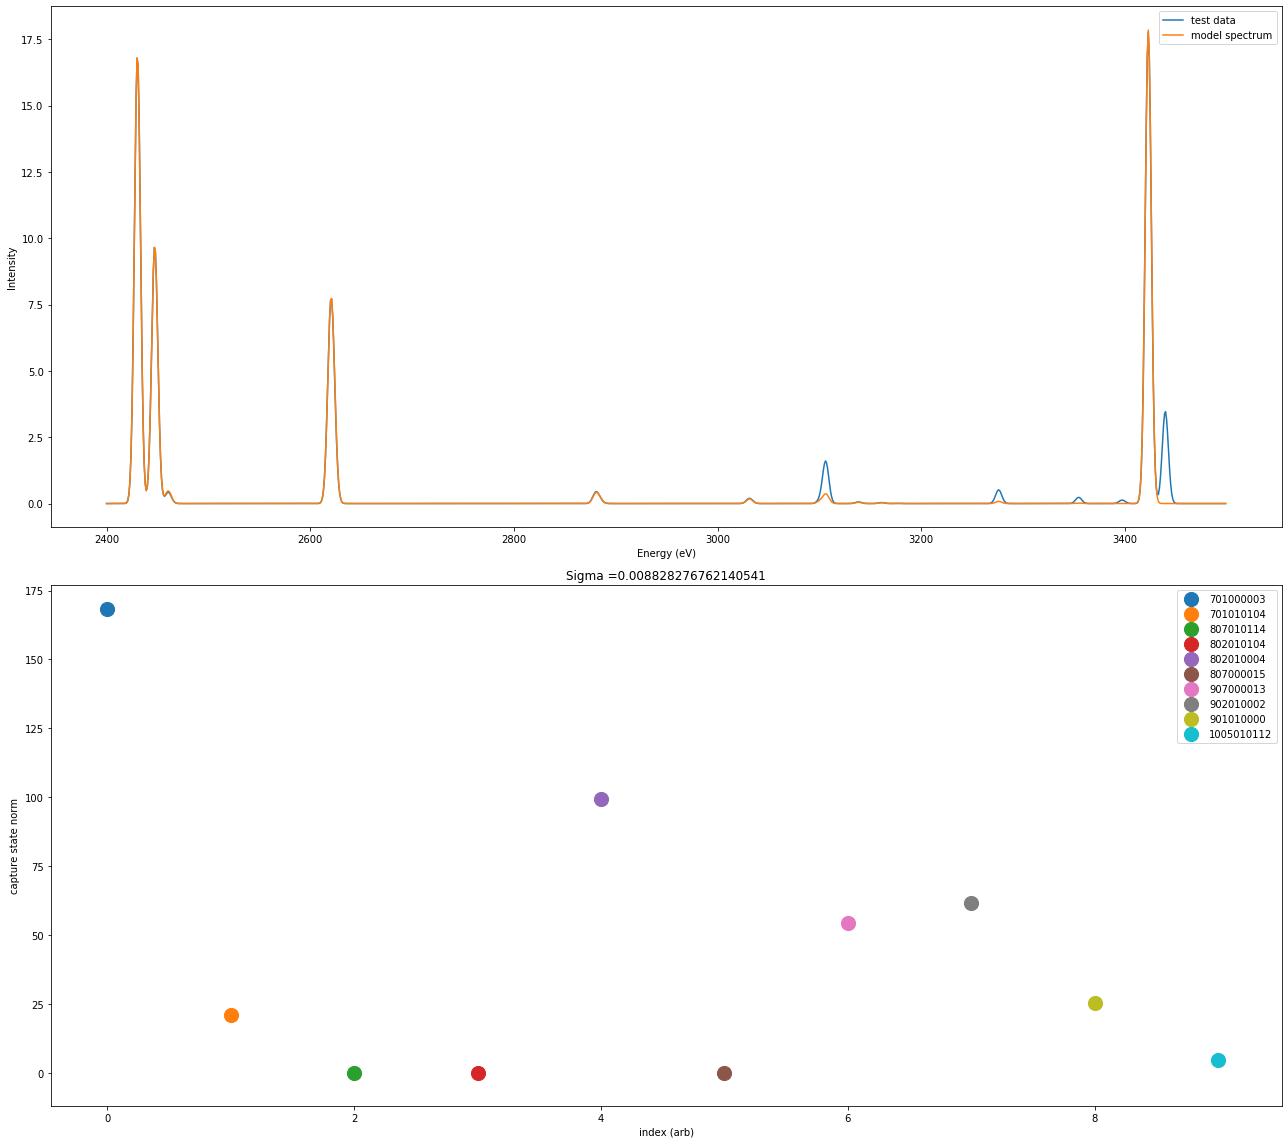

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


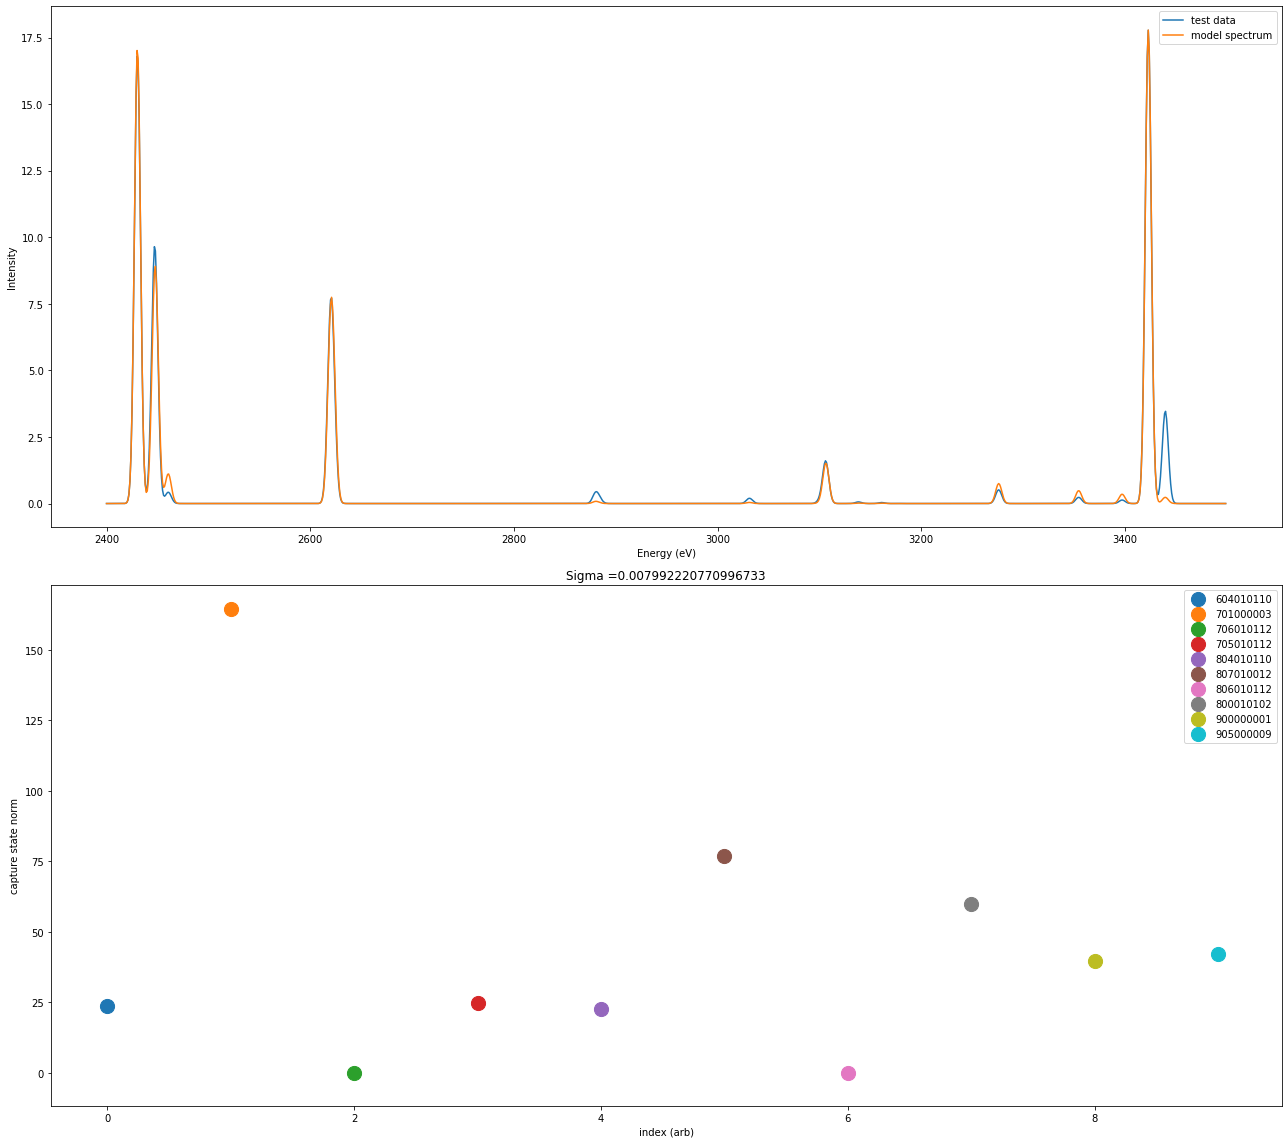

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


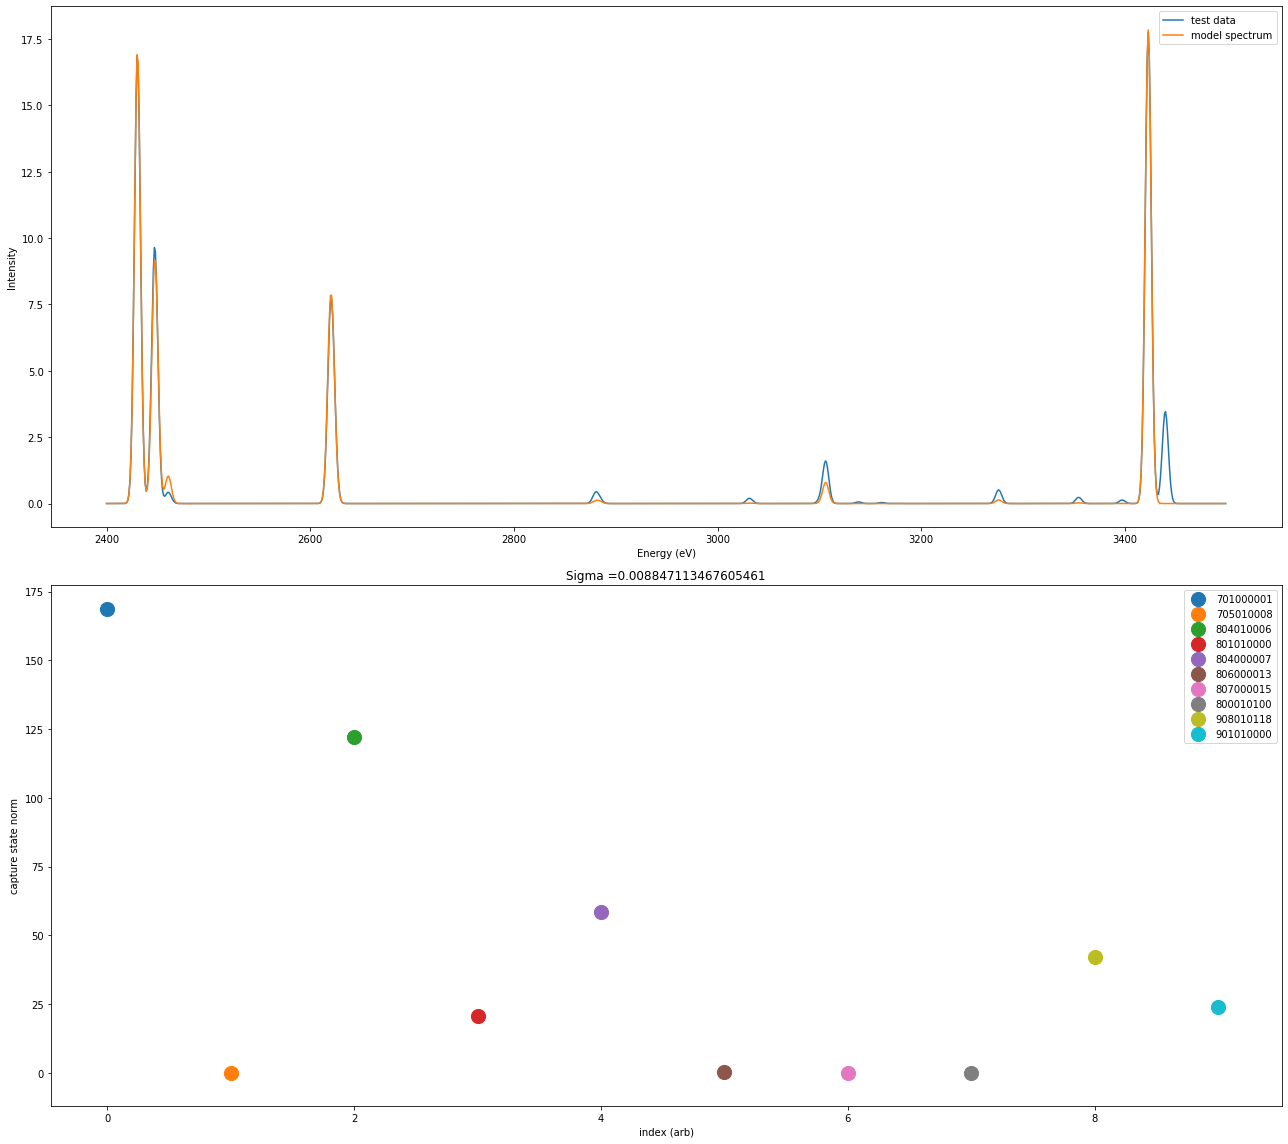

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


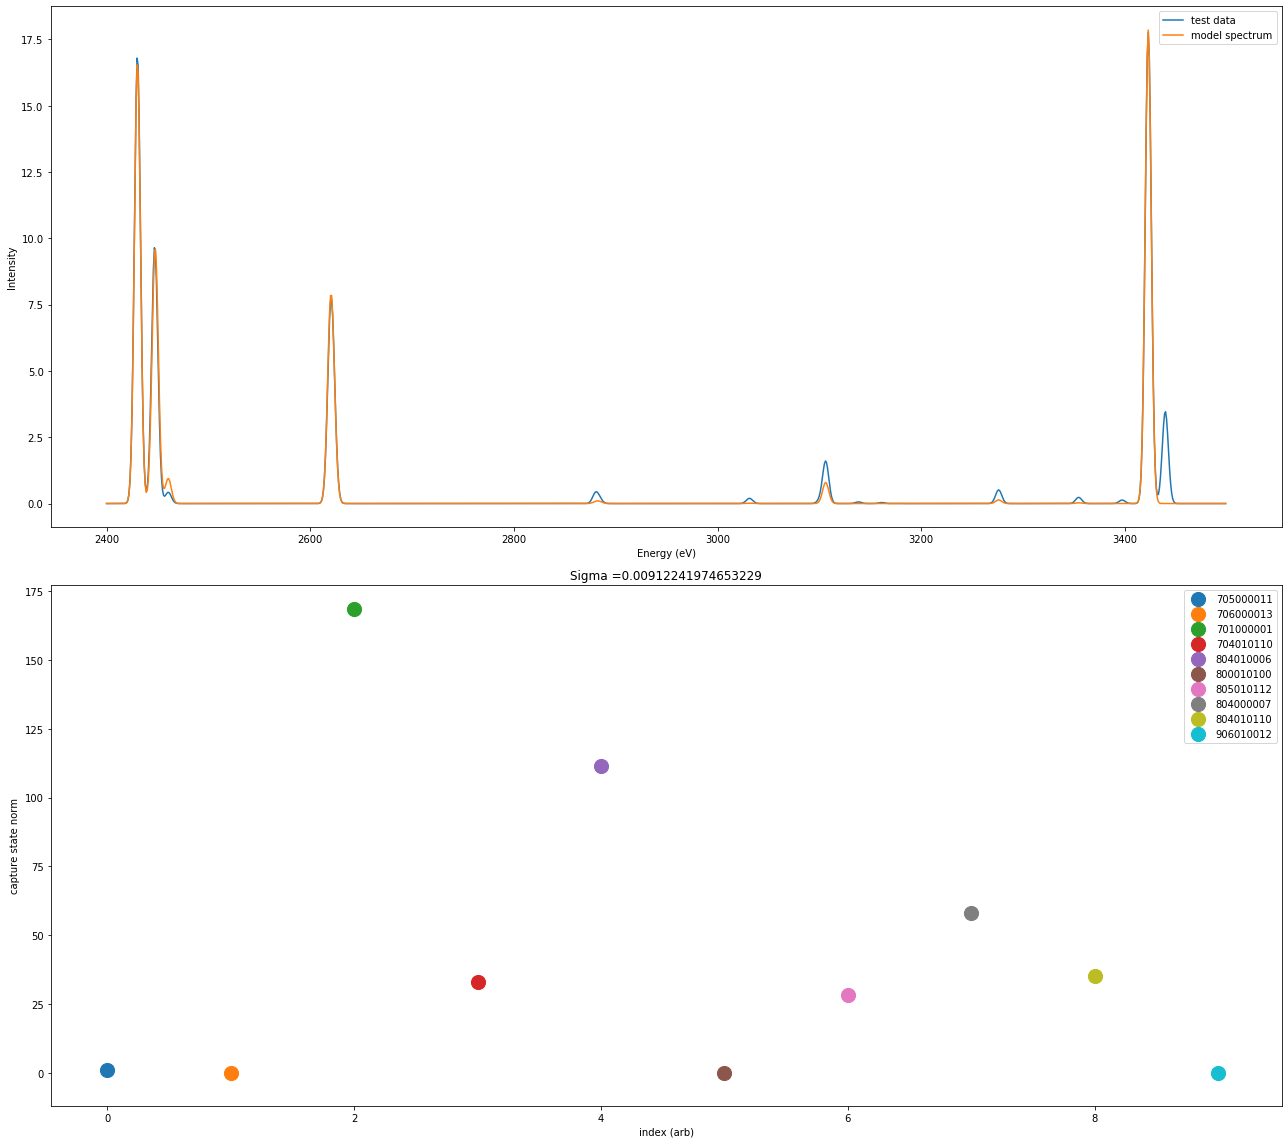

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


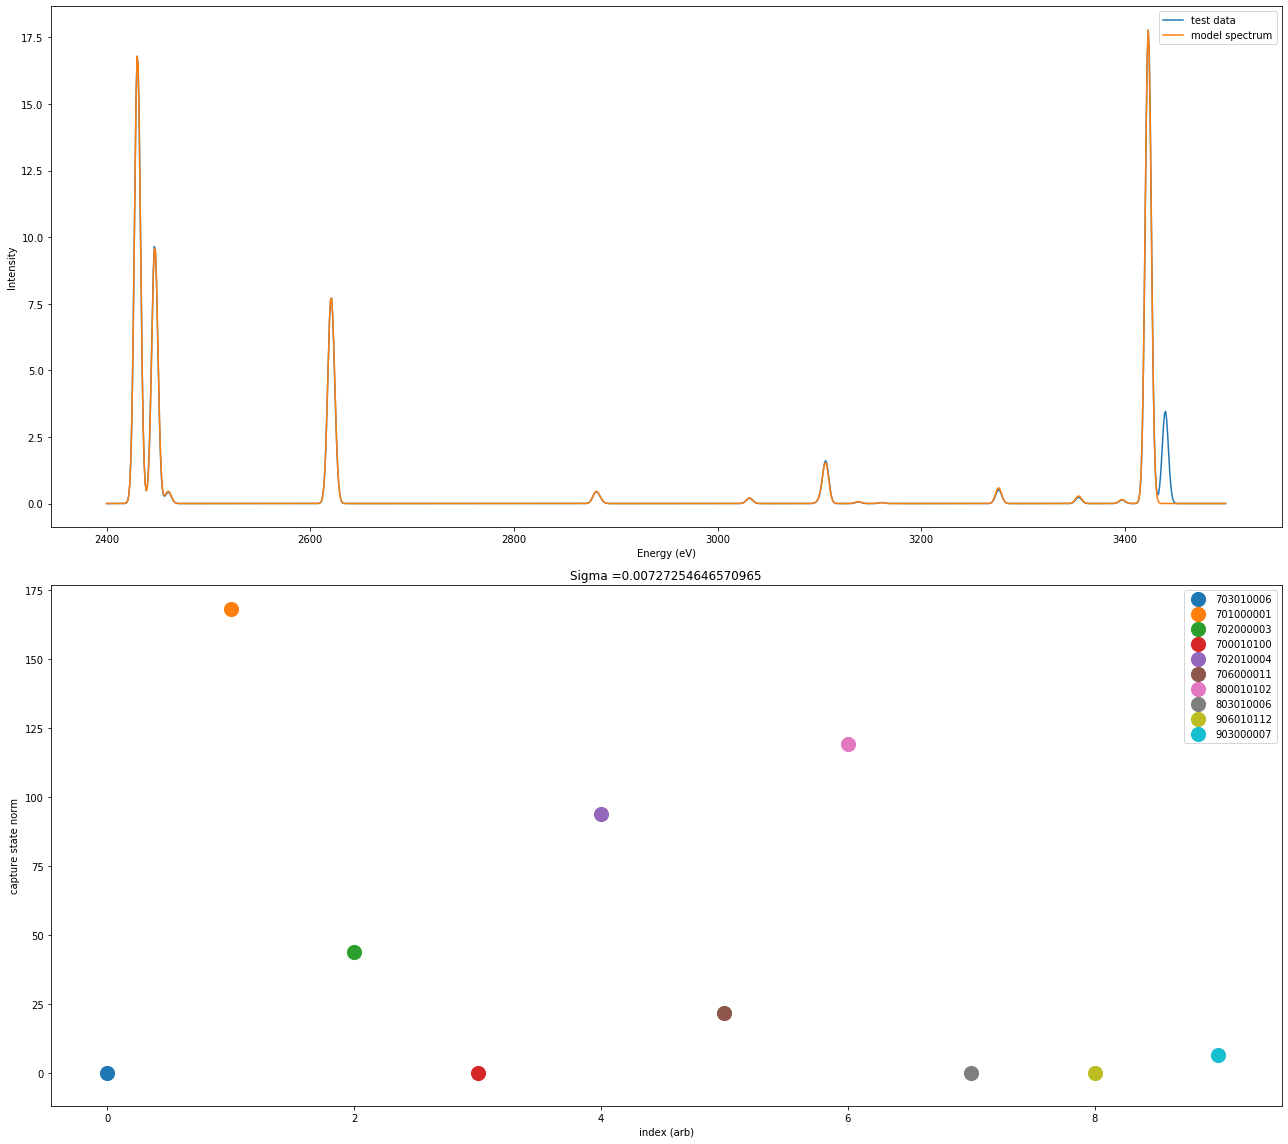

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


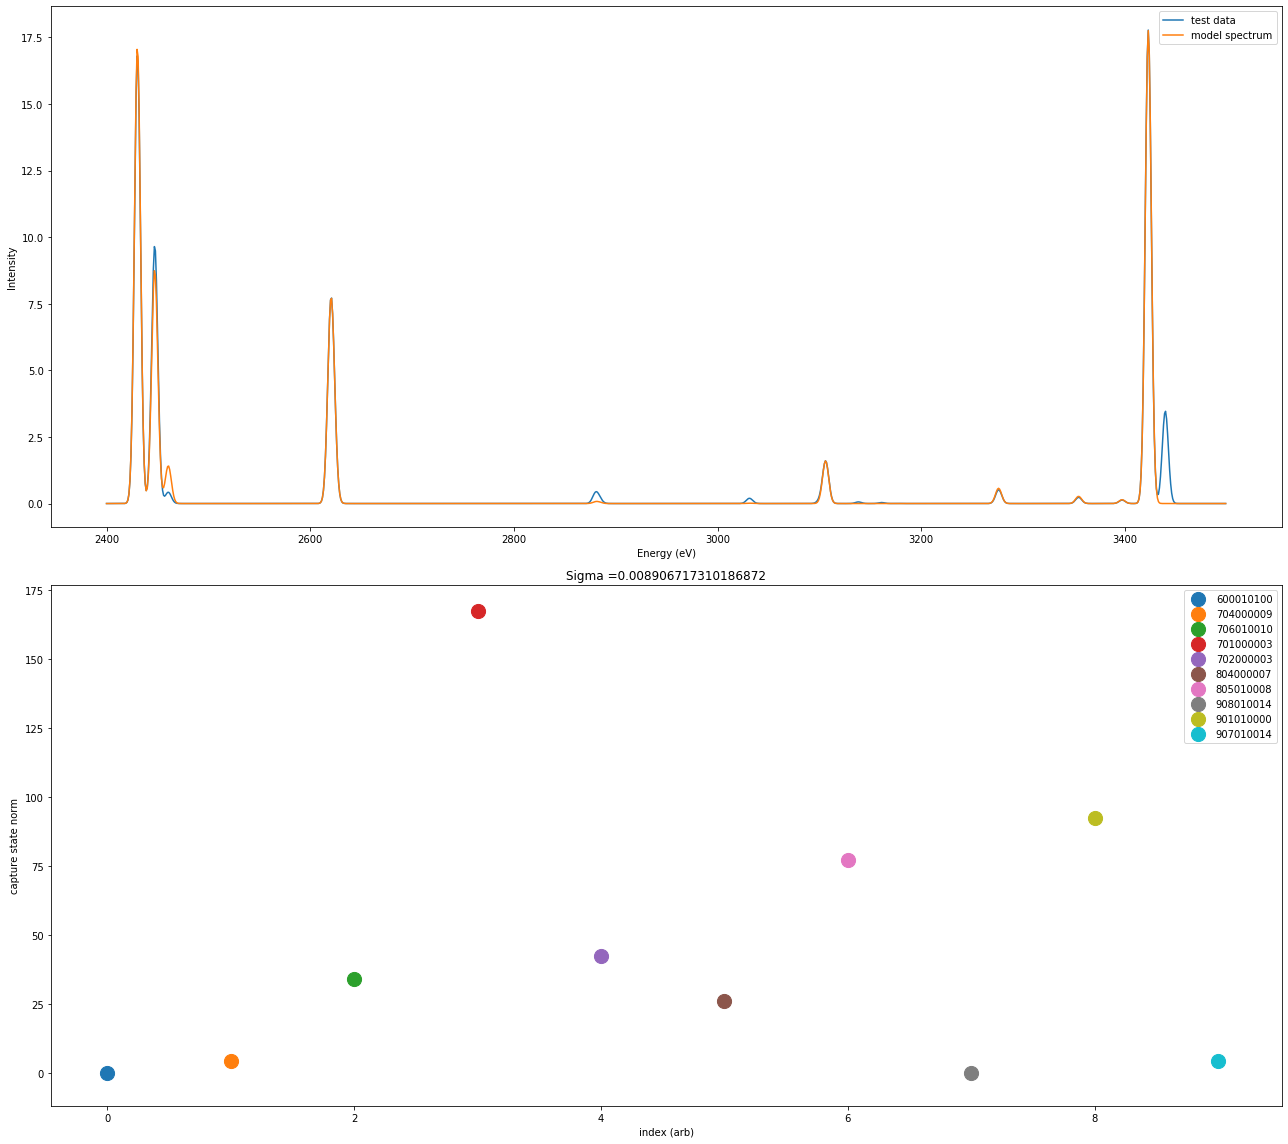

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


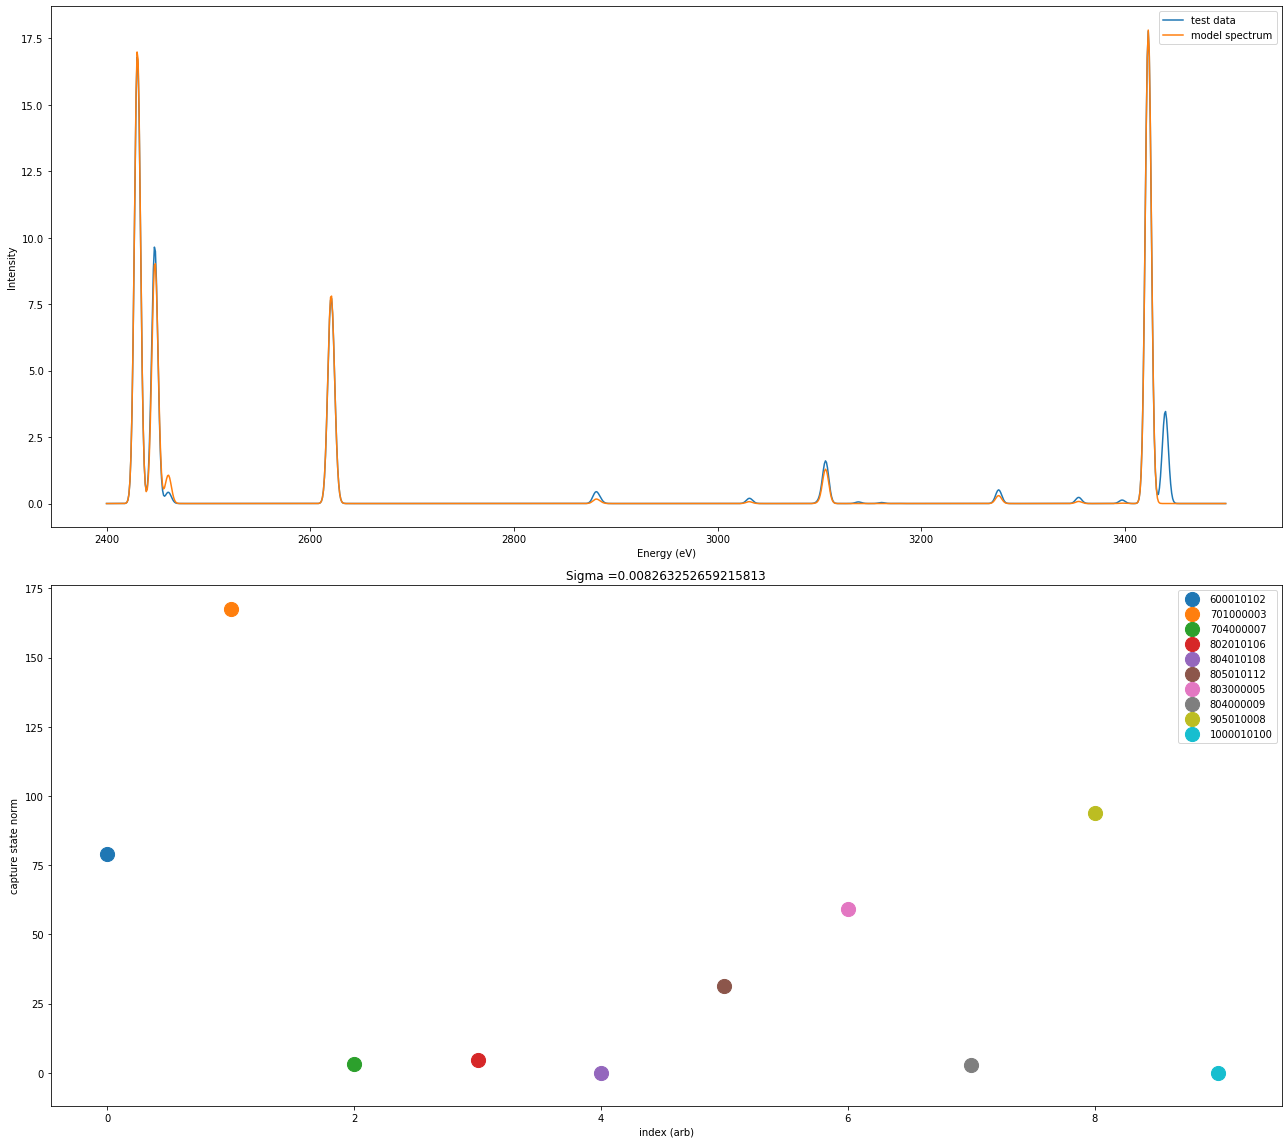

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


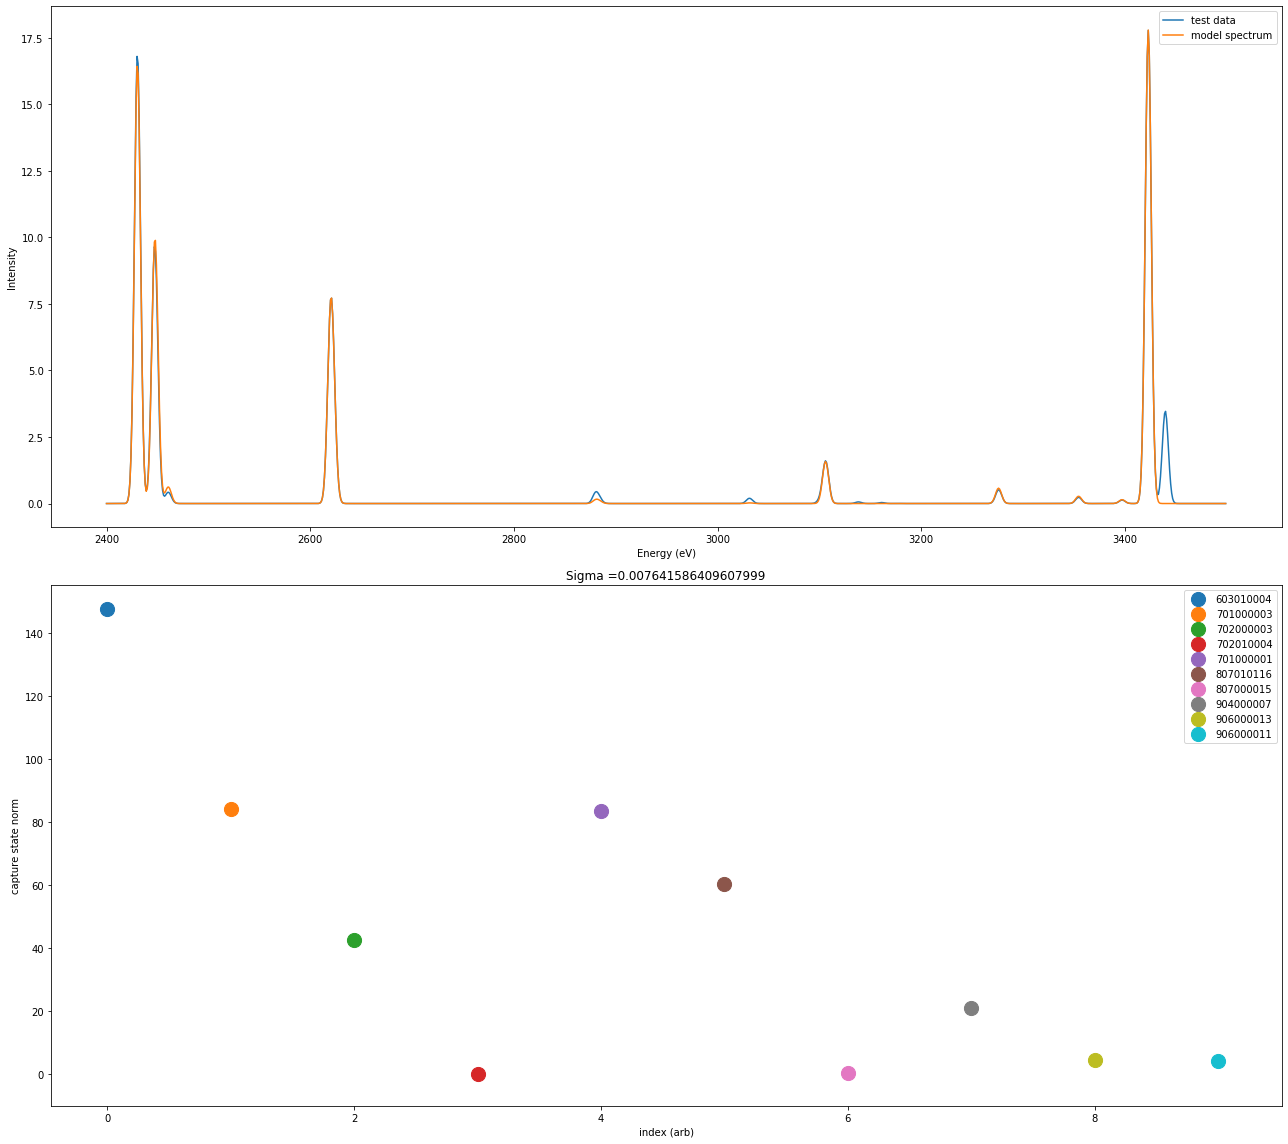

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


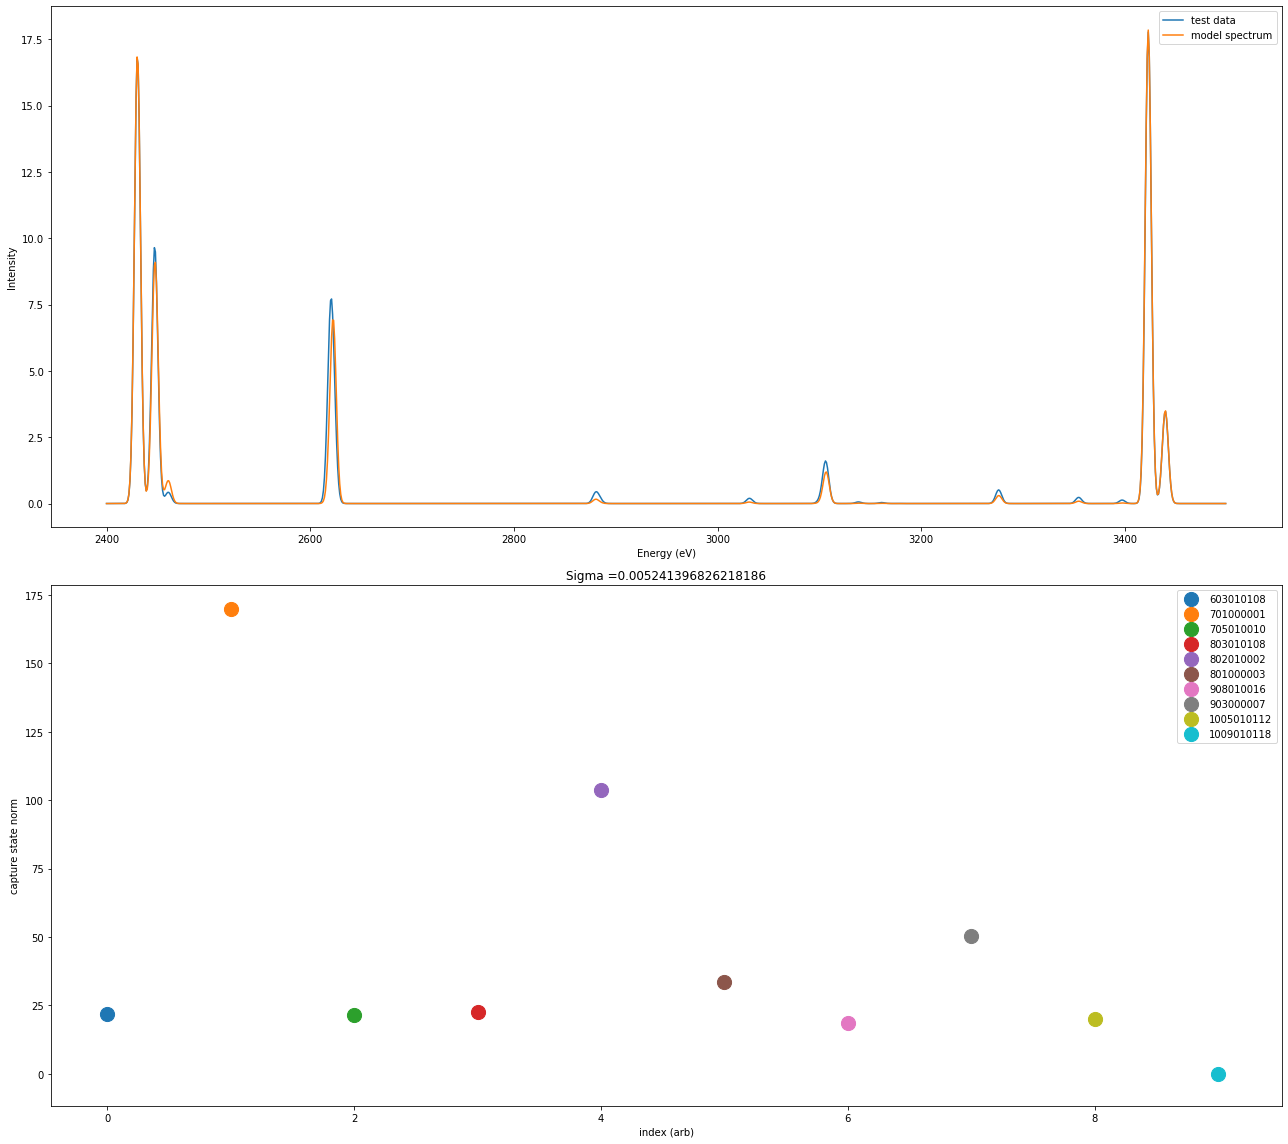

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


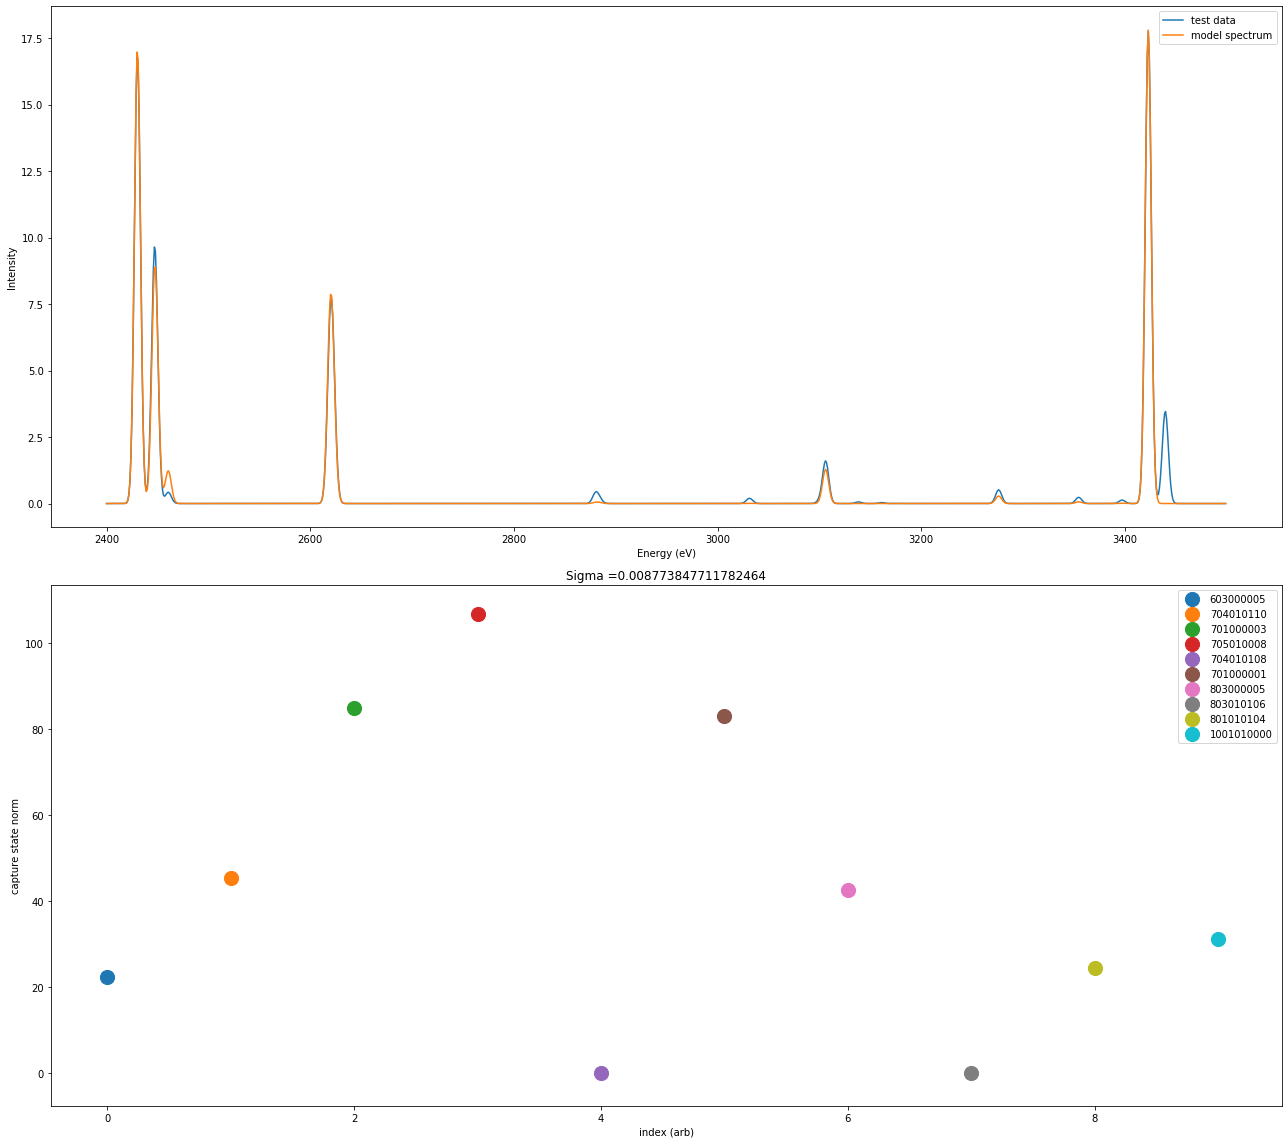

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


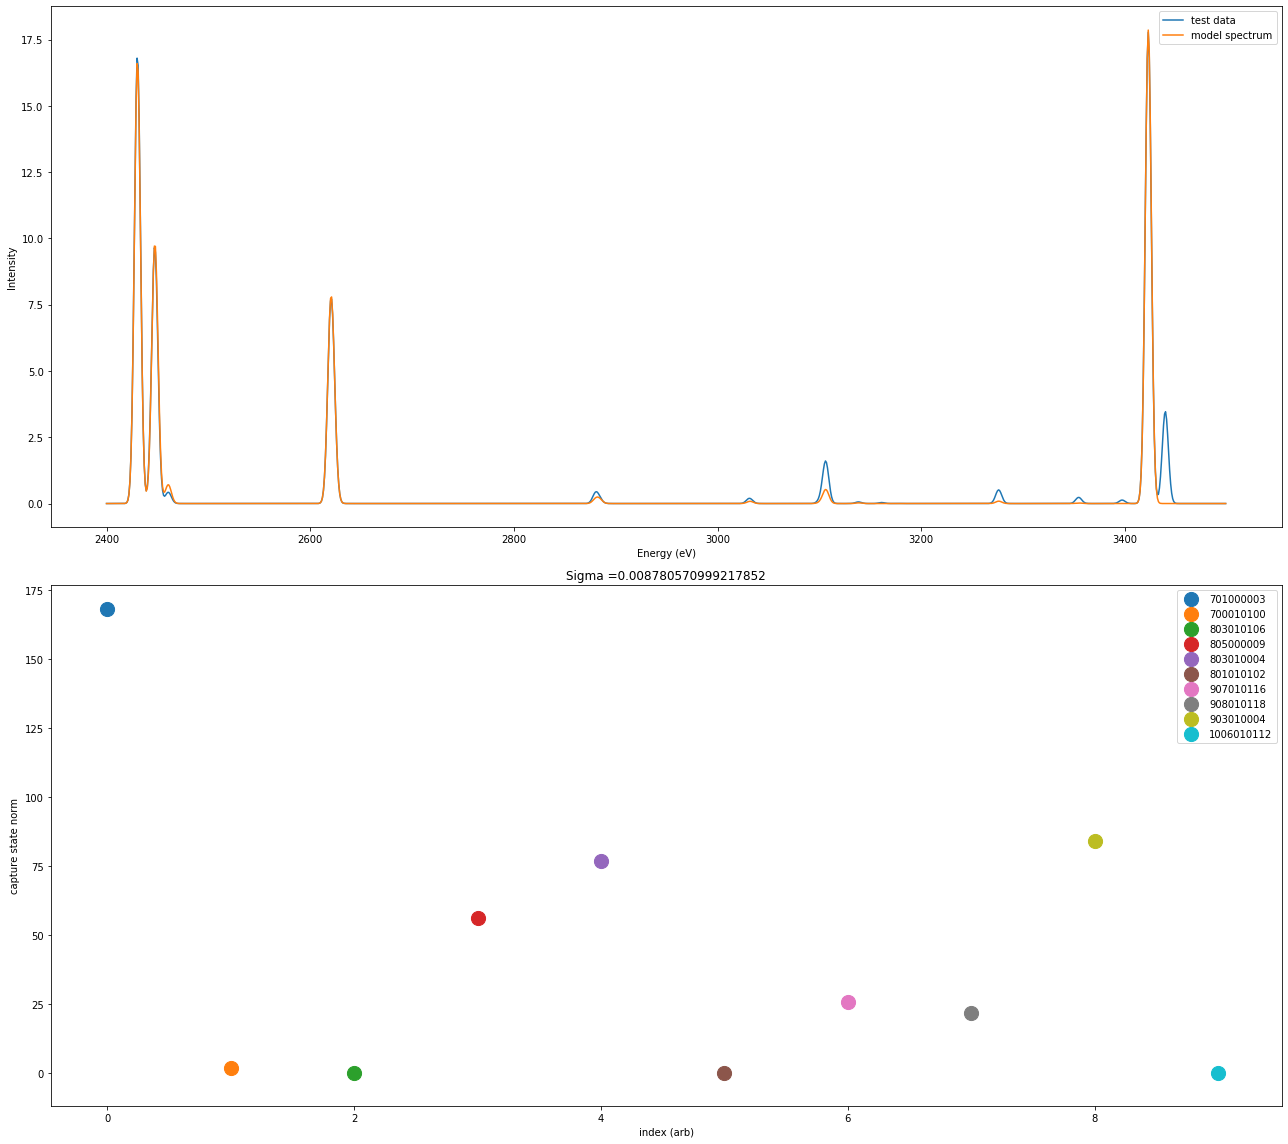

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


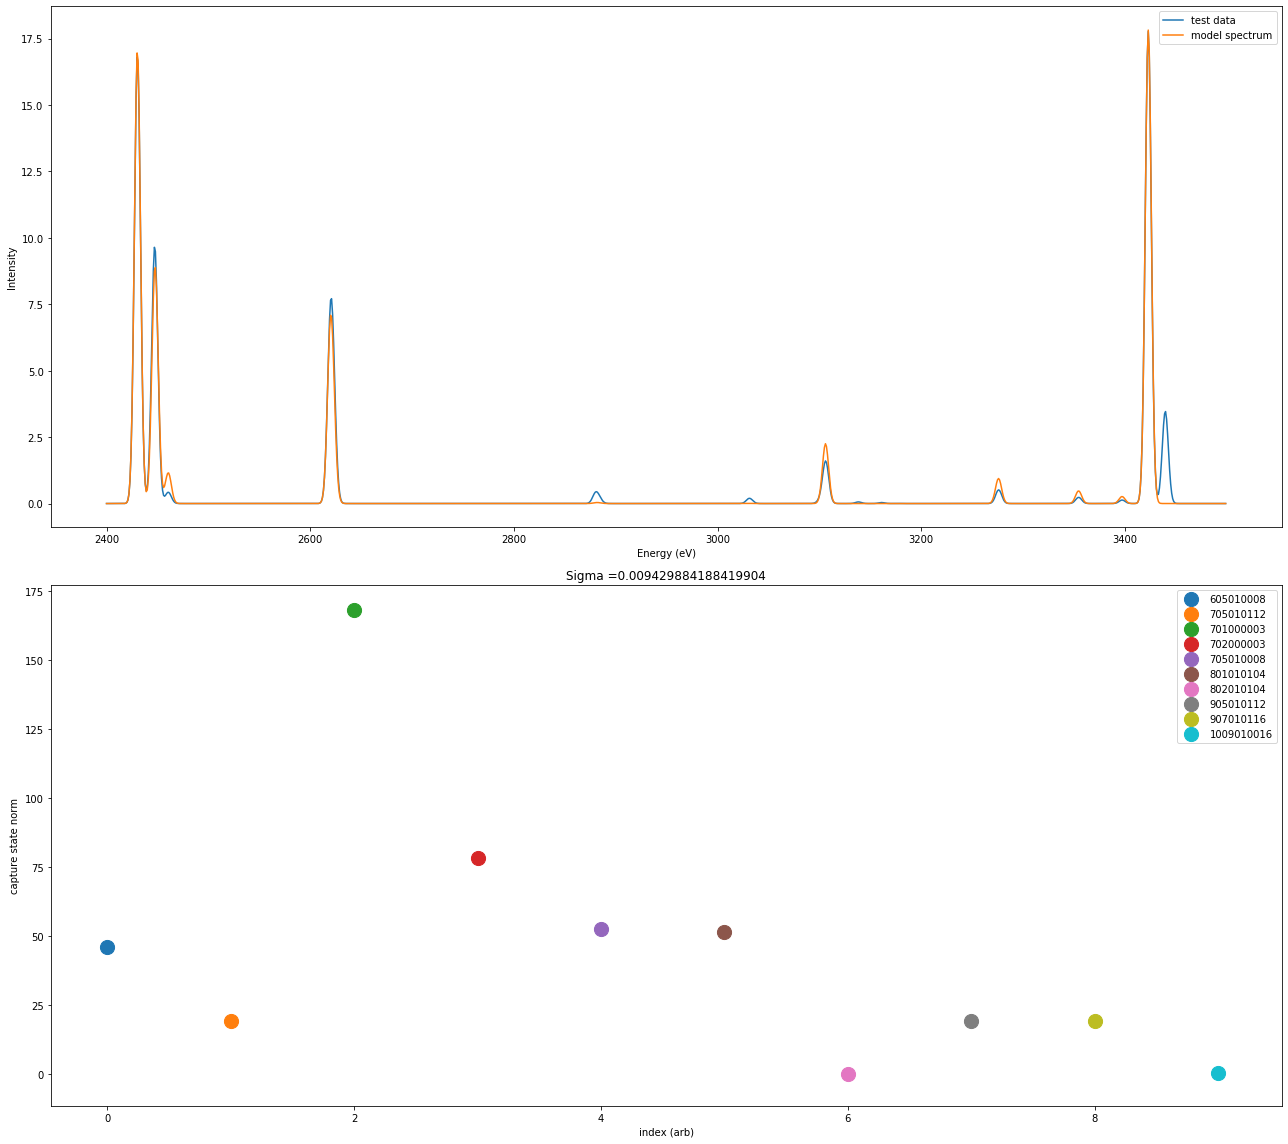

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


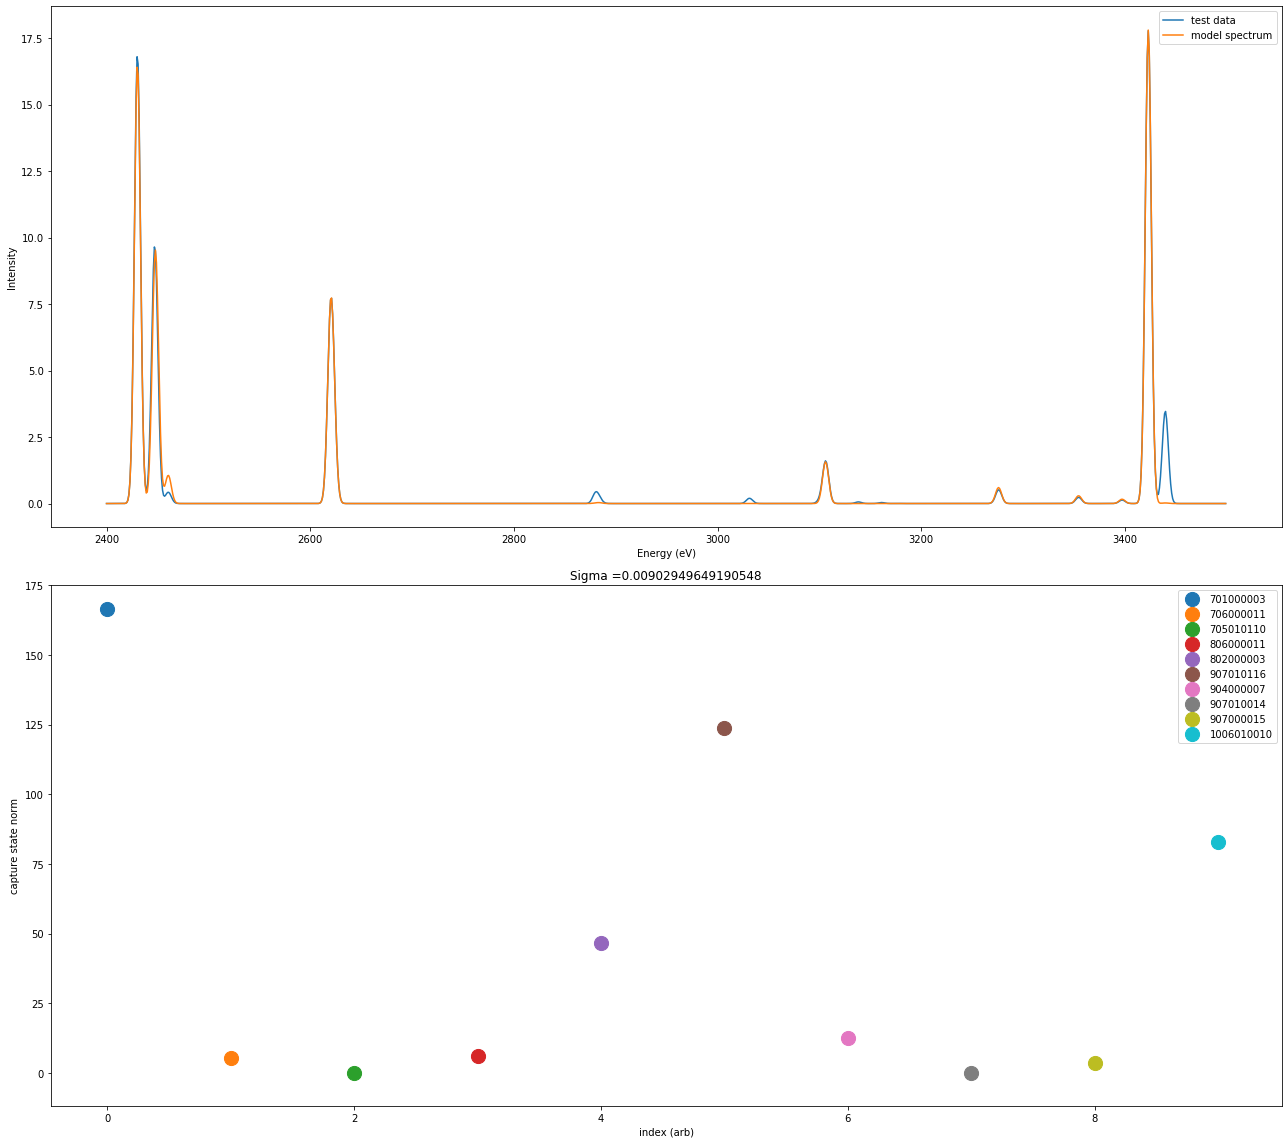

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


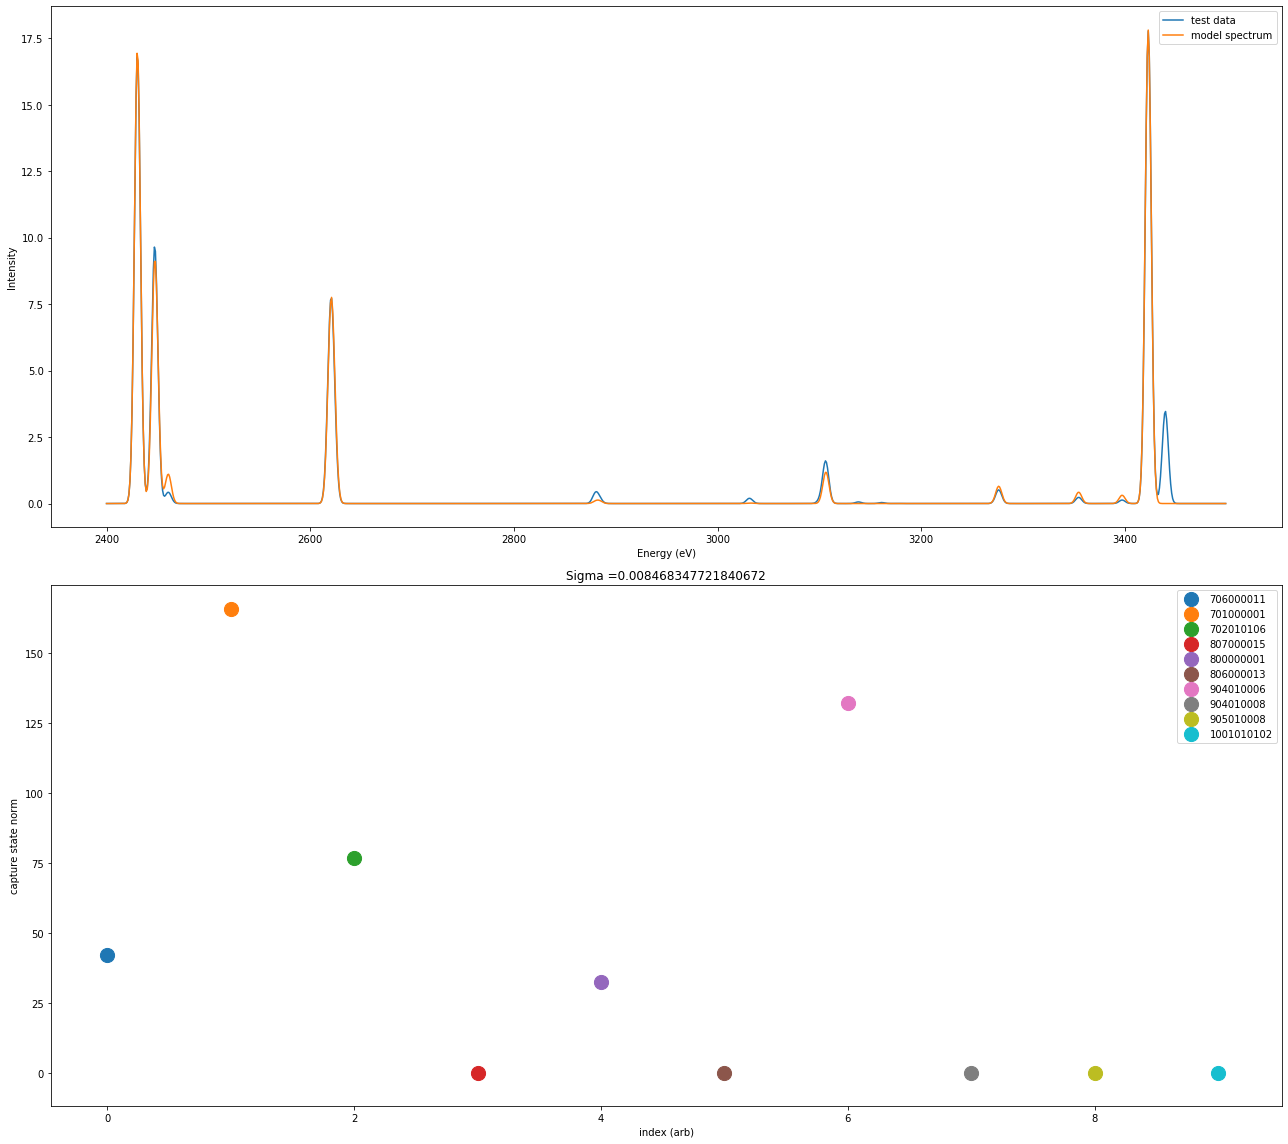

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


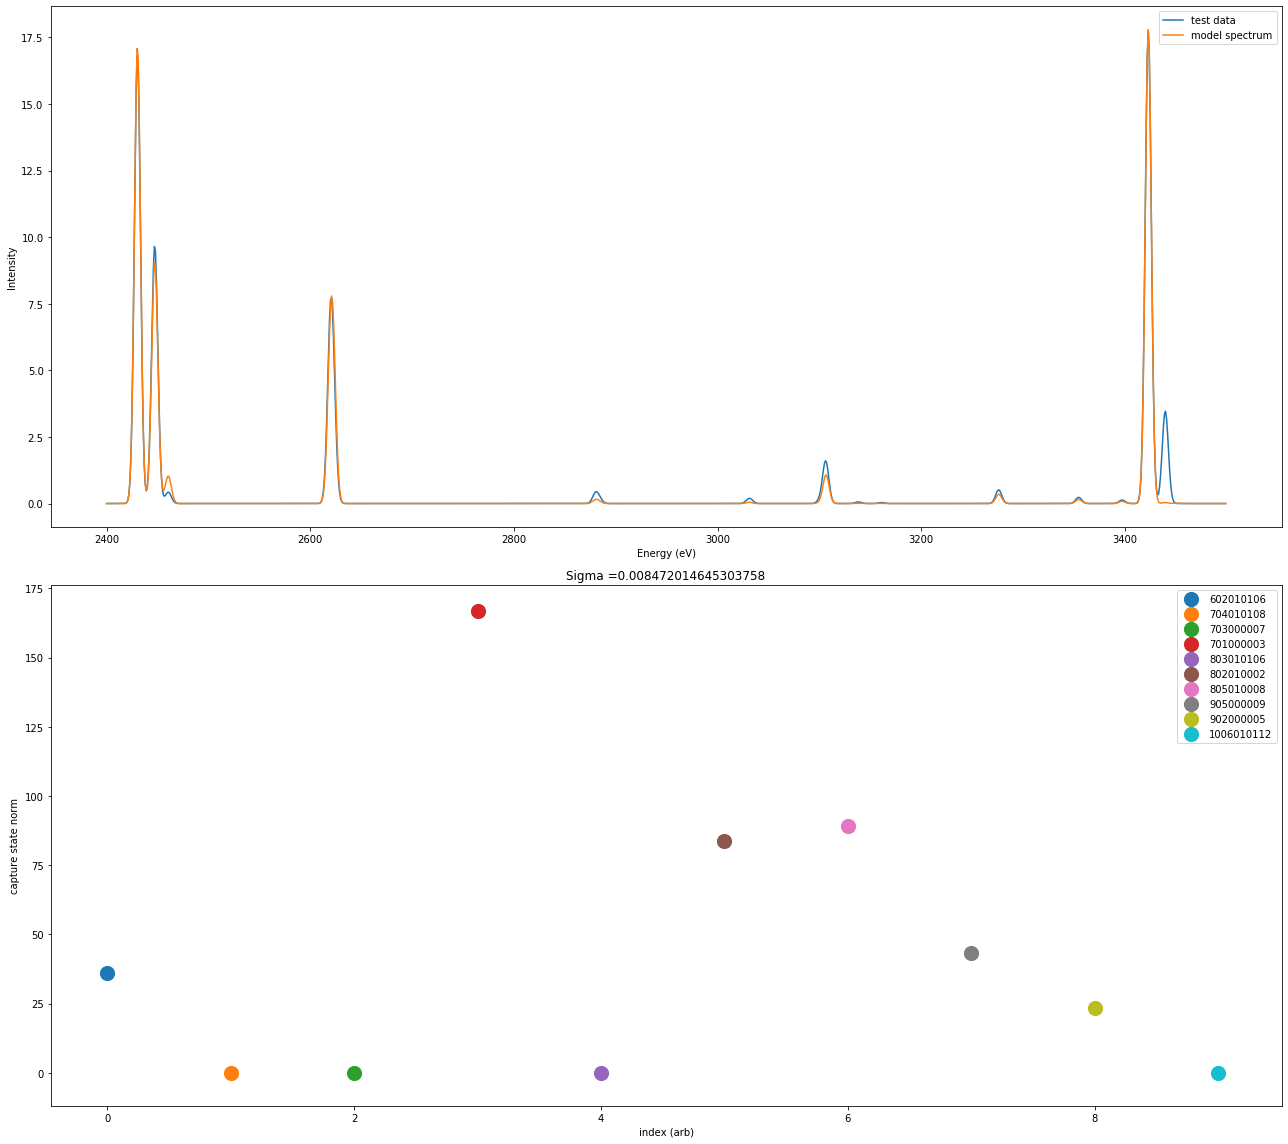

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


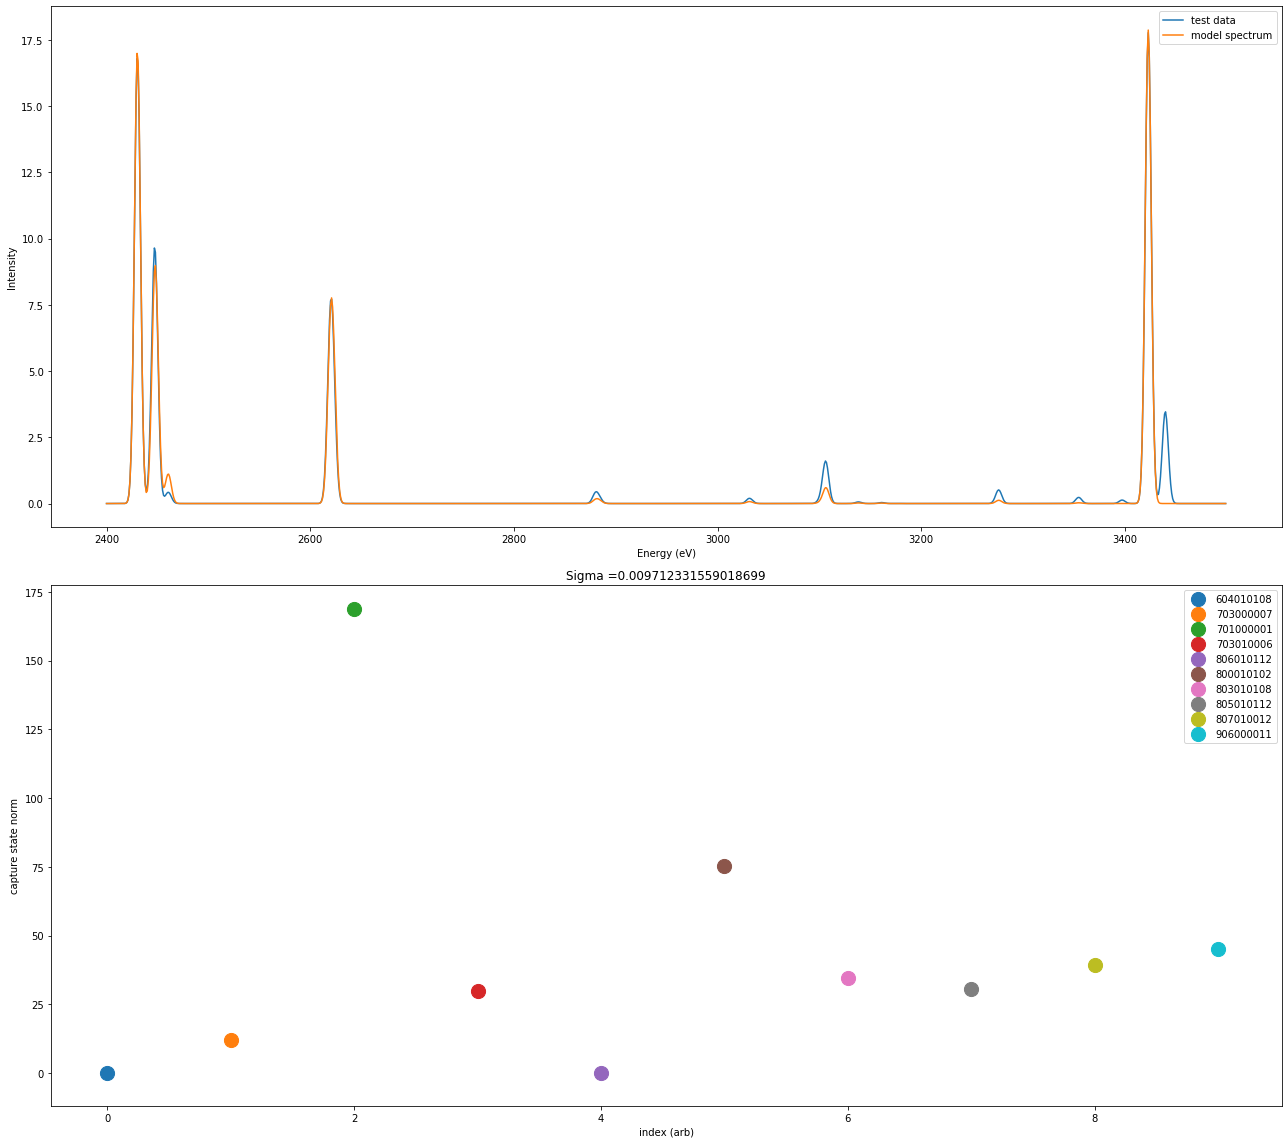

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


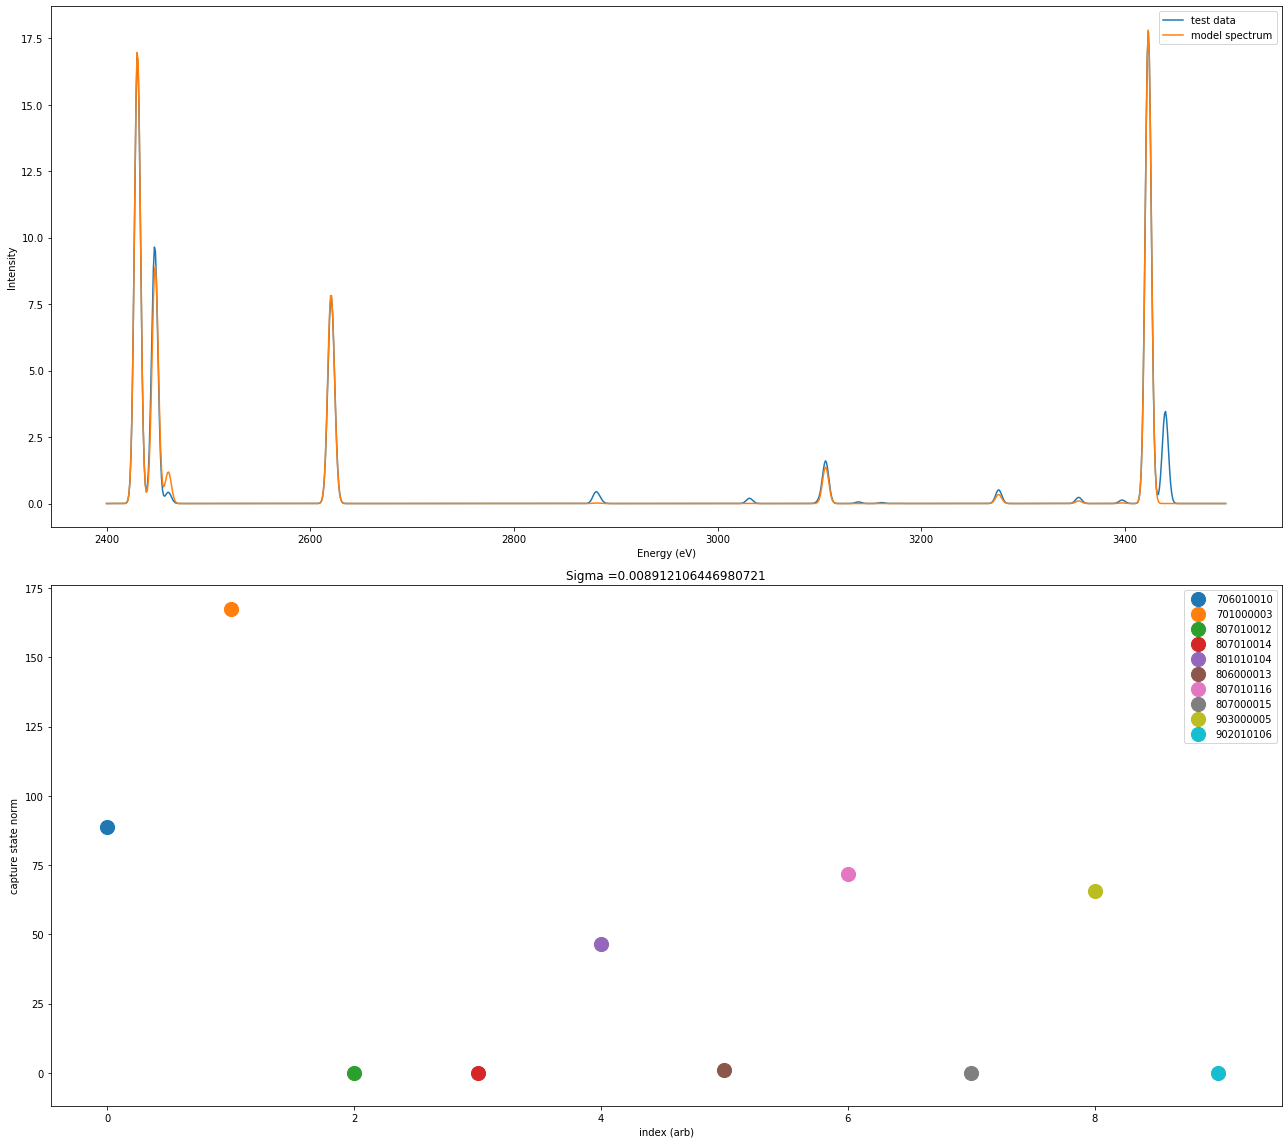

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


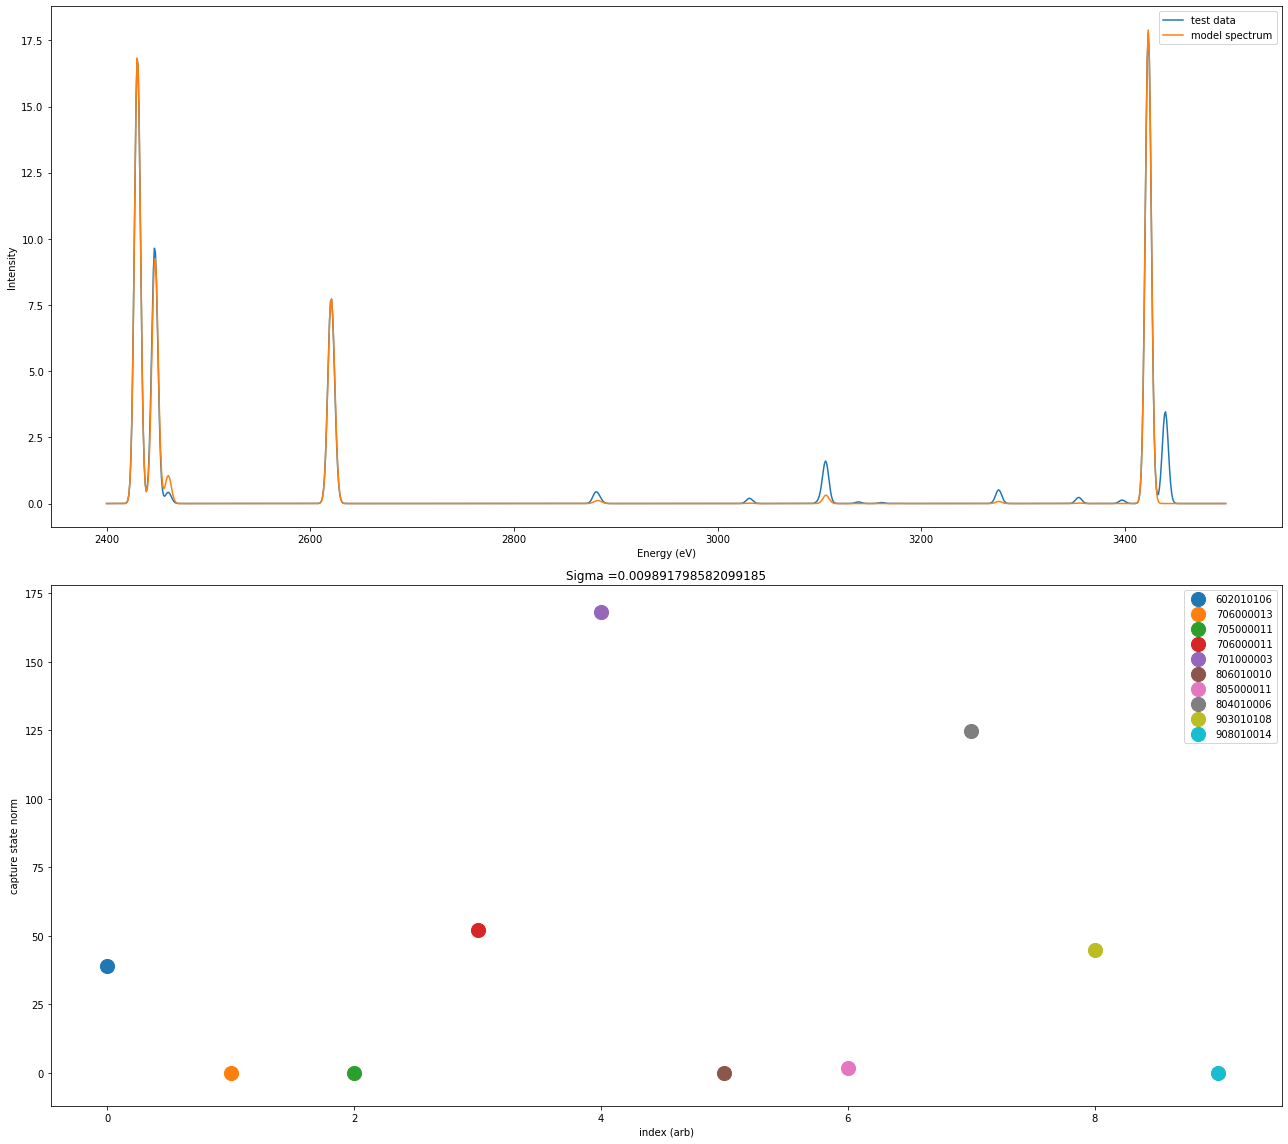

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


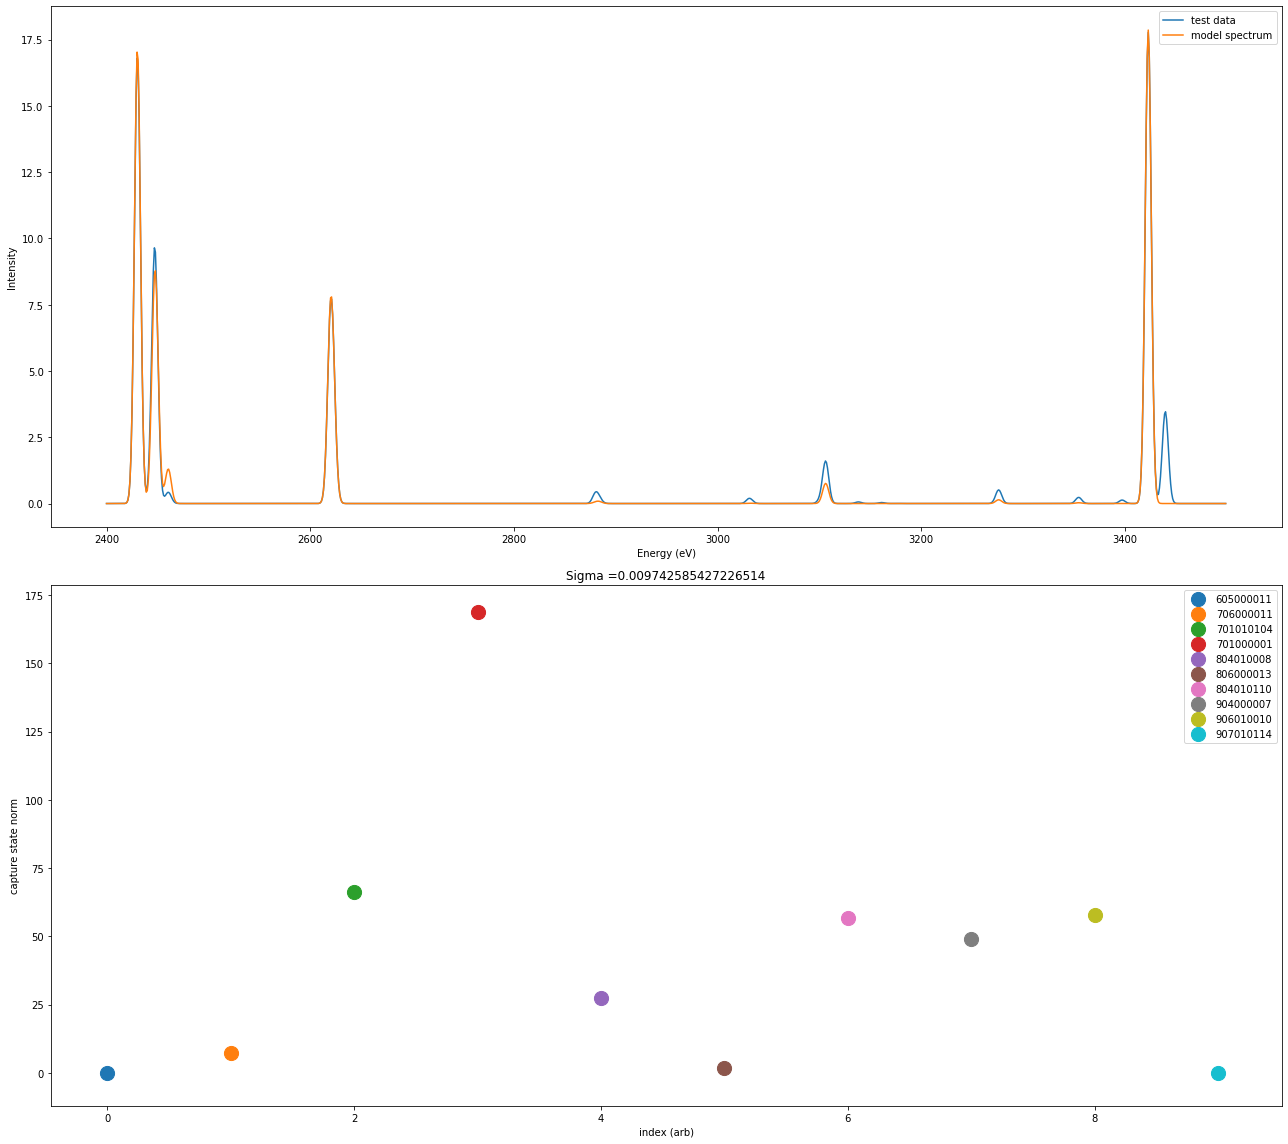

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


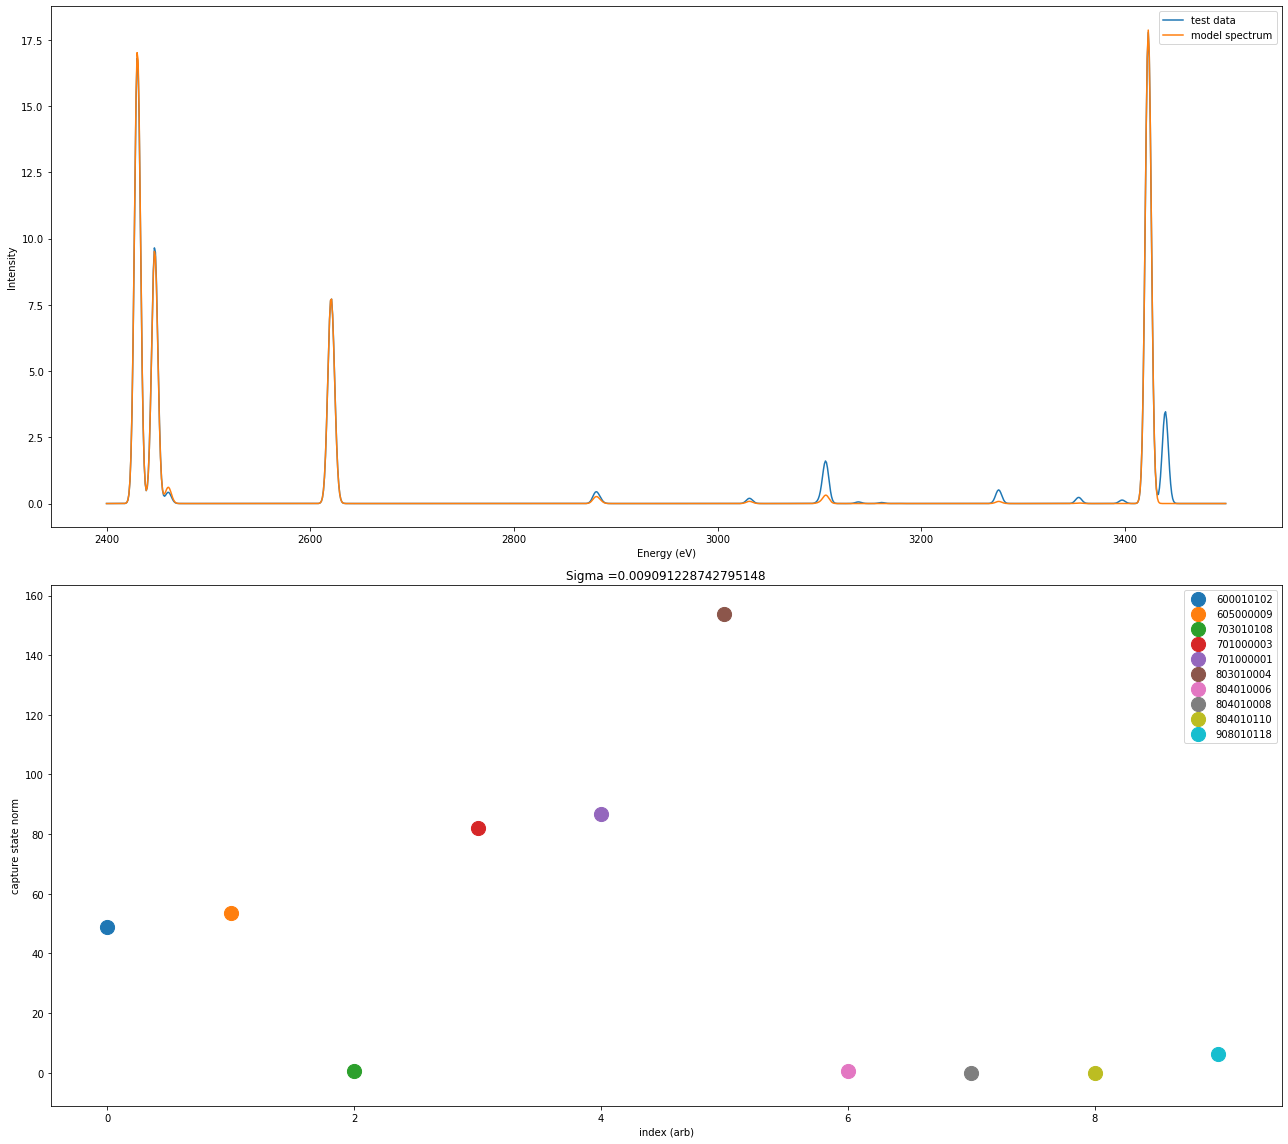

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


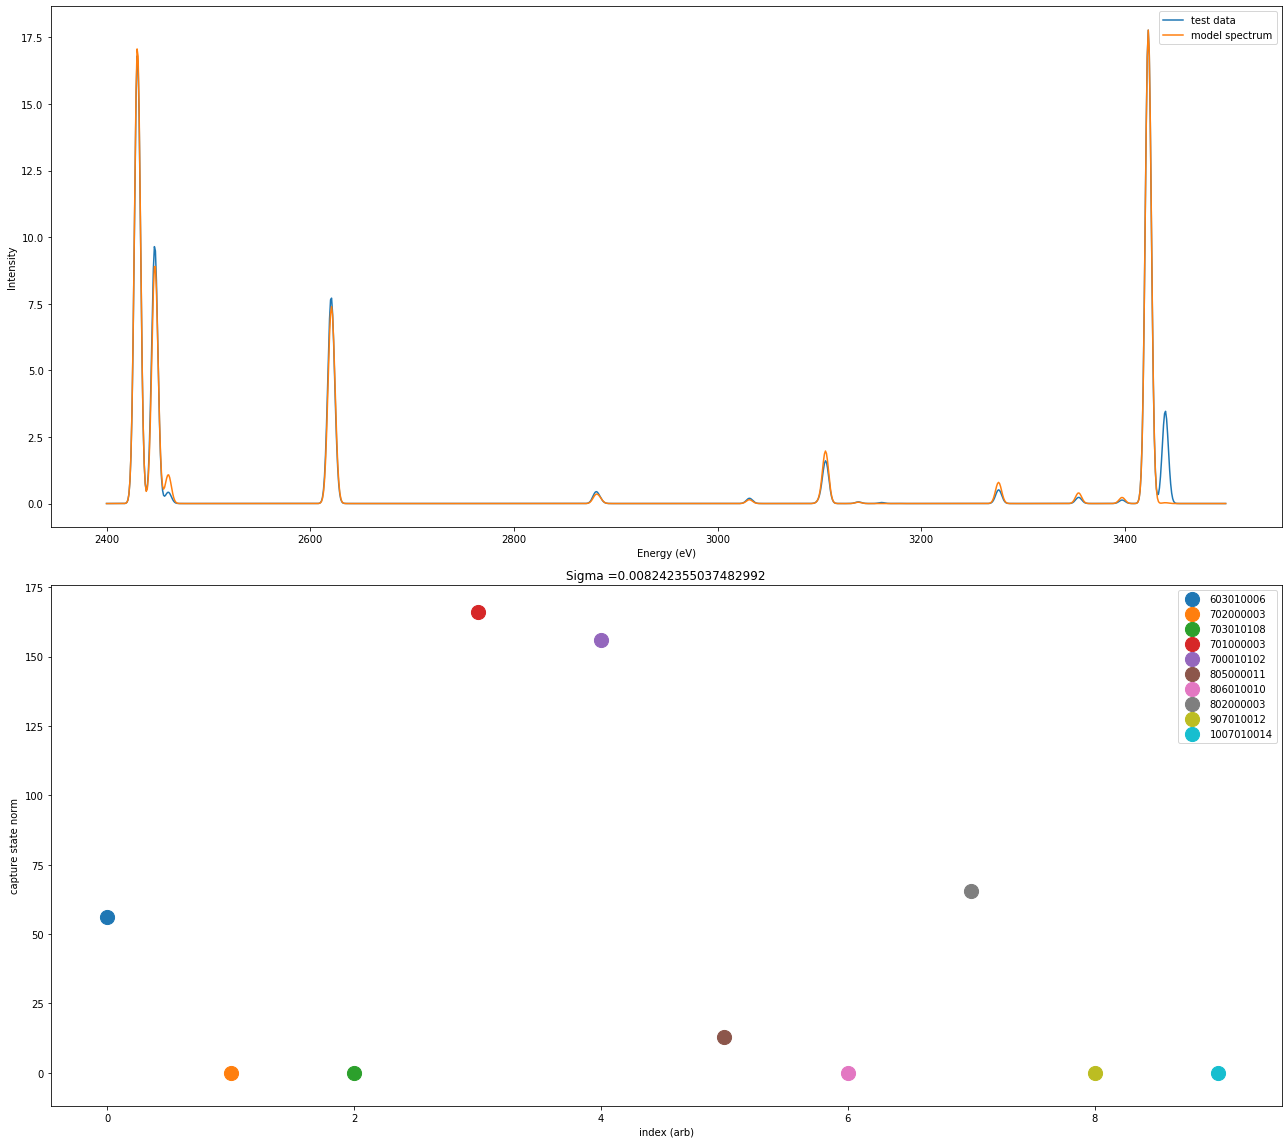

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


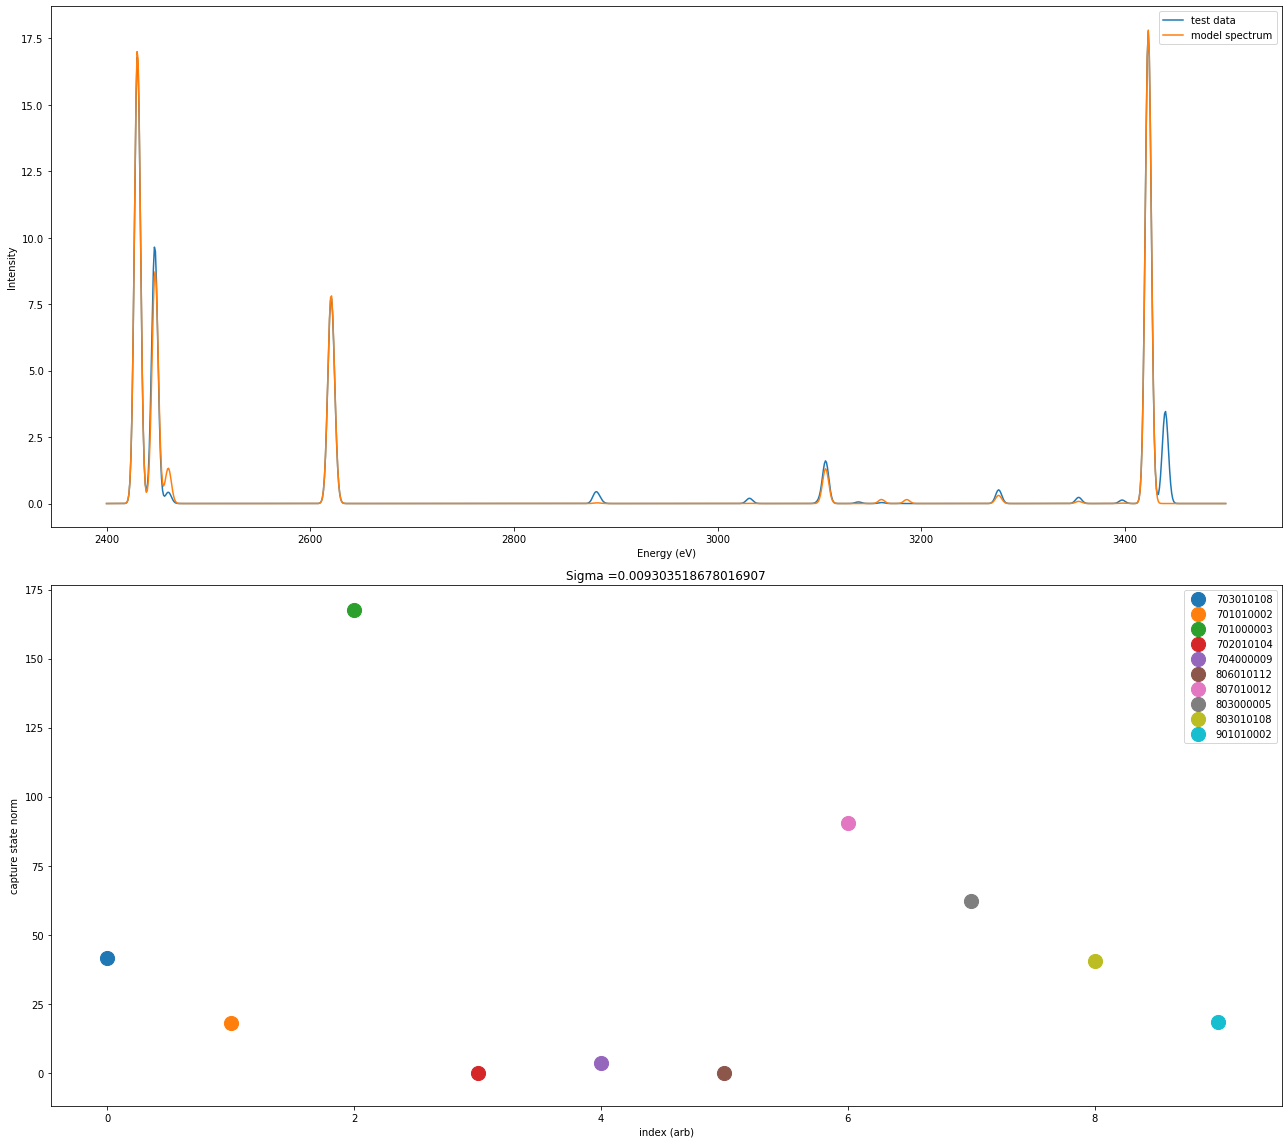

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


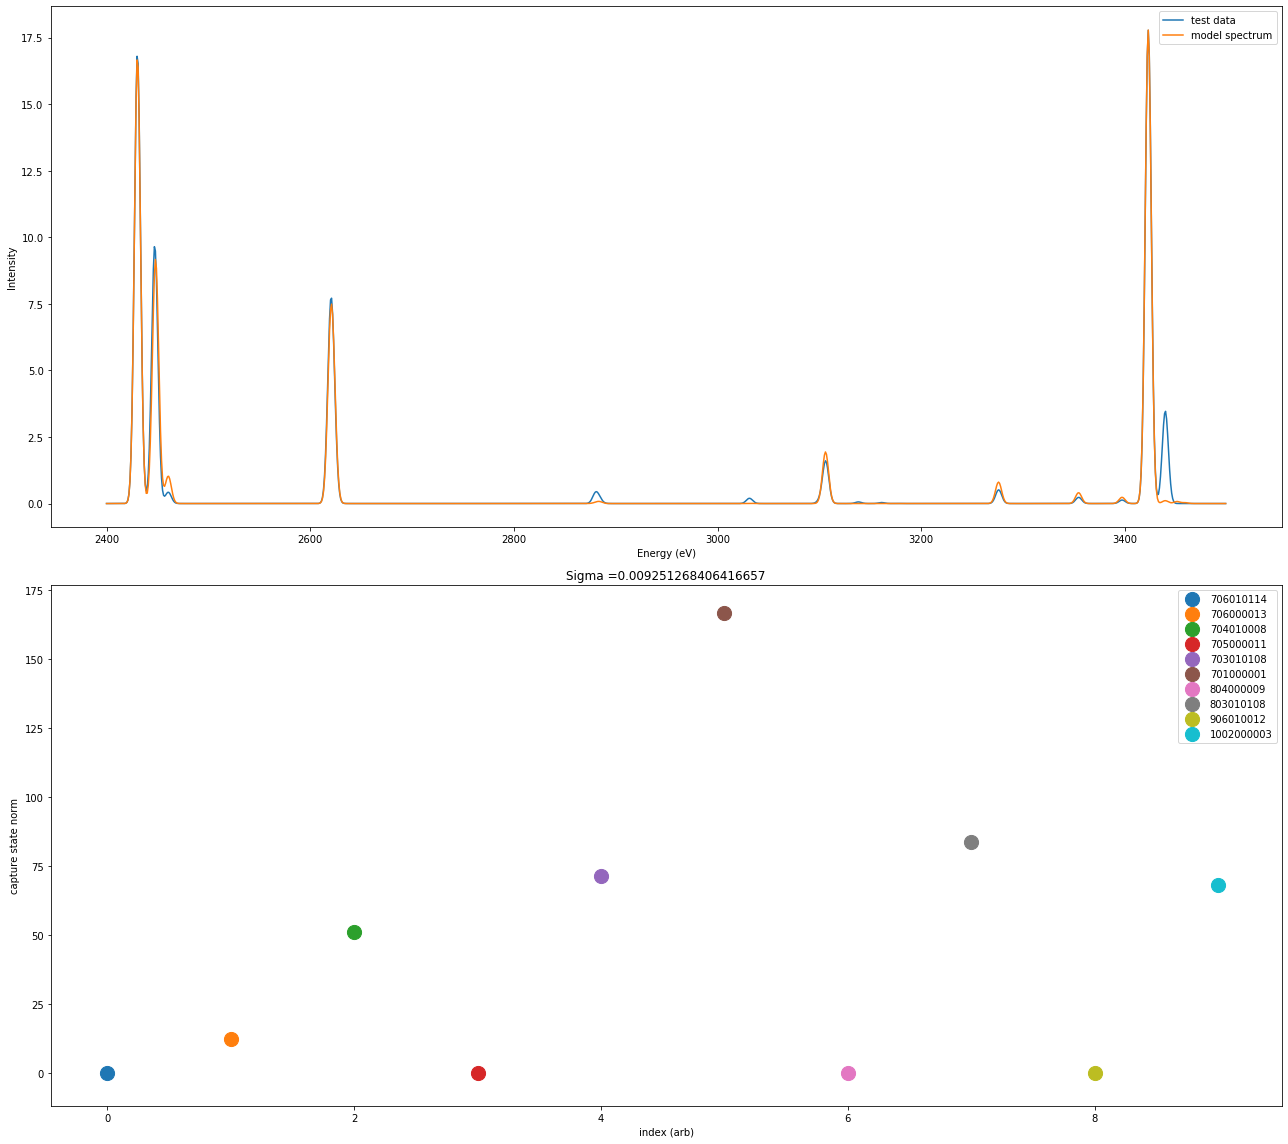

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


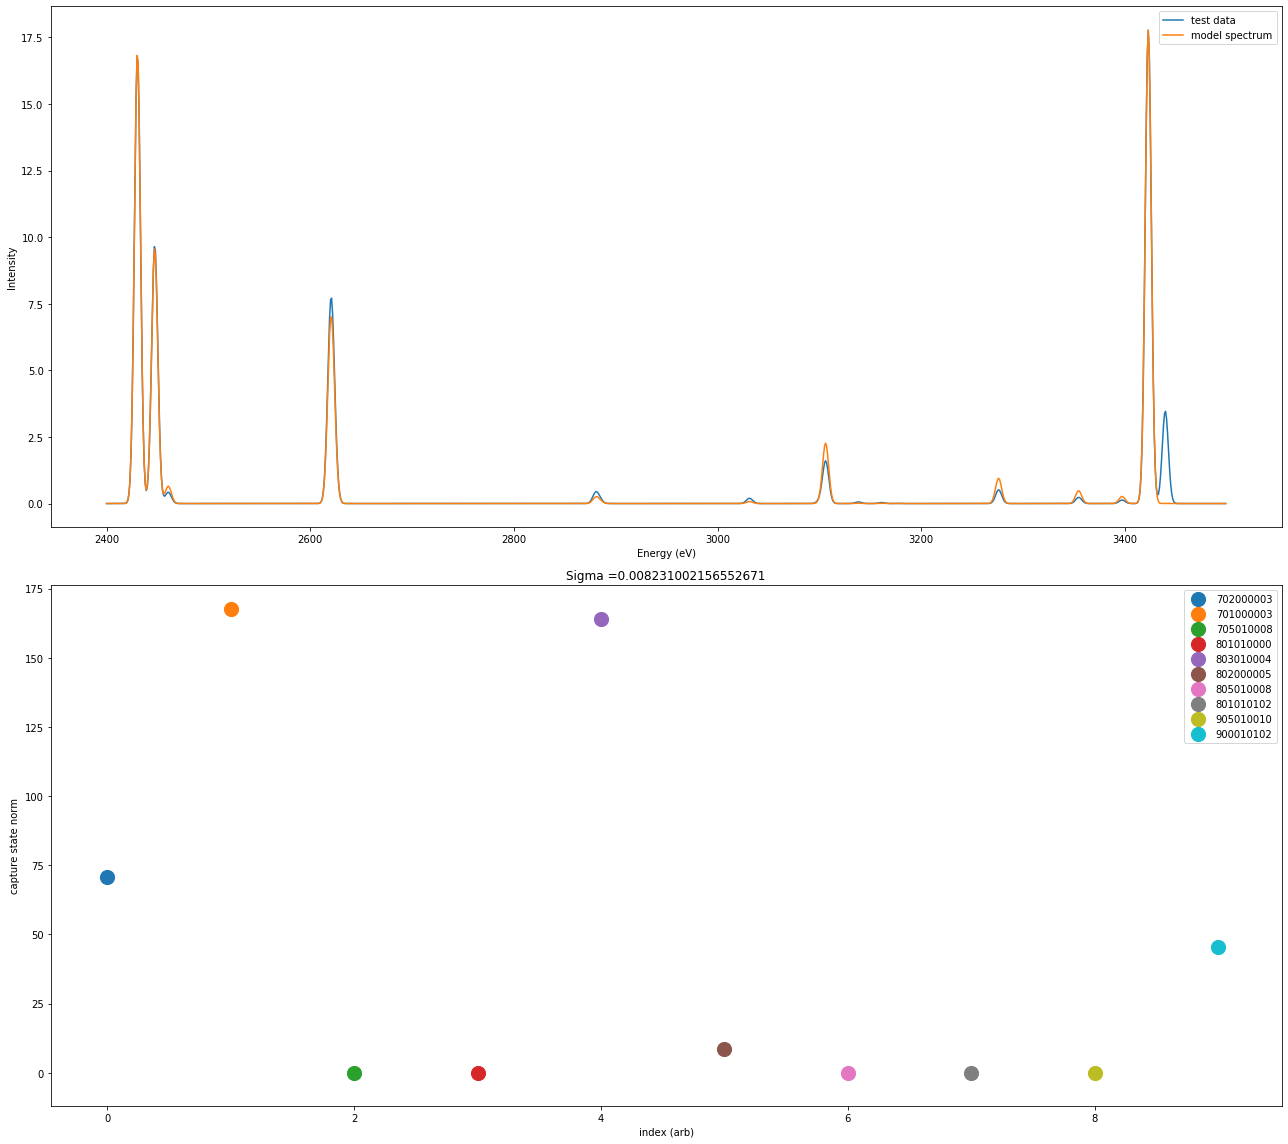

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


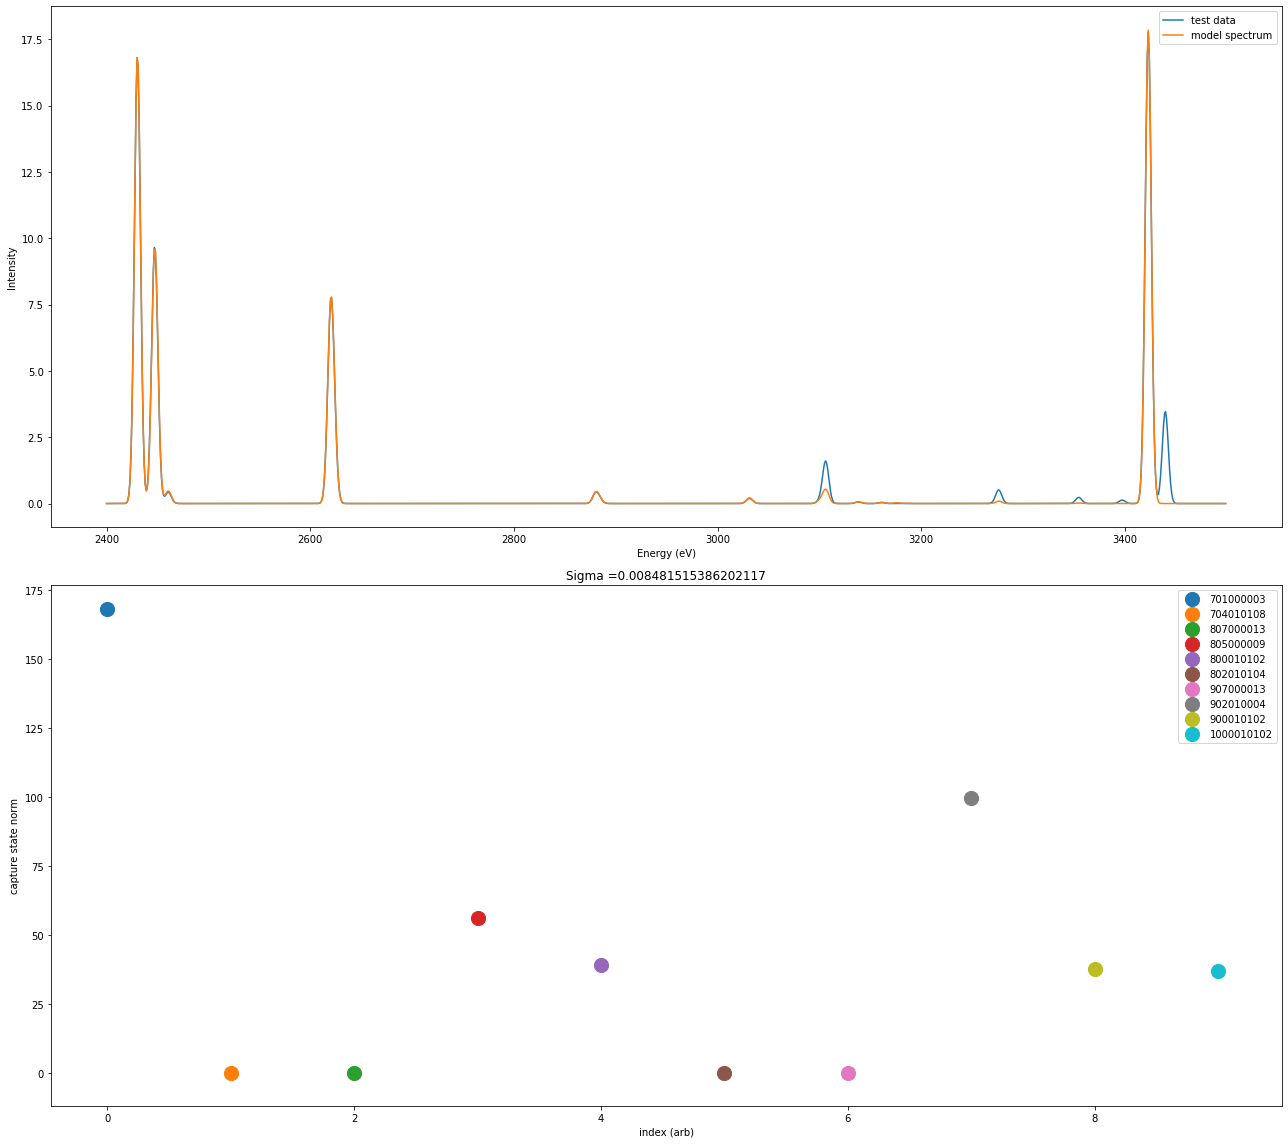

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


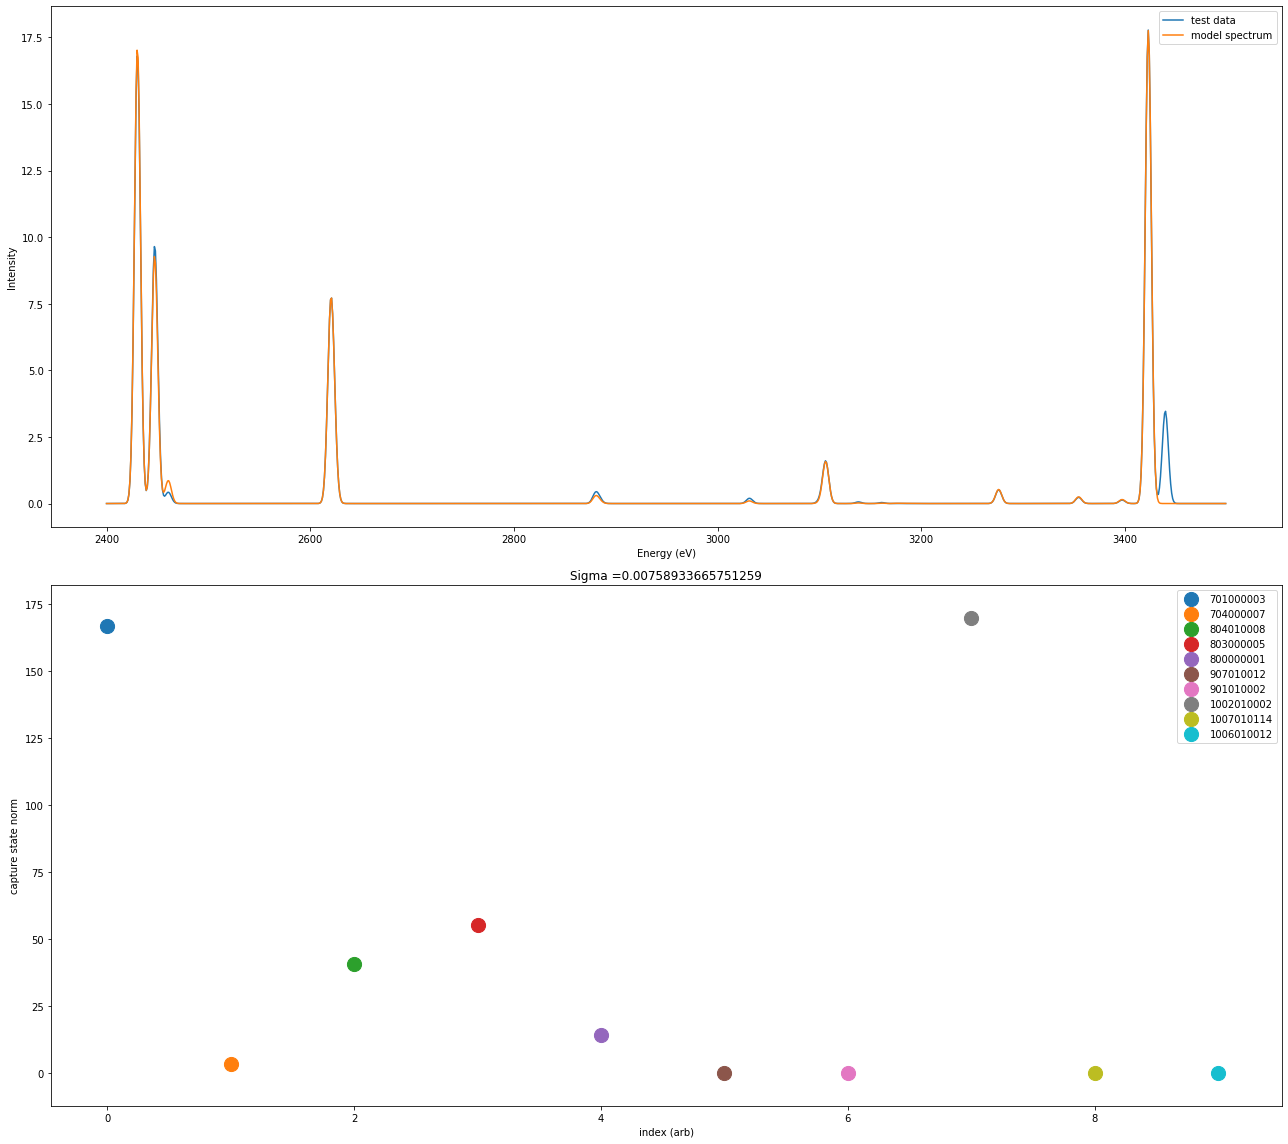

In [26]:
# plot the norm value given by the fit for the best cases (here, for chi squared < 1e-21)

all_minimizers=np.asarray(all_minimizers)
all_norms=np.asarray(all_norms)
all_keys=np.asarray(all_keys)
best_indices=np.where(all_minimizers<1e-2)[0].tolist()


#print(best_indices)

for i in best_indices:
    #print(all_keys[i])
    #print(all_norms[i])
    #print(all_norms[i,0])
    fig=plt.figure(figsize=(18, 16))
    plt.subplot(2,1,1)
    plt.plot(data_x,data_y,label='test data')
    plt.plot(data_x,spectra[i],label='model spectrum')
    plt.xlabel('Energy (eV)')
    plt.ylabel('Intensity')
    plt.legend()
    #plt.title(str(all_keys[i]))
    for j in range(len(all_norms[i])):
        #print(j)
        plt.subplot(2,1,2)
        plt.scatter(j,all_norms[i,j],label=all_keys[i,j],s=200)
        plt.title('Sigma ='+str(all_minimizers[i]))
        plt.xlabel('index (arb)')
        plt.ylabel('capture state norm')
        plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
# plt.title('Sigma= '+str(result.params['m1_m_sig'].value))
    

In [46]:
# silencing this for now. It's not exactly helpful as is because it shows me the norm assigned for each capture state
# that was attempted, but not the assignment of norm within one particular composite model. 

# # now plot some histograms: plotting, for each key (i.e., capture state) in the runs with the best reduced chi 
# # squared, a histogram of the norm of that key. To try to see if there is much spread in the assignment
# # of each norm.

# keylist=list(mydict.keys())
# keylist=[int(i) for i in keylist]

# from collections import defaultdict
# keyhist=defaultdict(list)

# for i in best_indices:
#     #print('best_indices num = '+str(i))
#     #print('all_keys of this best index are: '+str(all_keys[i]))
#     for j in range(len(all_keys[1])):
#         #print('now looping through index '+str(j)+' of all norms/keys')
#         for k in range(len(keylist)):
#             #print('searching for key called '+str(keylist[k]))
#             if(all_keys[i,j]==keylist[k]):
#                 keyhist[keylist[k]].append(all_norms[i,j])
#                 #print(keyhist)
                
# #print(keyhist)

# #all_values = keyhist.values()
# max_value = max(max(keyhist.values()))
# min_value = min(min(keyhist.values()))
# print(max_value, min_value)
# for key,val in keyhist.items():
#     #print(key, "=>", val)
#     #hist,bins=np.histogram(val,bins=10)
#     #print(hist,bins)
#     plt.hist(val, bins=100, range=(min_value, max_value), label=key)
#     plt.legend()
#     plt.show()
    